In [1]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=0df2ec8e5c24c330cc73b96b146989c3da32fec338f4bcf0bfbafca95a39915d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
Note: you may need to restart the kernel to use updated packages.


In [67]:
# General Libraries
import re
import gc
import os
import cv2
import copy
import math
import shutil
from tqdm import tqdm
from time import time
import datetime as dtime
from pprint import pprint
from sklearn.utils import shuffle
from datetime import datetime, timedelta
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn import BCEWithLogitsLoss
from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

In [3]:
train = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")

# Get image path
base_path = "/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_dicomsdl_512/train_images_processed_cv2_dicomsdl_512/"
''
all_paths = []
for k in tqdm(range(len(train))):
    row = train.iloc[k, :]
    all_paths.append(base_path + str(row.patient_id) + "/" + str(row.image_id) + ".png")
    
train["path"] = all_paths

display(train.head())

100%|██████████| 54706/54706 [00:07<00:00, 7494.71it/s]


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/...


In [4]:
def handle_directory(path, folder_name, erase=False):
    # Create the full path to the folder
    folder_path = os.path.join(path, folder_name)
    
    # Check if the folder exists
    if os.path.exists(folder_path):
        if erase:
            # If erase is True, delete the folder and its contents
            shutil.rmtree(folder_path)
            print(f"Folder '{folder_name}' at '{path}' has been erased.")
        else:
            print(f"Folder '{folder_name}' already exists and erase is set to False. No action taken.")
    else:
        print(f"Folder '{folder_name}' does not exist. Creating it now.")
    
    # Create the folder (this will happen after deletion if erase was True)
    os.makedirs(folder_path, exist_ok=True)
    print(f"Folder '{folder_name}' has been created at '{path}'.")
    return folder_path

def extract_ids(path):
    # Split the path by slashes to extract parts
    parts = path.split('/')
    
    # The last two elements are id_patient and id_image
    id_patient = parts[-2]
    id_image = parts[-1].split('.')[0]  # Remove the file extension to get the id_image
    
    return id_patient, id_image

def fit_image(path_image, folder_path):
    # Reading the image using OpenCV
    X = cv2.imread(path_image)
    
    # Storing the original image for comparison
    original_image = X.copy()
    
    # Get the dimensions of the original image
    height_org, width_org, _ = original_image.shape

    # Cutting off the narrow exterior "frames"
    X = X[5:-5, 5:-5]

    # Creating a binary mask of non-empty pixels
    binary_mask = (X > 20).astype(np.uint8)[:, :, 0]

    # Finding connected components with statistics
    output = cv2.connectedComponentsWithStats(binary_mask, 8, cv2.CV_32S)

    # Extracting the statistics of the connected components
    stats = output[2]

    # Finding the largest area which is presumed to be the main data region
    idx = stats[1:, 4].argmax() + 1
    x1, y1, w, h = stats[idx][:4]
    x2 = x1 + w
    y2 = y1 + h

    # Cropping the image to the main data region
    X_fit = X[y1: y2, x1: x2]

    # Get the dimensions of the cropped image
    height_crop, width_crop = X_fit.shape[:2]

    patient_id, image_id = extract_ids(path_image)

    # Creating directory for the patient if it doesn't exist
    output_dir = os.path.join(folder_path, patient_id)
    os.makedirs(output_dir, exist_ok=True)

    # Saving the processed image
    output_path = os.path.join(output_dir, f'{image_id}.png')
    cv2.imwrite(output_path, X_fit[:, :, 0])
    
    return output_path, patient_id, image_id, (width_org, height_org), (width_crop, height_crop)

def fit_all_images(all_images, folder_path):
    data = []
    # Process each image sequentially
    for fname in tqdm(all_images, total=len(all_images)):
        output_dir, patient_id, image_id, dimensions_org, dimensions_crop = fit_image(fname, folder_path)
        data.append({
            'patient_id': patient_id,
            'image_id': image_id,
            'dimensions_org': dimensions_org,  # Store original dimensions as a tuple
            'dimensions_crop': dimensions_crop,  # Store cropped dimensions as a tuple
            'path_image_processed': output_dir
        })
    df = pd.DataFrame(data)
    return df

def handle_directory(base_path, folder_name, erase=False):
    """
    Handle the creation of the directory where the processed images will be saved.
    
    Parameters:
    base_path (str): The base directory path.
    folder_name (str): The name of the folder to be created or used.
    erase (bool): Whether to erase the folder if it already exists.
    
    Returns:
    str: The path to the directory where images will be saved.
    """
    folder_path = os.path.join(base_path, folder_name)
    
    if erase and os.path.exists(folder_path):
        # If the folder exists and erase flag is True, remove the folder and its contents
        shutil.rmtree(folder_path)
    
    # Create the directory if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)
    
    return folder_path

def process_images(train, kaggle_path, folder_name='Processed Image', flag_processed_image=False,erase=False):
    """
    Process images and save the results in a CSV file.

    Parameters:
    train (pd.DataFrame): DataFrame containing the paths to the images.
    kaggle_path (str): Base path for saving the processed images and CSV.
    folder_name (str): Name of the folder to save processed images. Default is 'Processed Image'.
    flag_processed_image (bool): Flag to process images if True, else load from CSV. Default is True.

    Returns:
    pd.DataFrame: DataFrame containing processed image data.
    """
    # Handle the directory where processed images will be saved
    path_processed_image = handle_directory(kaggle_path, folder_name, erase=erase)
    
    # Path to save the CSV file
    path_saved = os.path.join(kaggle_path, 'train_image_processed.csv')
    
    if flag_processed_image:
        # Extract paths of images to process
        path_images = train['path'].values.tolist() #[:10]
        # Process all images
        data_image = fit_all_images(path_images, path_processed_image)
        # Save the processed image data to CSV
        data_image.to_csv(path_saved, index=False)
        print(f"Dataframe saved to: {path_saved}")
    else:
        # Load processed image data from CSV
        data_image = pd.read_csv(path_saved)
    
    # Display the first few rows of the DataFrame
    display(data_image.head())
    
    return data_image

def merge_data(train, train_processed):
    print("Displaying the first few rows of the train dataset:")
    display(train.head())
    
    print("Displaying the data types of 'patient_id' and 'image_id' in the train dataset:")
    print(train[['patient_id', 'image_id']].dtypes)
    
    print("Displaying the first few rows of the train_processed dataset:")
    display(train_processed.head())
    
    print("Displaying the data types of 'patient_id' and 'image_id' in the train_processed dataset:")
    print(train_processed[['patient_id', 'image_id']].dtypes)
    
    print("Converting 'patient_id' and 'image_id' to int64 in the train_processed dataset...")
    train_processed['patient_id'] = train_processed['patient_id'].astype('int64')
    train_processed['image_id'] = train_processed['image_id'].astype('int64')

    print("Verifying the conversion of 'patient_id' and 'image_id' in the train_processed dataset:")
    print(train_processed[['patient_id', 'image_id']].dtypes)
    
    print("Merging the train and train_processed datasets on 'patient_id' and 'image_id' columns...")
    merged_df = pd.merge(train, train_processed, on=['patient_id', 'image_id'])
    
    print("Displaying the first few rows of the merged dataset:")
    display(merged_df.head())
    
    return merged_df


In [15]:
kaggle_path = '/kaggle/working/'
data_image = process_images(train, kaggle_path,flag_processed_image=True,erase=True)

100%|██████████| 54706/54706 [11:47<00:00, 77.37it/s] 


Dataframe saved to: /kaggle/working/train_image_processed.csv


,patient_id,image_id,dimensions_org,dimensions_crop,path_image_processed
0,10006,462822612,"(512, 512)","(117, 318)",/kaggle/working/Processed Image/10006/46282261...
1,10006,1459541791,"(512, 512)","(136, 502)",/kaggle/working/Processed Image/10006/14595417...
2,10006,1864590858,"(512, 512)","(119, 381)",/kaggle/working/Processed Image/10006/18645908...
3,10006,1874946579,"(512, 512)","(107, 301)",/kaggle/working/Processed Image/10006/18749465...
4,10011,220375232,"(512, 512)","(224, 441)",/kaggle/working/Processed Image/10011/22037523...


In [16]:
data = merge_data(train, data_image)

Displaying the first few rows of the train dataset:


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/...


Displaying the data types of 'patient_id' and 'image_id' in the train dataset:
patient_id    int64
image_id      int64
dtype: object
Displaying the first few rows of the train_processed dataset:


,patient_id,image_id,dimensions_org,dimensions_crop,path_image_processed
0,10006,462822612,"(512, 512)","(117, 318)",/kaggle/working/Processed Image/10006/46282261...
1,10006,1459541791,"(512, 512)","(136, 502)",/kaggle/working/Processed Image/10006/14595417...
2,10006,1864590858,"(512, 512)","(119, 381)",/kaggle/working/Processed Image/10006/18645908...
3,10006,1874946579,"(512, 512)","(107, 301)",/kaggle/working/Processed Image/10006/18749465...
4,10011,220375232,"(512, 512)","(224, 441)",/kaggle/working/Processed Image/10011/22037523...


Displaying the data types of 'patient_id' and 'image_id' in the train_processed dataset:
patient_id    object
image_id      object
dtype: object
Converting 'patient_id' and 'image_id' to int64 in the train_processed dataset...
Verifying the conversion of 'patient_id' and 'image_id' in the train_processed dataset:
patient_id    int64
image_id      int64
dtype: object
Merging the train and train_processed datasets on 'patient_id' and 'image_id' columns...
Displaying the first few rows of the merged dataset:


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path,dimensions_org,dimensions_crop,path_image_processed
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...,"(512, 512)","(117, 318)",/kaggle/working/Processed Image/10006/46282261...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...,"(512, 512)","(136, 502)",/kaggle/working/Processed Image/10006/14595417...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...,"(512, 512)","(119, 381)",/kaggle/working/Processed Image/10006/18645908...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...,"(512, 512)","(107, 301)",/kaggle/working/Processed Image/10006/18749465...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/...,"(512, 512)","(224, 441)",/kaggle/working/Processed Image/10011/22037523...


In [17]:
def prepare_data(data, kaggle_path):
    # Map the 'cancer' column to a new 'labels' column
    data['labels'] = data['cancer'].map({0: 'No Cancer', 1: 'Cancer'})
    print("Mapped 'cancer' column to 'labels' column.")

    # Check the number of missing values in the 'age' column before filling
    missing_before = data['age'].isnull().sum()
    print("Number of missing values in 'age' before filling:", missing_before)

    # Fill missing values in the 'age' column with 58
    data['age'] = data['age'].fillna(58)
    print("Filled missing values in 'age' column with 58.")

    # Check the number of missing values in the 'age' column after filling
    missing_after = data['age'].isnull().sum()
    print("Number of missing values in 'age' after filling:", missing_after)

    # Select specified columns
    features = ["patient_id", "image_id", "laterality", "view", "age", "implant", "cancer", "labels", "path_image_processed"]
    data = data[features]
    print("Selected specified columns.")
    
    data = tranform_categorical(data.copy())

    # Path to save the CSV file
    path_saved = os.path.join(kaggle_path, 'train_clean.csv')
    print(f"Path to save the CSV file: {path_saved}")

    # Save the cleaned data to CSV
    data.to_csv(path_saved, index=False)
    print("Saved the cleaned data to CSV.")

    return data

def tranform_categorical(data):
    """
    Encode categorical variables in the dataset.
    
    Parameters:
    - data: A pandas DataFrame containing the data with categorical variables 'laterality' and 'view'.
    
    Returns:
    - data: A pandas DataFrame with the categorical variables encoded as integers.
    """
    # Initialize LabelEncoders for categorical variables
    le_laterality = LabelEncoder()
    le_view = LabelEncoder()

    # Encode 'laterality' and 'view' columns
    data['laterality'] = le_laterality.fit_transform(data['laterality'])
    data['view'] = le_view.fit_transform(data['view'])

    return data

In [18]:
kaggle_path = '/kaggle/working/'
cleaned_data = prepare_data(data.copy(), kaggle_path)
display(cleaned_data)

Mapped 'cancer' column to 'labels' column.
Number of missing values in 'age' before filling: 37
Filled missing values in 'age' column with 58.
Number of missing values in 'age' after filling: 0
Selected specified columns.
Path to save the CSV file: /kaggle/working/train_clean.csv
Saved the cleaned data to CSV.


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,10006,462822612,0,1,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/46282261...
1,10006,1459541791,0,5,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/14595417...
2,10006,1864590858,1,5,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/18645908...
3,10006,1874946579,1,1,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/18749465...
4,10011,220375232,0,1,55.0,0,0,No Cancer,/kaggle/working/Processed Image/10011/22037523...
...,...,...,...,...,...,...,...,...,...
54701,9973,1729524723,1,5,43.0,0,0,No Cancer,/kaggle/working/Processed Image/9973/172952472...
54702,9989,63473691,0,5,60.0,0,0,No Cancer,/kaggle/working/Processed Image/9989/63473691.png
54703,9989,1078943060,0,1,60.0,0,0,No Cancer,/kaggle/working/Processed Image/9989/107894306...
54704,9989,398038886,1,5,60.0,0,0,No Cancer,/kaggle/working/Processed Image/9989/398038886...


In [19]:
def plot_label_distribution(train,dataset_type='Train'):
    """
    Plot the distribution of labels in the DataFrame `train`.

    Parameters:
    train (pd.DataFrame): DataFrame containing the label data.

    The DataFrame must have a column named 'labels'.
    """
    counts = train['labels'].value_counts()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # First subplot: bar chart
    bars = ax1.bar(counts.index, counts.values, color=sns.color_palette("pastel"))

    # Format the number with commas and display it above the bars
    for bar in bars:
        height = bar.get_height()
        percentage = (height / len(train)) * 100  # Calculate the percentage
        ax1.text(bar.get_x() + bar.get_width() / 2, height + (max(counts.values) * 0.02), 
                 f"{height:,.0f}\n({percentage:.1f}%)", ha='center', va='bottom', color='black', fontsize=10)

    #ax1.set_xlabel('Different types of labels in the Cancer column',loc='center')
    ax1.set_ylabel('Frequency')
    #ax1.set_title('Analysis of the target column Cancer', color='red')
    ax1.set_title(f'{dataset_type.capitalize()} Dataset: Analysis of the target column Cancer', color='red')

    # Show both horizontal and vertical grid lines
    ax1.grid(axis='both', linestyle='-', alpha=0.5)

    # Adjust y-limit to ensure text fits within the figure
    ax1.set_ylim(0, max(counts.values) * 1.2)

    # Second subplot: pie chart
    wedges, texts, autotexts = ax2.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=90, 
                                       colors=sns.color_palette("pastel"), textprops=dict(color="w"))

    for text in texts:
        text.set_color('black')
    
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(10)
    
    #ax2.set_title('Distribution of labels', color='blue')
    ax2.set_title(f'{dataset_type.capitalize()} Dataset: Distribution of labels', color='red')

    # Adjust spacing between the two subplots
    plt.subplots_adjust(wspace=0.1)

    # Add a text box with the message
    message = f'The {dataset_type} dataset has {len(train)} samples with the following label distribution.'
    plt.figtext(0.5, 0.01, message, wrap=True, horizontalalignment='center', fontsize=11, color='black')

    plt.show()
    
def create_train_test_subsets(df, target_column, num_class_0_test, num_class_1_test):
    """
    This function takes a dataset and the name of a target column, selects a specific number of elements for each class (0 and 1)
    from the dataset for the test set. The function then determines how many samples should be in the training set
    to ensure there is no overlap and that all data is used.

    Args:
    - df (pd.DataFrame): The dataset to process.
    - target_column (str): The name of the target column.
    - num_class_0_test (int): The number of elements to select for class 0 in the test set.
    - num_class_1_test (int): The number of elements to select for class 1 in the test set.

    Returns:
    - pd.DataFrame: The training dataset.
    - pd.DataFrame: The test dataset.
    """
    
    # Separate the dataset into two subsets based on the target column value
    df_class_0 = df[df[target_column] == 0]
    df_class_1 = df[df[target_column] == 1]
    
    # Check if the requested number of test samples is available
    if num_class_0_test > len(df_class_0) or num_class_1_test > len(df_class_1):
        raise ValueError("Not enough samples available for the specified test set sizes.")
    
    # Select the samples for the test set
    df_class_0_test = df_class_0.sample(n=num_class_0_test, random_state=42).drop_duplicates()
    df_class_1_test = df_class_1.sample(n=num_class_1_test, random_state=42).drop_duplicates()
    
    # Determine the number of samples for the training set
    df_class_0_train = df_class_0.drop(df_class_0_test.index)
    df_class_1_train = df_class_1.drop(df_class_1_test.index)
    
    # Combine the training samples for both classes
    df_train = pd.concat([df_class_0_train, df_class_1_train]).reset_index(drop=True)
    
    # Combine the test samples for both classes
    df_test = pd.concat([df_class_0_test, df_class_1_test]).reset_index(drop=True)
    
    # Shuffle the rows of the training and test datasets
    df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
    df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df_train, df_test

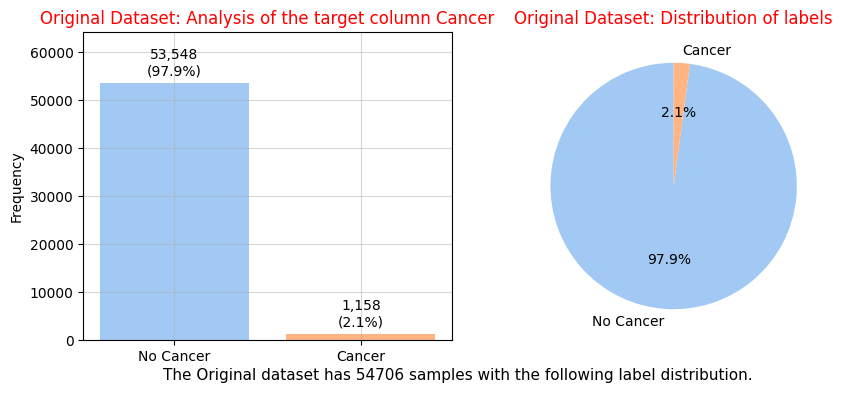

In [20]:
plot_label_distribution(cleaned_data,'Original')

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_dataset_model_1(df):
    """
    Divise un dataset en ensembles d'entraînement et de test pour le Modèle 1, selon les classes spécifiées.

    Pour le Modèle 1, les ensembles sont divisés comme suit :
    - Classe "No Cancer": 42838 images pour l'entraînement, 10710 images pour le test
    - Classe "Cancer": 926 images pour l'entraînement, 232 images pour le test

    Paramètres:
    df (DataFrame): Le dataset contenant les images et leurs étiquettes.

    Retourne:
    Tuple[DataFrame, DataFrame]: Deux DataFrames contenant les ensembles d'entraînement et de test respectivement.
    """
    # Filtrer les données pour la classe "Cancer" et "No Cancer"
    cancer_data = df[df['labels'] == 'Cancer']
    no_cancer_data = df[df['labels'] == 'No Cancer']

    # Vérification des tailles des datasets
    print(f"Total Cancer images: {len(cancer_data)}")
    print(f"Total No Cancer images: {len(no_cancer_data)}")

    # Diviser les données "Cancer" en ensembles d'entraînement et de test
    cancer_train, cancer_test = train_test_split(cancer_data, train_size=926, test_size=232, random_state=42, shuffle=True)

    # Diviser les données "No Cancer" en ensembles d'entraînement et de test
    no_cancer_train, no_cancer_test = train_test_split(no_cancer_data, train_size=42838, test_size=10710, random_state=42, shuffle=True)

    # Combiner les ensembles d'entraînement et de test
    train_data = pd.concat([cancer_train, no_cancer_train])
    test_data = pd.concat([cancer_test, no_cancer_test])

    # Réinitialiser les index et mélanger les données
    train_data = train_data.reset_index(drop=True).sample(frac=1, random_state=42).reset_index(drop=True)
    test_data = test_data.reset_index(drop=True).sample(frac=1, random_state=42).reset_index(drop=True)

    # Retourner les datasets divisés
    return train_data, test_data

def split_dataset_model_2(df):
    """
    Divise un dataset en ensembles d'entraînement et de test pour le Modèle 2, en traitant le déséquilibre des classes.

    Pour le Modèle 2, les ensembles sont divisés comme suit :
    - Classe "No Cancer": 4000 images pour l'entraînement, 1000 images pour le test (sélection sur un sous-ensemble de 5000 images)
    - Classe "Cancer": 926 images pour l'entraînement, 232 images pour le test (sélection sur l'ensemble complet de 1158 images)

    Paramètres:
    df (DataFrame): Le dataset contenant les images et leurs étiquettes.

    Retourne:
    Tuple[DataFrame, DataFrame]: Deux DataFrames contenant les ensembles d'entraînement et de test respectivement.
    """
    # Filtrer les données pour la classe "Cancer" et "No Cancer"
    cancer_data = df[df['labels'] == 'Cancer']
    no_cancer_data = df[df['labels'] == 'No Cancer']

    # Vérification des tailles des datasets
    print(f"Total Cancer images: {len(cancer_data)}")
    print(f"Total No Cancer images: {len(no_cancer_data)}")

    # Sélectionner un sous-ensemble de 5000 images pour la classe "No Cancer"
    no_cancer_data_sample = no_cancer_data.sample(n=5000, random_state=42)

    # Diviser les données "Cancer" en ensembles d'entraînement et de test
    cancer_train, cancer_test = train_test_split(cancer_data, train_size=926, test_size=232, random_state=42, shuffle=True)

    # Diviser les données "No Cancer" en ensembles d'entraînement et de test
    no_cancer_train, no_cancer_test = train_test_split(no_cancer_data_sample, train_size=4000, test_size=1000, random_state=42, shuffle=True)

    # Combiner les ensembles d'entraînement et de test
    train_data = pd.concat([cancer_train, no_cancer_train])
    test_data = pd.concat([cancer_test, no_cancer_test])

    # Réinitialiser les index et mélanger les données
    train_data = train_data.reset_index(drop=True).sample(frac=1, random_state=42).reset_index(drop=True)
    test_data = test_data.reset_index(drop=True).sample(frac=1, random_state=42).reset_index(drop=True)

    # Retourner les datasets divisés
    return train_data, test_data

In [25]:
# Custom colors
class Color:
    S = '\033[1m' + '\033[91m'
    E = '\033[0m'
    
def plot_cases_count(df, title, ax):
    # Count the number of occurrences for each label and sort by index
    cases_count = df['labels'].value_counts().sort_index()

    # Create a bar plot with a custom color palette
    palette = sns.color_palette(["#1f77b4", "#ff7f0e"])  # Custom colors: blue and orange
    sns.barplot(x=cases_count.index, y=cases_count.values, ax=ax, palette=palette)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Case Type', fontsize=12)
    ax.set_ylabel('Number of Cases', fontsize=12)
    ax.set_xticks(range(len(cases_count.index)))
    ax.set_xticklabels(cases_count.index, fontsize=12)
    
    # Add annotations for each bar
    for i, count in enumerate(cases_count.values):
        ax.text(i, count, f'{count}', ha='center', va='bottom', fontsize=10, color='black')

---------------------------------------------------------------------------------------------------------- Modèle 1 -------------------------------------------------------------------------------------
Total Cancer images: 1158
Total No Cancer images: 53548
Training data size: 43764
Test data size: 10942


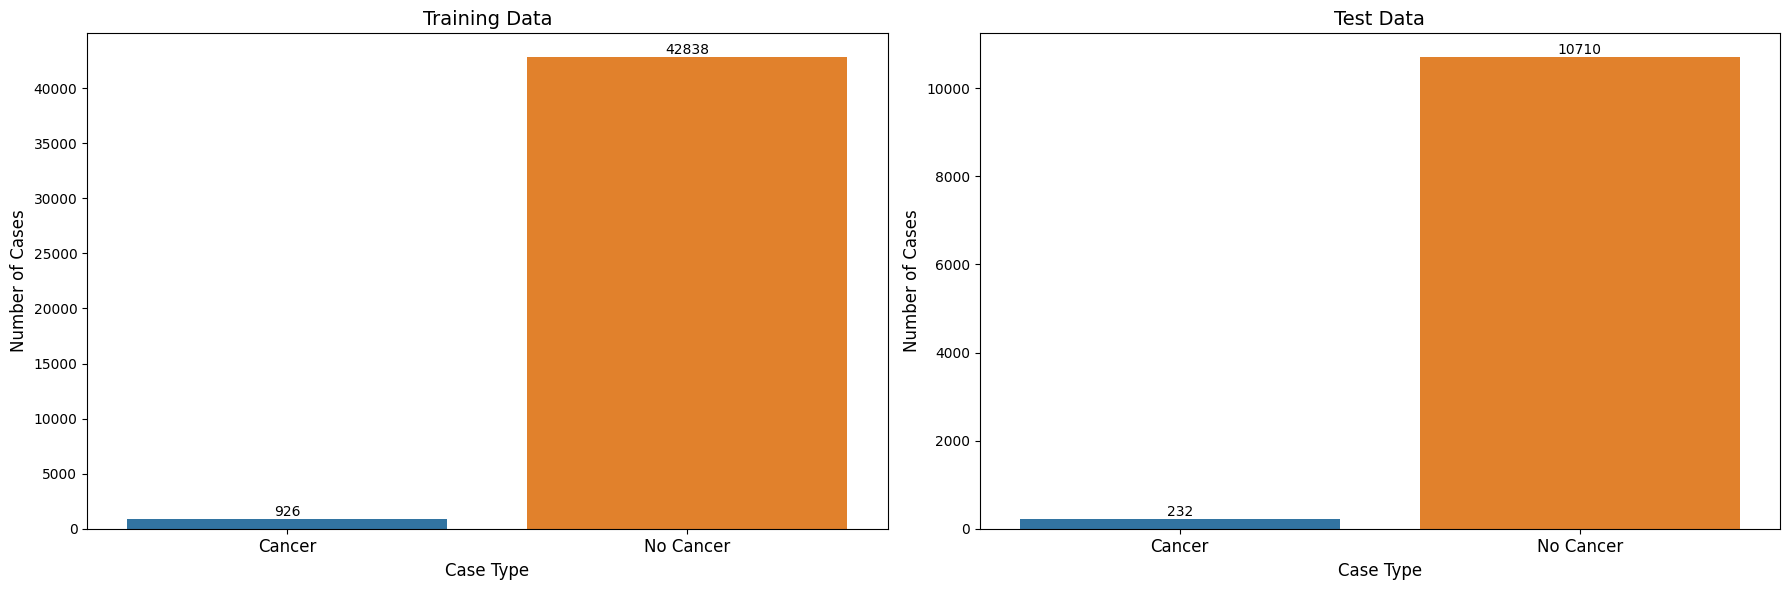

---------------------------------------------------------------------------------------------------------- Modèle 2 -------------------------------------------------------------------------------------
Total Cancer images: 1158
Total No Cancer images: 53548
Training data size: 4926
Test data size: 1232


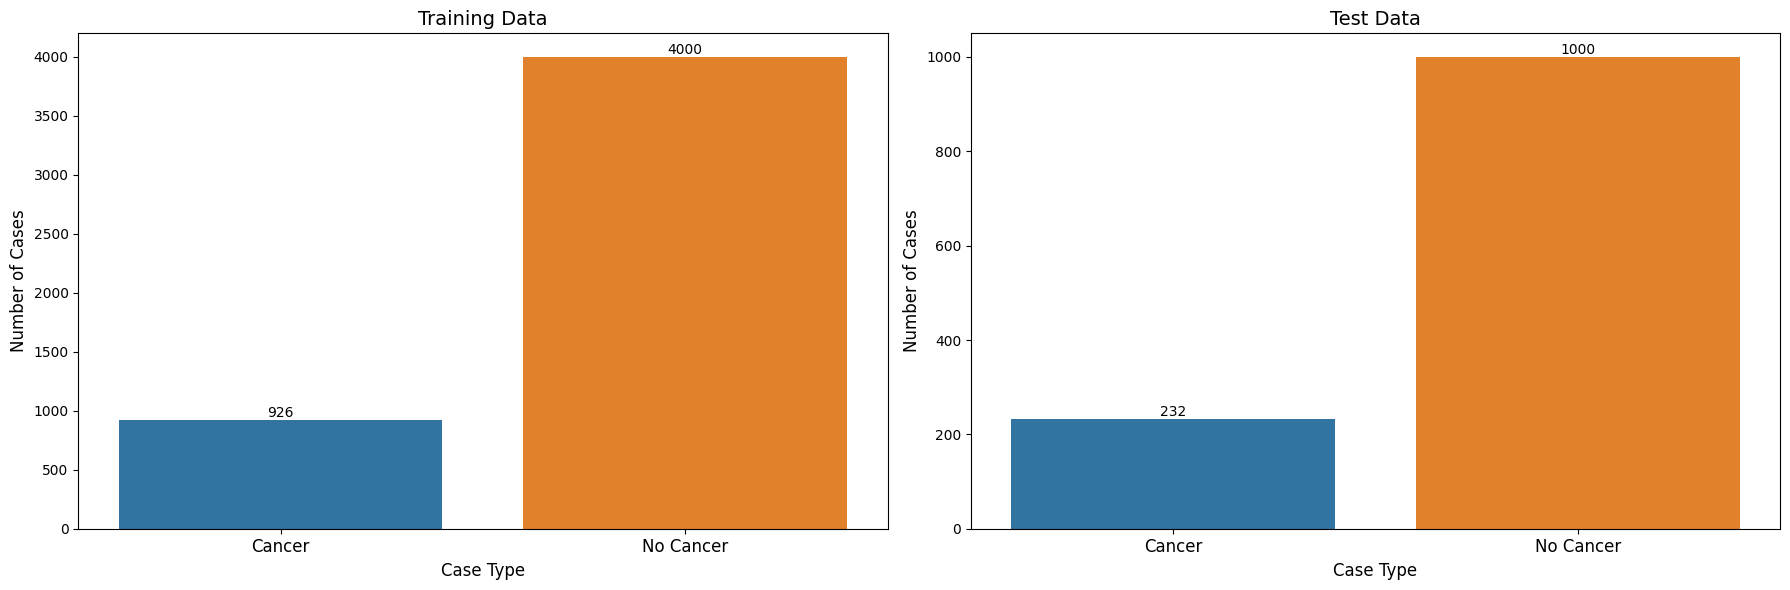

In [33]:
print(Color.S + f"---------------------------------------------------------------------------------------------------------- Modèle 1 -------------------------------------------------------------------------------------" + Color.E)
# Utilisation de la fonction pour le Modèle 1
train_data, test_data = split_dataset_model_1(cleaned_data)
# Check the sizes of the datasets
print(f'Training data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for training data
plot_cases_count(train_data, 'Training Data', axes[0])

# Plot for test data
plot_cases_count(test_data, 'Test Data', axes[1])

plt.tight_layout()
plt.show()

print(Color.S + f"---------------------------------------------------------------------------------------------------------- Modèle 2 -------------------------------------------------------------------------------------" + Color.E)
# Utilisation de la fonction pour le Modèle 2
train_data, test_data = split_dataset_model_2(cleaned_data)
# Check the sizes of the datasets
print(f'Training data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for training data
plot_cases_count(train_data, 'Training Data', axes[0])

# Plot for test data
plot_cases_count(test_data, 'Test Data', axes[1])

plt.tight_layout()
plt.show()

In [53]:
def create_subset_train(df, target_column, num_class_0, num_class_1):
    """
    Cette fonction prend un ensemble de données et le nom d'une colonne cible, sélectionne un nombre spécifique
    d'éléments pour chaque valeur de la colonne cible (0 et 1), puis fusionne ces sous-ensembles en un seul
    ensemble de données.

    Args:
    - df (pd.DataFrame): L'ensemble de données à traiter.
    - target_column (str): Le nom de la colonne cible.
    - num_class_0 (int): Le nombre d'éléments à sélectionner pour la classe 0.
    - num_class_1 (int): Le nombre d'éléments à sélectionner pour la classe 1.

    Returns:
    - pd.DataFrame: L'ensemble de données fusionné contenant des sous-ensembles équilibrés.
    """
    
    # Séparer l'ensemble de données en deux sous-ensembles en fonction de la valeur de la colonne cible
    df_class_0 = df[df[target_column] == 0]
    df_class_1 = df[df[target_column] == 1]
    
    # Sélectionner un échantillon de taille num_class_0 à partir du sous-ensemble de la classe 0 sans répétition
    df_class_0_sample = df_class_0.sample(n=num_class_0, random_state=42).drop_duplicates()
    
    # Sélectionner un échantillon de taille num_class_1 à partir du sous-ensemble de la classe 1 sans répétition
    df_class_1_sample = df_class_1.sample(n=num_class_1, random_state=42).drop_duplicates()
    
    # Fusionner les deux échantillons en un seul ensemble de données
    df_sample = pd.concat([df_class_0_sample, df_class_1_sample]).reset_index(drop=True)
    
    # Mélanger les lignes de l'ensemble de données résultant
    df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return df_sample

---------------------------------------------------------------------------------------------------------- Modèle 1 -------------------------------------------------------------------------------------
Total Cancer images: 1158
Total No Cancer images: 53548
Training data size: 43764
Test data size: 10942


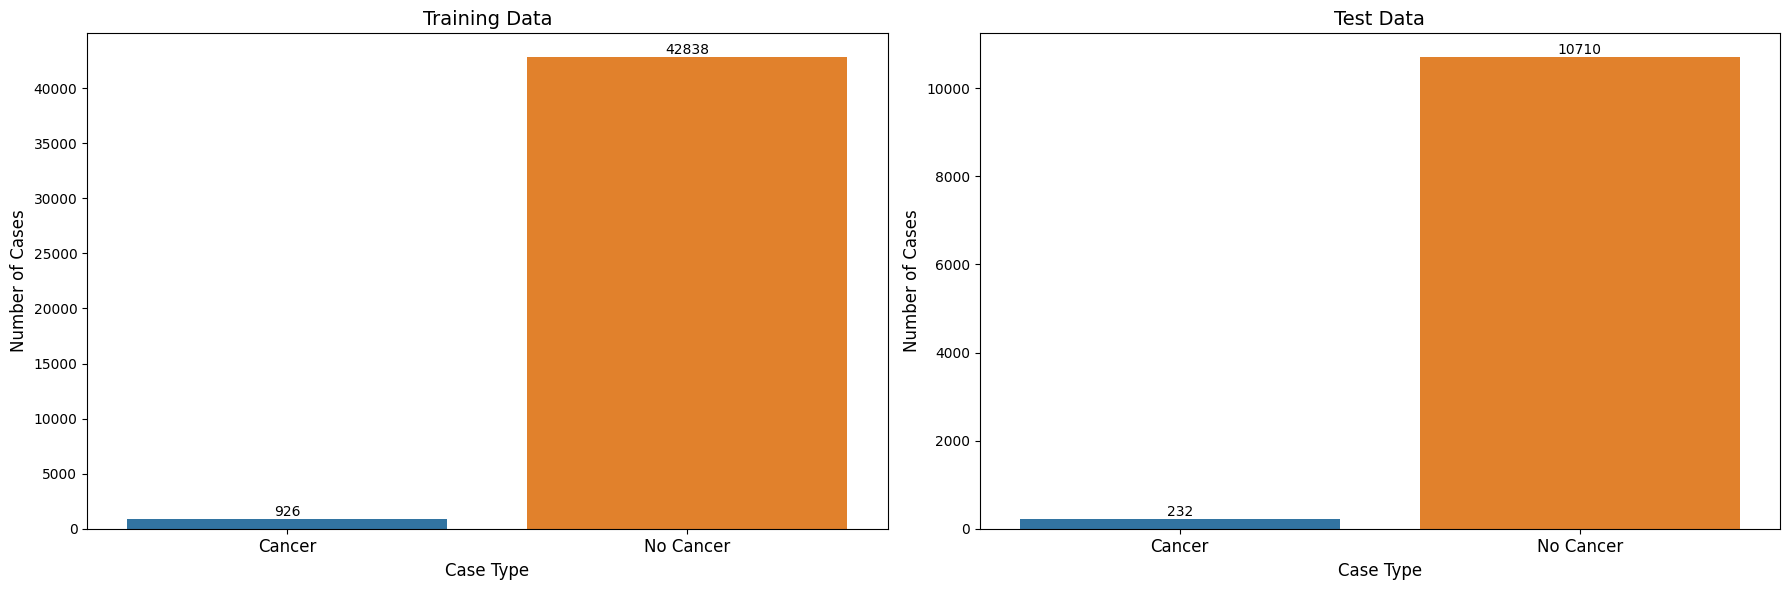

In [59]:
print(Color.S + f"---------------------------------------------------------------------------------------------------------- Modèle 1 -------------------------------------------------------------------------------------" + Color.E)
# Utilisation de la fonction pour le Modèle 1
train_data, test_data = split_dataset_model_1(cleaned_data)
# Check the sizes of the datasets
print(f'Training data size: {len(train_data)}')
print(f'Test data size: {len(test_data)}')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot for training data
plot_cases_count(train_data, 'Training Data', axes[0])

# Plot for test data
plot_cases_count(test_data, 'Test Data', axes[1])

plt.tight_layout()
plt.show()

In [60]:
# PyTorch
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize, RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise, Rotate, RandomResizedCrop, ShiftScaleRotate, ToGray)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='albumentations')

import logging
logging.getLogger('albumentations').setLevel(logging.ERROR)

# Custom colors
class Color:
    S = '\033[1m' + '\033[91m'
    E = '\033[0m'


class My_Custom_RSNA_Dataset(Dataset): 
    def __init__(self, dataframe, csv_columns, transform=None, resize_dims=(224, 224)):
        self.dataframe = dataframe
        self.csv_columns = csv_columns
        self.resize_dims = resize_dims  # Set desired resize dimensions (width, height)
        
        # Data Augmentation (custom for each dataset type)
        # Use provided transform if available, otherwise default to basic tensor conversion
        self.transform = transform if transform else Compose([ToTensorV2()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        '''Take each row in batch at a time.'''
        # Select path and read image
        image_path = self.dataframe['path_image_processed'][index]
        
        # Read image from the path
        image = cv2.imread(image_path)
        
        # Resize the image to specified dimensions
        image = cv2.resize(image, self.resize_dims)
        
        # Normalize pixel values to the range [0, 1]
        image = image.astype(np.float32) / 255.0

        # Apply transforms
        transf_image = self.transform(image=image)['image']

        # Import .csv information
        csv_data = np.array(self.dataframe.iloc[index][self.csv_columns].values, dtype=np.float32)

        # Return information, note: no target since it's test data
        return {"image": transf_image,"meta": csv_data,"target": self.dataframe['cancer'][index]}


In [61]:
def set_seed(seed=42):
    """
    Set the seed for generating random numbers.
    
    Args:
        seed (int): The seed to use for the random number generators.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def data_to_device(data):
    """
    Transfer data to the specified device (e.g., CPU or GPU).

    Args:
    data (tuple): A tuple containing the data components to be transferred to the device.
                  Typically, it consists of image, metadata, and targets.

    Returns:
    tuple: A tuple containing the transferred data components, now residing on the specified device.
    """
    # Extract components from the input tuple
    image, metadata, targets = data.values()
    
    # Transfer each component to the specified device
    return image.to(DEVICE), metadata.to(DEVICE), targets.to(DEVICE)

In [62]:
# ----- GLOBAL PARAMS ------
csv_columns = ['laterality', 'view', 'age', 'implant']
no_columns = len(csv_columns)
output_size = 1
# --------------------------
# Use the set_seed function to initialize the seed
set_seed()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', DEVICE)

Device available now: cpu


In [71]:
# Sample data
sample = train_data.head(10) #train_data, test_data

# Instantiate Dataset object
dataset = My_Custom_RSNA_Dataset(sample,csv_columns) #CustomRSNADataset(sample,csv_columns,is_train=True)

# The Dataloader
dataloader = DataLoader(dataset, batch_size=5, shuffle=False,num_workers=4)

# Output of the Dataloader
for k, data in enumerate(dataloader):
    image, meta, targets = data_to_device(data)
    print(Color.S + f"Batch: {k}" + Color.E, "\n" + Color.S + "Image:" + Color.E, image.shape, "\n" + Color.S + "Meta:" + Color.E, meta, "\n" + Color.S + "Targets:" + Color.E, targets, "\n" + "="*50)

Batch: 0 
Image: torch.Size([5, 3, 224, 224]) 
Meta: tensor([[ 1.,  1., 50.,  0.],
        [ 0.,  5., 66.,  0.],
        [ 1.,  1., 51.,  0.],
        [ 0.,  1., 72.,  0.],
        [ 1.,  1., 48.,  0.]]) 
Targets: tensor([0, 0, 0, 0, 0]) 
Batch: 1 
Image: torch.Size([5, 3, 224, 224]) 
Meta: tensor([[ 1.,  1., 65.,  0.],
        [ 1.,  5., 40.,  0.],
        [ 0.,  5., 53.,  0.],
        [ 0.,  5., 56.,  0.],
        [ 0.,  1., 65.,  0.]]) 
Targets: tensor([0, 0, 0, 0, 0]) 


In [72]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=(1,1), gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, preds, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(torch.flatten(preds), torch.flatten(targets).float())
        logits=nn.Sigmoid()(preds)
        F_loss = (self.alpha[0]*(targets)*((1-logits)**self.gamma)+ self.alpha[1]*(1-targets)*((logits)**self.gamma)) * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [73]:
class EffNetNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = EfficientNet.from_pretrained('efficientnet-b2')
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(1408 + 250, self.output_size))
        
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features.extract_features(image)
        image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out

In [74]:
# Load Model
EffNetNet_model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Explanation:
# This line creates an instance of an EfficientNet-based neural network model called 'model_example2'
# and transfers it to the specified device (e.g., CPU or GPU) using the '.to(DEVICE)' method.

# Outputs
out = EffNetNet_model(image, meta, prints=True)

# Explanation:
# This line passes input data (image and metadata) through the 'model_example2' neural network model,
# producing output predictions ('out'). If 'prints' is set to True, additional information may be printed
# during the forward pass of the model.

# Criterion example
#criterion_example = nn.BCEWithLogitsLoss()
criterion_example =FocalLoss(alpha=(50,1))

# Explanation:
# This line creates an instance of the Binary Cross-Entropy (BCE) loss function called 'criterion_example',
# which is commonly used for binary classification tasks. 

# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, targets.unsqueeze(1).float()) 

# Explanation:
# This line calculates the loss value by comparing the model predictions ('out') with the target labels ('targets').
# Before applying the loss function, the target labels are unsqueezed along dimension 1 using 'unsqueeze(1)' 
# to match the shape of the model predictions. The target labels are also converted to float using '.float()'
# to ensure compatibility with the model predictions.

print("="*50)
print(Color.S+'Loss:'+Color.E, loss.item())

Loaded pretrained weights for efficientnet-b2
Input Image shape: torch.Size([5, 3, 224, 224]) 
Input metadata shape: torch.Size([5, 4])
Features Image shape: torch.Size([5, 1408])
Meta Data: torch.Size([5, 250])
Concatenated Data: torch.Size([5, 1658])
Out shape: torch.Size([5, 1])
Loss: 0.18559984862804413


In [75]:
class ResNet50Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = resnet50(pretrained=True) # 1000 neurons out
        # (metadata)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 500),
                                 nn.BatchNorm1d(500),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Linear(1000 + 500, output_size)
        
        
    def forward(self, image, meta, prints=False):
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out

In [76]:
# Load Model
ResNet50_model = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Outputs
out = ResNet50_model(image, meta, prints=True)

# Criterion example
#criterion_example = nn.BCEWithLogitsLoss()
criterion_example = FocalLoss(alpha=(50,1))

# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, targets.unsqueeze(1).float()) 
print("="*50)
print(Color.S+'Loss:'+Color.E, loss.item())

Input Image shape: torch.Size([5, 3, 224, 224]) 
Input metadata shape: torch.Size([5, 4])
Features Image shape: torch.Size([5, 1000])
Meta Data: torch.Size([5, 500])
Concatenated Data: torch.Size([5, 1500])
Out shape: torch.Size([5, 1])
Loss: 0.21214227378368378


In [77]:
def create_or_recreate_folder(base_path, folder_name):
    folder_path = os.path.join(base_path, folder_name)
    
    # Check if the folder exists
    if os.path.exists(folder_path):
        # Remove the folder if it exists
        shutil.rmtree(folder_path)
    
    # Create the folder
    os.makedirs(folder_path)
    
    return folder_path

def create_directory(base_path, folder_name, is_true=False):
    """
    Create a directory if it doesn't exist. Optionally, delete existing directory and recreate it.

    Args:
    - base_path (str): The base path where the directory should be created.
    - folder_name (str): The name of the directory to be created.
    - is_true (bool, optional): If True, delete existing directory and recreate it. Default is False.

    Returns:
    - new_dir_path (str or None): The full path of the created directory, or None if creation failed.
    """
    # Full path of the new directory
    new_dir_path = os.path.join(base_path, folder_name)
    
    # Check if the base path exists
    if os.path.exists(base_path):
        # If the directory doesn't exist, create it
        if not os.path.exists(new_dir_path):
            os.makedirs(new_dir_path)
            print(f"Directory '{folder_name}' created successfully at: {new_dir_path}")
        else:
            # If the directory already exists
            print(f"Directory '{folder_name}' already exists at: {new_dir_path}")
            if is_true:
                # Delete the existing directory and recreate it
                shutil.rmtree(new_dir_path)
                os.makedirs(new_dir_path)
                print(f"Directory '{folder_name}' recreated successfully at: {new_dir_path}")
    else:
        # If the base path doesn't exist
        print(f"The path '{base_path}' specified does not exist.")
        new_dir_path = None
    
    return new_dir_path

def create_logs_file(logs_directory, version):
    """
    Creates a logs file inside the specified directory.

    Args:
        logs_directory (str): The directory where the logs file will be created.
        version (str): The version identifier to be included in the logs file name.

    Returns:
        tuple: A tuple containing the file object of the created logs file and the logs directory path.
    """
    # Check if the directory exists, create it if not
    if not os.path.exists(logs_directory):
        os.makedirs(logs_directory)

    # Full path of the logs file
    log_file_path = os.path.join(logs_directory, f"logs_{version}.txt")

    # Create a .txt file for logs
    f = open(log_file_path, "w+")

    return log_file_path


def add_in_file(text, file_path):
    """
    Add text to the end of a file.

    Args:
    text (str): The text to be added to the file.
    file_path (str): The path of the file where the text will be added.

    Returns:
    None
    """
    # Open the file in 'append' mode to add text at the end
    with open(file_path, 'a+') as file:
        # Write the text to the file
        print(text, file=file)

def read_logs_file(log_file_path):
    """
    Read the content of a logs file and print it.

    Args:
    log_file_path (str): The full path of the logs file to be read.

    Returns:
    None
    """
    # Check if the file exists
    if os.path.exists(log_file_path):
        # Open the file and read its content
        with open(log_file_path, "r") as f:
            logs_content = f.read()
        # Print the content
        print(logs_content)
    else:
        print("Logs file not found.")
        
def drop_files_in_directory(directory):
    """
    Drops all files inside the specified directory.

    Args:
    directory (str): The directory path where files will be dropped.

    Returns:
    None
    """
    # Check if the directory exists
    if os.path.exists(directory):
        # Iterate over all files in the directory
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            # Check if the path is a file
            if os.path.isfile(file_path):
                # Remove the file
                os.remove(file_path)
    else:
        print("Directory does not exist.")

def close_file(log_file_path):
    """
    Close the log file safely.
    
    Parameters:
    log_file_path (str): The path to the log file.
    """
    try:
        with open(log_file_path, 'a') as file:
            file.write("\n--- Log File Closed ---\n")
        print(f"Log file at {log_file_path} has been closed.")
    except Exception as e:
        print(f"Error occurred while closing the log file: {e}")


def plot_results(train_losses, val_losses, train_accuracies, val_accuracies):
    print('Finished Training')

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Evolution')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.show()

In [78]:
def display_dataset_statistics(train_data, valid_data):
    """
    Displays the statistics of the training and validation datasets.

    Args:
        train_data (pd.DataFrame): The training dataset containing features and labels.
        valid_data (pd.DataFrame): The validation dataset containing features and labels.
    """
    # Print the dimensions of train_data and valid_data
    #print("")
    print(f"Dimensions of train_data: {train_data.shape}")
    print(f"Dimensions of valid_data: {valid_data.shape}")
    #print("")

    y_train, y_valid = train_data['labels'], valid_data['labels']
    # Print the number of unique classes in y_train and y_valid
    num_classes_train = len(np.unique(y_train))
    num_classes_valid = len(np.unique(y_valid))
    #print(f"Number of unique classes in y_train: {num_classes_train}")
    #print(f"Number of unique classes in y_valid: {num_classes_valid}")
    #print("")
    
    # Print the number of instances per class in y_train and y_valid
    for class_label in np.unique(y_train):
        instances_train = np.sum(y_train.values == class_label)
        instances_valid = np.sum(y_valid.values == class_label)
        print(f"Class {class_label}: Training instances - {instances_train}, Validation instances - {instances_valid}")
        
def display_confusion_matrix(valid_targets, valid_preds_rounded):
    """
    Displays the confusion matrix and classification report for a given set of true labels and predicted labels.

    Args:
        valid_targets (array-like): True labels of the validation set.
        valid_preds_rounded (array-like): Predicted labels of the validation set.
    """
    # Replace 0 with "No Cancer" and 1 with "Cancer" in the predicted and true labels
    y_pred = np.where(np.array(valid_preds_rounded) == 0, "No Cancer", "Cancer")   #valid_predictions)
    y_true = np.where(np.array(valid_targets) == 0, "No Cancer", "Cancer")

    # Classification report
    print("Classification Report:\n", classification_report(y_true, y_pred))

    # Confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred, labels=["No Cancer", "Cancer"])
    categories = ["No Cancer", "Cancer"]
    group_names = ["True Negative", "False Positive", "False Negative", "True Positive"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Display the confusion matrix with seaborn
    plt.figure(figsize=(7, 5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    plt.title("Confusion Matrix")
    plt.show()


In [79]:
def train_model_cross_validation(model, train_original, hyperparameters):
    # Define the threshold
    threshold = 0.5
    
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Using Binary Cross Entropy with Logits for binary classification
    optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])
    
    # Define scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    # Early stopping parameters
    patience = hyperparameters["early_stopping_patience"]

    # Initialize metrics storage for visualization
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_overall_val_f1_score = float('-inf')

    # Initialize stratified cross-validation
    skf = StratifiedKFold(n_splits=hyperparameters["folds"], shuffle=True, random_state=400)

    # Create a log file to store training progress
    log_file_path = create_logs_file(logs_dir, version)

    # Iterate over stratified cross-validation folds
    for fold_idx, (train_index, valid_index) in enumerate(skf.split(train_original.values, train_original['cancer'].values)):

        #print(f"---------- Fold: {fold_idx + 1} ----------")
        print(Color.S + f"---------- Fold: {fold_idx+1} ----------" + Color.E)
        add_in_file(f"---------- Fold: {fold_idx + 1} ----------", log_file_path)
        
        # Read in data for the current fold
        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)
        
        display_dataset_statistics(train_data, valid_data)
        
        # Create custom datasets for training and validation
        print("Creating Data instances for train, test, and validation datasets:")
        train = CustomRSNADataset(train_data, csv_columns, is_train=True)
        
        valid = CustomRSNADataset(valid_data, csv_columns, is_train=True)
        print("Data instances created.")

        # Create DataLoader instances for batching data
        print("Creating DataLoaders for batching data:")
        train_loader = DataLoader(train, batch_size=hyperparameters["train_batch_size"], shuffle=True, num_workers=hyperparameters["num_workers"])
        valid_loader = DataLoader(valid, batch_size=hyperparameters["val_batch_size"], shuffle=False, num_workers=hyperparameters["num_workers"])
        print("DataLoaders created.")

        # Early stopping parameters for this fold
        best_val_f1_score = float('-inf')
        trigger_times = 0
        best_model_state = None

        # Initialize lists to store metrics for visualization
        fold_train_losses = []
        fold_val_losses = []
        fold_train_accuracies = []
        fold_val_accuracies = []

        # Training the model
        for epoch in range(hyperparameters["num_epochs"]):
            start_time = time()
            print(f"Training the model")
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            train_preds = []
            train_labels = []

            # Progress bar for training
            with tqdm(train_loader, unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch+1}, Training")

                # Iterate over batches in the training DataLoader
                for k, batch in enumerate(tepoch):
                    images, meta, labels = data_to_device(batch)
                    optimizer.zero_grad()
                    outputs = model(images, meta)
                    labels = labels.unsqueeze(1).float()
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    predicted = (torch.sigmoid(outputs) > threshold).float()
                    train_preds.extend(predicted.cpu().numpy())
                    train_labels.extend(labels.cpu().numpy())

                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

                    tepoch.set_postfix(loss=train_loss / total, accuracy=100. * correct / total)

            # Calculate training metrics
            train_loss /= len(train_loader.dataset)
            train_accuracy = accuracy_score(train_labels, train_preds)
            train_roc = roc_auc_score(train_labels, train_preds)
            train_precision = precision_score(train_labels, train_preds)
            train_recall = recall_score(train_labels, train_preds)
            train_f1 = f1_score(train_labels, train_preds)

            fold_train_losses.append(train_loss)
            fold_train_accuracies.append(train_accuracy)

            print(f"Training metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {train_accuracy}")
            print(f"ROC: {train_roc}")
            print(f"Precision: {train_precision}")
            print(f"Recall: {train_recall}")
            print(f"F1 score: {train_f1}")
            print(f'Train loss: {train_loss:.4f}')

            # Validate the model's performance on validation set
            print(f"Validating the trained model's performance")
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            val_preds = []
            val_labels = []

            # Progress bar for validation
            with tqdm(valid_loader, unit="batch") as vepoch:
                vepoch.set_description(f"Validation {epoch+1}")
                with torch.no_grad():
                    # Iterate over batches in the validation DataLoader
                    for k, batch in enumerate(vepoch):
                        images, meta, labels = data_to_device(batch)
                        outputs = model(images, meta)
                        labels = labels.unsqueeze(1).float()
                        val_loss += criterion(outputs, labels).item()
                        predicted = (torch.sigmoid(outputs) > threshold).float()

                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)

                        val_preds.extend(predicted.cpu().numpy().flatten().tolist())
                        val_labels.extend(labels.cpu().numpy().flatten().tolist())

                        vepoch.set_postfix(loss=val_loss / total, accuracy=100. * correct / total)

            # Calculate validation metrics
            val_loss /= len(valid_loader.dataset)
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_roc = roc_auc_score(val_labels, val_preds)
            val_precision = precision_score(val_labels, val_preds)
            val_recall = recall_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds)

            fold_val_losses.append(val_loss)
            fold_val_accuracies.append(val_accuracy)

            print(f"Validation metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {val_accuracy}")
            print(f"ROC: {val_roc}")
            print(f"Precision: {val_precision}")
            print(f"Recall: {val_recall}")
            print(f"F1 score: {val_f1}")
            print(f'Validation Loss: {val_loss:.4f}')

            # Display confusion matrix
            print("+++++++++ Confusion Matrix for Validation Dataset +++++++++")
            display_confusion_matrix(val_labels, val_preds)

            # Update scheduler based on validation loss
            scheduler.step(val_loss)

            # Print current learning rate
            for param_group in optimizer.param_groups:
                print(f"Current Learning Rate: {param_group['lr']}")

            # Calculate elapsed time for training + validation
            duration = str(timedelta(seconds=time() - start_time))[:7]

            infos_logs_train = '{} | Epoch: {}/{} | Train Loss: {:.4f} | Acc_tr: {:.3f} | ROC_tr: {:.3f} | Precision_tr: {:.3f} | Recall_tr: {:.3f} | F1_tr: {:.3f}'.format(
                duration, epoch + 1, hyperparameters["num_epochs"], train_loss, train_accuracy, train_roc, train_precision, train_recall, train_f1)
            infos_logs_valid = '{} | Epoch: {}/{} | Valid Loss: {:.4f} | Acc_vd: {:.3f} | ROC_vd: {:.3f} | Precision_vd: {:.3f} | Recall_vd: {:.3f} | F1_vd: {:.3f}'.format(
                duration, epoch + 1, hyperparameters["num_epochs"], val_loss, val_accuracy, val_roc, val_precision, val_recall, val_f1)

            add_in_file(infos_logs_train, log_file_path)
            add_in_file(infos_logs_valid, log_file_path)

            # Check for improvement in validation F1-score
            if val_f1 > best_val_f1_score:
                best_val_f1_score = val_f1
                trigger_times = 0
                best_model_state = model.state_dict()
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print('Early stopping inside the current fold!')
                    break
        add_in_file(f"-----------------------------------------------", log_file_path)

        # Plot results for the current fold
        plot_results(fold_train_losses, fold_val_losses, fold_train_accuracies, fold_val_accuracies)

        # Update overall best model if the current fold's best model is better
        if best_val_f1_score > best_overall_val_f1_score:
            best_overall_val_f1_score = best_val_f1_score
            best_overall_model_state = best_model_state
            best_overall_metrics = {
                'accuracy': val_accuracy,
                'roc': val_roc,
                'precision': val_precision,
                'recall': val_recall,
                'f1': best_val_f1_score
            }


        print(f'Finished Training for Fold {fold_idx + 1}')
        print(f'The best model performance in fold {fold_idx + 1} - Val Acc: {val_accuracy:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1: {best_val_f1_score:.4f} ROC: {val_roc:.4f}')

    # Save the overall best model after completing all folds
    if best_overall_model_state:
        model.load_state_dict(best_overall_model_state)
        name_best_model = 'best_model_overall.pth'
        torch.save(best_overall_model_state, os.path.join(hyperparameters["save_best_model_dir"], name_best_model))
        print(f'The overall best model has been saved with metrics - Val Acc: {best_overall_metrics["accuracy"]:.4f}, Precision: {best_overall_metrics["precision"]:.4f}, Recall: {best_overall_metrics["recall"]:.4f}, F1: {best_overall_metrics["f1"]:.4f}, ROC: {best_overall_metrics["roc"]:.4f}')

    # Close log file
    close_file(log_file_path)

In [80]:
def Train_Model_Applying_k_Fold_Cross_Validation(model, train_original, hyperparameters):
    # Define the threshold
    threshold = 0.5
    
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Using Binary Cross Entropy with Logits for binary classification
    optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])
    
    # Define scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    # Early stopping parameters
    patience = hyperparameters["early_stopping_patience"]

    # Initialize metrics storage for visualization
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_overall_val_f1_score = float('-inf')

    # Initialize stratified cross-validation
    skf = StratifiedKFold(n_splits=hyperparameters["folds"], shuffle=True, random_state=400)

    # Create a log file to store training progress
    log_file_path = create_logs_file(logs_dir, version)

    # Iterate over stratified cross-validation folds
    for fold_idx, (train_index, valid_index) in enumerate(skf.split(train_original.values, train_original['cancer'].values)):

        #print(f"---------- Fold: {fold_idx + 1} ----------")
        print(Color.S + f"---------- Fold: {fold_idx+1} ----------" + Color.E)
        add_in_file(f"---------- Fold: {fold_idx + 1} ----------", log_file_path)
        
        # Read in data for the current fold
        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)
        
        display_dataset_statistics(train_data, valid_data)
        
        # Create custom datasets for training and validation
        print("Creating Data instances for train, test, and validation datasets:")
        train = My_Custom_RSNA_Dataset(train_data, csv_columns) #CustomRSNADataset(train_data, csv_columns, is_train=True)
        valid = My_Custom_RSNA_Dataset(valid_data, csv_columns) #CustomRSNADataset(valid_data, csv_columns, is_train=True)
        print("Data instances created.")

        # Create DataLoader instances for batching data
        print("Creating DataLoaders for batching data:")
        train_loader = DataLoader(train, batch_size=hyperparameters["train_batch_size"], shuffle=True, num_workers=hyperparameters["num_workers"])
        valid_loader = DataLoader(valid, batch_size=hyperparameters["val_batch_size"], shuffle=False, num_workers=hyperparameters["num_workers"])
        print("DataLoaders created.")

        # Early stopping parameters for this fold
        best_val_f1_score = float('-inf')
        trigger_times = 0
        best_model_state = None

        # Initialize lists to store metrics for visualization
        fold_train_losses = []
        fold_val_losses = []
        fold_train_accuracies = []
        fold_val_accuracies = []
        
        # Initialisation du modèle
        # model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)  # Modèle sur le dispositif approprié


        # Training the model
        for epoch in range(hyperparameters["num_epochs"]):
            start_time = time()
            print(f"Training the model")
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            train_preds = []
            train_labels = []

            # Progress bar for training
            with tqdm(train_loader, unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch+1}, Training")

                # Iterate over batches in the training DataLoader
                for k, batch in enumerate(tepoch):
                    images, meta, labels = data_to_device(batch)
                    optimizer.zero_grad()
                    outputs = model(images, meta)
                    labels = labels.unsqueeze(1).float()
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    predicted = (torch.sigmoid(outputs) > threshold).float()
                    train_preds.extend(predicted.cpu().numpy())
                    train_labels.extend(labels.cpu().numpy())

                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

                    tepoch.set_postfix(loss=train_loss / total, accuracy=100. * correct / total)

            # Calculate training metrics
            train_loss /= len(train_loader.dataset)
            train_accuracy = accuracy_score(train_labels, train_preds)
            train_roc = roc_auc_score(train_labels, train_preds)
            train_precision = precision_score(train_labels, train_preds)
            train_recall = recall_score(train_labels, train_preds)
            train_f1 = f1_score(train_labels, train_preds)

            fold_train_losses.append(train_loss)
            fold_train_accuracies.append(train_accuracy)

            print(f"Training metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {train_accuracy}")
            print(f"ROC: {train_roc}")
            print(f"Precision: {train_precision}")
            print(f"Recall: {train_recall}")
            print(f"F1 score: {train_f1}")
            print(f'Train loss: {train_loss:.4f}')

            # Validate the model's performance on validation set
            print(f"Validating the trained model's performance")
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            val_preds = []
            val_labels = []

            # Progress bar for validation
            with tqdm(valid_loader, unit="batch") as vepoch:
                vepoch.set_description(f"Validation {epoch+1}")
                with torch.no_grad():
                    # Iterate over batches in the validation DataLoader
                    for k, batch in enumerate(vepoch):
                        images, meta, labels = data_to_device(batch)
                        outputs = model(images, meta)
                        labels = labels.unsqueeze(1).float()
                        val_loss += criterion(outputs, labels).item()
                        predicted = (torch.sigmoid(outputs) > threshold).float()

                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)

                        val_preds.extend(predicted.cpu().numpy().flatten().tolist())
                        val_labels.extend(labels.cpu().numpy().flatten().tolist())

                        vepoch.set_postfix(loss=val_loss / total, accuracy=100. * correct / total)

            # Calculate validation metrics
            val_loss /= len(valid_loader.dataset)
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_roc = roc_auc_score(val_labels, val_preds)
            val_precision = precision_score(val_labels, val_preds)
            val_recall = recall_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds)

            fold_val_losses.append(val_loss)
            fold_val_accuracies.append(val_accuracy)

            print(f"Validation metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {val_accuracy}")
            print(f"ROC: {val_roc}")
            print(f"Precision: {val_precision}")
            print(f"Recall: {val_recall}")
            print(f"F1 score: {val_f1}")
            print(f'Validation Loss: {val_loss:.4f}')

            # Display confusion matrix
            print("+++++++++ Confusion Matrix for Validation Dataset +++++++++")
            display_confusion_matrix(val_labels, val_preds)

            # Update scheduler based on validation loss
            scheduler.step(val_loss)

            # Print current learning rate
            for param_group in optimizer.param_groups:
                print(f"Current Learning Rate: {param_group['lr']}")

            # Calculate elapsed time for training + validation
            duration = str(timedelta(seconds=time() - start_time))[:7]

            infos_logs_train = '{} | Epoch: {}/{} | Train Loss: {:.4f} | Acc_tr: {:.3f} | ROC_tr: {:.3f} | Precision_tr: {:.3f} | Recall_tr: {:.3f} | F1_tr: {:.3f}'.format(
                duration, epoch + 1, hyperparameters["num_epochs"], train_loss, train_accuracy, train_roc, train_precision, train_recall, train_f1)
            infos_logs_valid = '{} | Epoch: {}/{} | Valid Loss: {:.4f} | Acc_vd: {:.3f} | ROC_vd: {:.3f} | Precision_vd: {:.3f} | Recall_vd: {:.3f} | F1_vd: {:.3f}'.format(
                duration, epoch + 1, hyperparameters["num_epochs"], val_loss, val_accuracy, val_roc, val_precision, val_recall, val_f1)

            #add_in_file(infos_logs_train, log_file_path)
            #add_in_file(infos_logs_valid, log_file_path)

            # Check for improvement in validation F1-score
            if val_f1 > best_val_f1_score:
                best_val_f1_score = val_f1
                trigger_times = 0
                best_model_state = model.state_dict()
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print('Early stopping inside the current fold!')
                    break
        add_in_file(f"-----------------------------------------------", log_file_path)

        # Plot results for the current fold
        plot_results(fold_train_losses, fold_val_losses, fold_train_accuracies, fold_val_accuracies)

        # Update overall best model if the current fold's best model is better
        if best_val_f1_score > best_overall_val_f1_score:
            best_overall_val_f1_score = best_val_f1_score
            best_overall_model_state = best_model_state
            best_overall_metrics = {
                'accuracy': val_accuracy,
                'roc': val_roc,
                'precision': val_precision,
                'recall': val_recall,
                'f1': best_val_f1_score
            }

        print(f'Finished Training for Fold {fold_idx + 1}')
        print(f'The best model performance in fold {fold_idx + 1} - Val Acc: {val_accuracy:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1: {best_val_f1_score:.4f} ROC: {val_roc:.4f}')

    # Save the overall best model after completing all folds
    if best_overall_model_state:
        model.load_state_dict(best_overall_model_state)
        name_best_model = 'best_model_overall.pth'
        torch.save(best_overall_model_state, os.path.join(hyperparameters["save_best_model_dir"], name_best_model))
        print(f'The overall best model has been saved with metrics - Val Acc: {best_overall_metrics["accuracy"]:.4f}, Precision: {best_overall_metrics["precision"]:.4f}, Recall: {best_overall_metrics["recall"]:.4f}, F1: {best_overall_metrics["f1"]:.4f}, ROC: {best_overall_metrics["roc"]:.4f}')

    # Close log file
    close_file(log_file_path)

In [81]:
base_path = "/kaggle/working/"

# Nom du dossier à créer
folder_folder = "Best Model"
    
save_best_model_dir = create_directory(base_path,folder_folder,is_true=True)
print("Chemin du dossier créé :", save_best_model_dir)

logs_folder = "Logs"

logs_dir = create_directory(base_path,logs_folder, is_true=False)
print("Chemin du dossier créé :", logs_dir)

Directory 'Best Model' already exists at: /kaggle/working/Best Model
Directory 'Best Model' recreated successfully at: /kaggle/working/Best Model
Chemin du dossier créé : /kaggle/working/Best Model
Directory 'Logs' already exists at: /kaggle/working/Logs
Chemin du dossier créé : /kaggle/working/Logs


Shape Of Train Sample: (350, 9)


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,42760,42371207,1,5,67.0,0,0,No Cancer,/kaggle/working/Processed Image/42760/42371207...
1,19750,684882869,1,1,73.0,0,1,Cancer,/kaggle/working/Processed Image/19750/68488286...
2,23386,671342702,1,5,59.0,0,1,Cancer,/kaggle/working/Processed Image/23386/67134270...
3,6659,734832218,1,5,56.0,0,1,Cancer,/kaggle/working/Processed Image/6659/734832218...
4,17904,1747099388,0,1,50.0,0,0,No Cancer,/kaggle/working/Processed Image/17904/17470993...


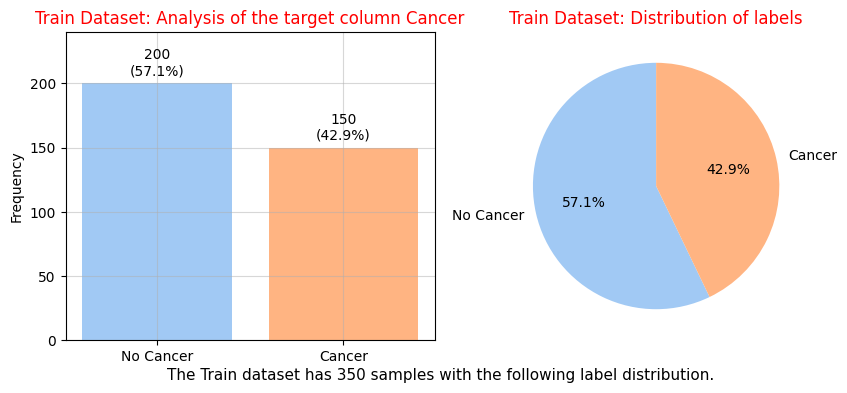

In [82]:
# Sample down for dev
num_class_0,num_class_1 = 200,150 #7000, 1057 # full dataset ===> 1500, 1158
sample_train = create_subset_train(train_data, 'cancer', num_class_0=num_class_0, num_class_1=num_class_1)
print(f'Shape Of Train Sample: {sample_train.shape}')
display(sample_train.head())
print("======="*20)
plot_label_distribution(sample_train,'Train')

Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------
Dimensions of train_data: (233, 9)
Dimensions of valid_data: (117, 9)
Class Cancer: Training instances - 100, Validation instances - 50
Class No Cancer: Training instances - 133, Validation instances - 67
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 15/15 [01:36<00:00,  6.42s/batch, accuracy=60.9, loss=0.0458]


Training metrics for Epoch 1:
Accuracy: 0.6094420600858369
ROC: 0.5971052631578947
Precision: 0.5483870967741935
Recall: 0.51
F1 score: 0.5284974093264249
Train loss: 0.0458
Validating the trained model's performance


Validation 1: 100%|██████████| 8/8 [00:08<00:00,  1.04s/batch, accuracy=53, loss=0.0525]  


Validation metrics for Epoch 1:
Accuracy: 0.5299145299145299
ROC: 0.5667164179104478
Precision: 0.47126436781609193
Recall: 0.82
F1 score: 0.5985401459854015
Validation Loss: 0.0525
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.47      0.82      0.60        50
   No Cancer       0.70      0.31      0.43        67

    accuracy                           0.53       117
   macro avg       0.59      0.57      0.52       117
weighted avg       0.60      0.53      0.50       117



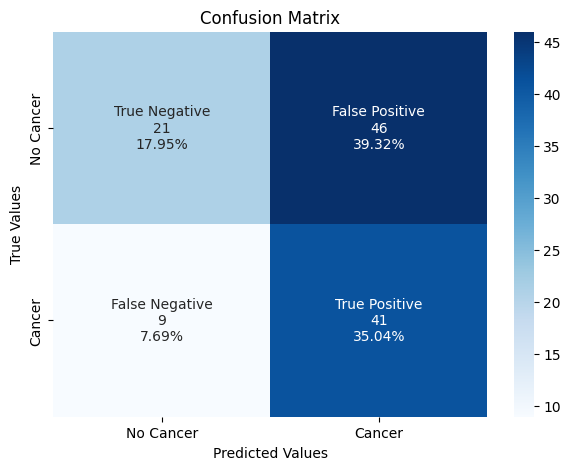

Current Learning Rate: 0.001
Training the model


Epoch 2, Training: 100%|██████████| 15/15 [01:35<00:00,  6.38s/batch, accuracy=75.5, loss=0.0328]


Training metrics for Epoch 2:
Accuracy: 0.7553648068669528
ROC: 0.7559398496240601
Precision: 0.6972477064220184
Recall: 0.76
F1 score: 0.7272727272727273
Train loss: 0.0328
Validating the trained model's performance


Validation 2: 100%|██████████| 8/8 [00:08<00:00,  1.11s/batch, accuracy=53, loss=0.057]   


Validation metrics for Epoch 2:
Accuracy: 0.5299145299145299
ROC: 0.49820895522388065
Precision: 0.42424242424242425
Recall: 0.28
F1 score: 0.3373493975903614
Validation Loss: 0.0570
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.42      0.28      0.34        50
   No Cancer       0.57      0.72      0.64        67

    accuracy                           0.53       117
   macro avg       0.50      0.50      0.49       117
weighted avg       0.51      0.53      0.51       117



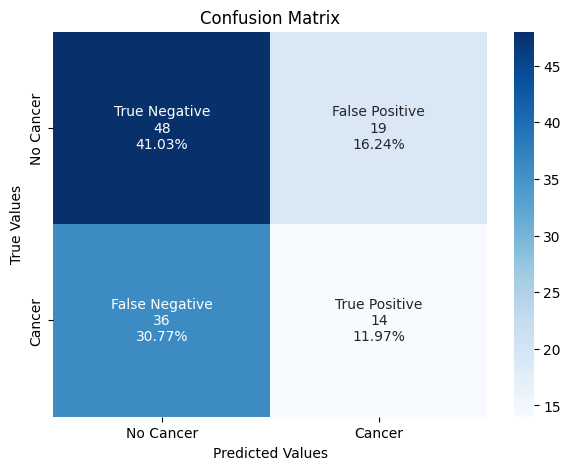

Current Learning Rate: 0.001
Training the model


Epoch 3, Training: 100%|██████████| 15/15 [01:51<00:00,  7.42s/batch, accuracy=87.1, loss=0.0237]


Training metrics for Epoch 3:
Accuracy: 0.871244635193133
ROC: 0.8661278195488722
Precision: 0.8645833333333334
Recall: 0.83
F1 score: 0.8469387755102041
Train loss: 0.0237
Validating the trained model's performance


Validation 3: 100%|██████████| 8/8 [00:09<00:00,  1.15s/batch, accuracy=53.8, loss=0.0771]


Validation metrics for Epoch 3:
Accuracy: 0.5384615384615384
ROC: 0.5183582089552239
Precision: 0.4523809523809524
Recall: 0.38
F1 score: 0.41304347826086957
Validation Loss: 0.0771
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.45      0.38      0.41        50
   No Cancer       0.59      0.66      0.62        67

    accuracy                           0.54       117
   macro avg       0.52      0.52      0.52       117
weighted avg       0.53      0.54      0.53       117



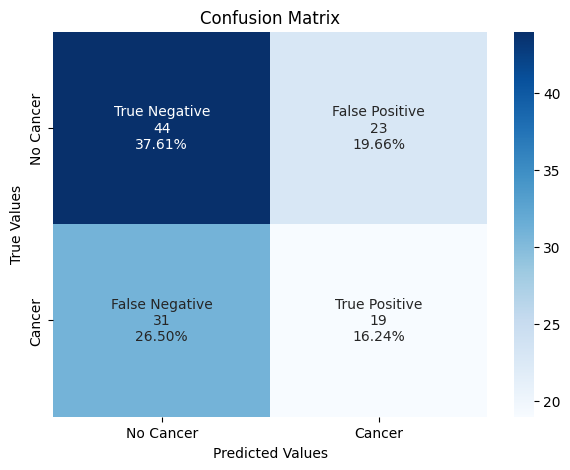

Current Learning Rate: 0.001
Training the model


Epoch 4, Training: 100%|██████████| 15/15 [01:35<00:00,  6.35s/batch, accuracy=91, loss=0.0139]  


Training metrics for Epoch 4:
Accuracy: 0.9098712446351931
ROC: 0.907406015037594
Precision: 0.898989898989899
Recall: 0.89
F1 score: 0.8944723618090452
Train loss: 0.0139
Validating the trained model's performance


Validation 4: 100%|██████████| 8/8 [00:08<00:00,  1.06s/batch, accuracy=53.8, loss=0.186]


Validation metrics for Epoch 4:
Accuracy: 0.5384615384615384
ROC: 0.5031343283582089
Precision: 0.43333333333333335
Recall: 0.26
F1 score: 0.325
Validation Loss: 0.1859
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.43      0.26      0.33        50
   No Cancer       0.57      0.75      0.65        67

    accuracy                           0.54       117
   macro avg       0.50      0.50      0.49       117
weighted avg       0.51      0.54      0.51       117



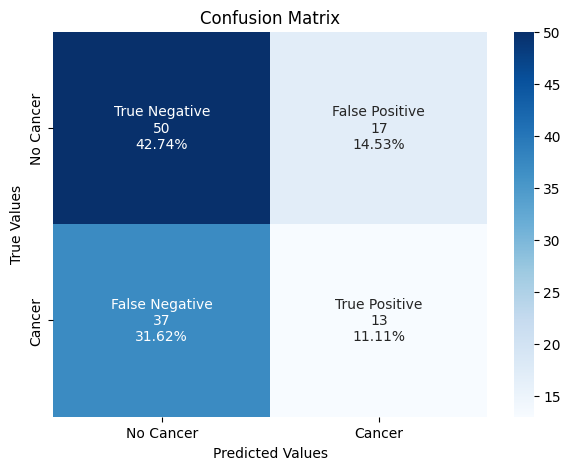

Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.
Current Learning Rate: 0.0001
Early stopping inside the current fold!
Finished Training


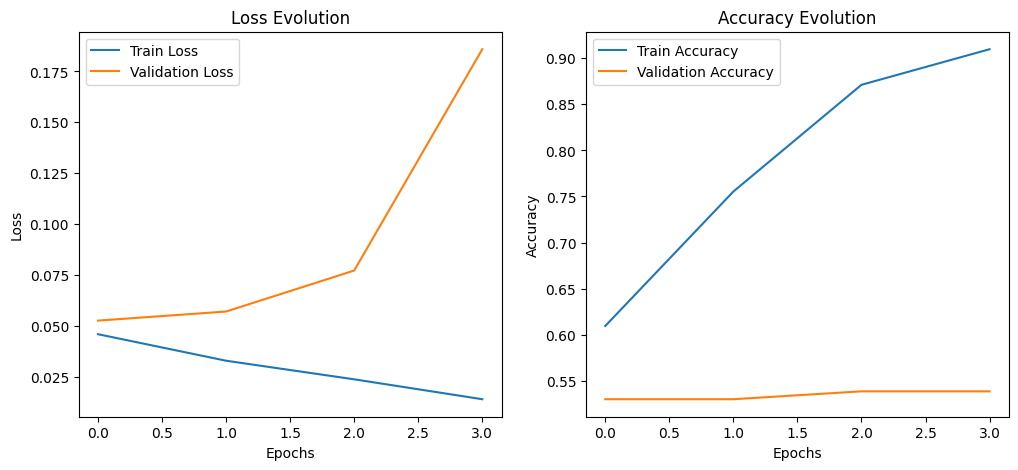

Finished Training for Fold 1
The best model performance in fold 1 - Val Acc: 0.5385 Precision: 0.4333 Recall: 0.2600 F1: 0.5985 ROC: 0.5031
---------- Fold: 2 ----------
Dimensions of train_data: (233, 9)
Dimensions of valid_data: (117, 9)
Class Cancer: Training instances - 100, Validation instances - 50
Class No Cancer: Training instances - 133, Validation instances - 67
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 15/15 [01:33<00:00,  6.25s/batch, accuracy=77.3, loss=0.0411]


Training metrics for Epoch 1:
Accuracy: 0.7725321888412017
ROC: 0.7684962406015038
Precision: 0.7326732673267327
Recall: 0.74
F1 score: 0.7363184079601991
Train loss: 0.0411
Validating the trained model's performance


Validation 1: 100%|██████████| 8/8 [00:08<00:00,  1.02s/batch, accuracy=70.1, loss=0.0662]


Validation metrics for Epoch 1:
Accuracy: 0.7008547008547008
ROC: 0.6550746268656716
Precision: 0.8947368421052632
Recall: 0.34
F1 score: 0.4927536231884058
Validation Loss: 0.0662
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.89      0.34      0.49        50
   No Cancer       0.66      0.97      0.79        67

    accuracy                           0.70       117
   macro avg       0.78      0.66      0.64       117
weighted avg       0.76      0.70      0.66       117



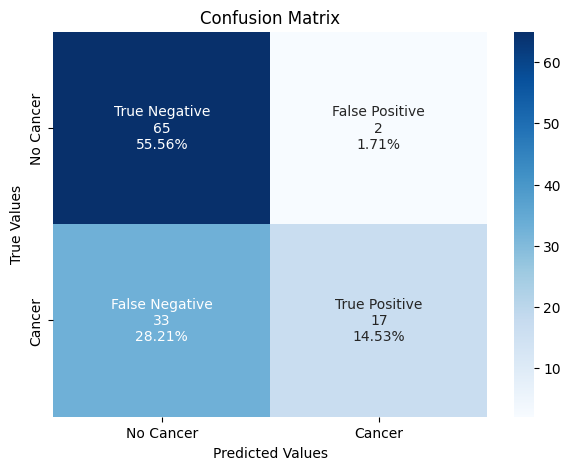

Current Learning Rate: 0.0001
Training the model


Epoch 2, Training: 100%|██████████| 15/15 [01:34<00:00,  6.33s/batch, accuracy=86.7, loss=0.0238]


Training metrics for Epoch 2:
Accuracy: 0.8669527896995708
ROC: 0.8598872180451128
Precision: 0.8709677419354839
Recall: 0.81
F1 score: 0.8393782383419689
Train loss: 0.0238
Validating the trained model's performance


Validation 2: 100%|██████████| 8/8 [00:08<00:00,  1.08s/batch, accuracy=70.1, loss=0.0539]


Validation metrics for Epoch 2:
Accuracy: 0.7008547008547008
ROC: 0.6525373134328358
Precision: 0.9411764705882353
Recall: 0.32
F1 score: 0.4776119402985075
Validation Loss: 0.0539
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.94      0.32      0.48        50
   No Cancer       0.66      0.99      0.79        67

    accuracy                           0.70       117
   macro avg       0.80      0.65      0.63       117
weighted avg       0.78      0.70      0.66       117



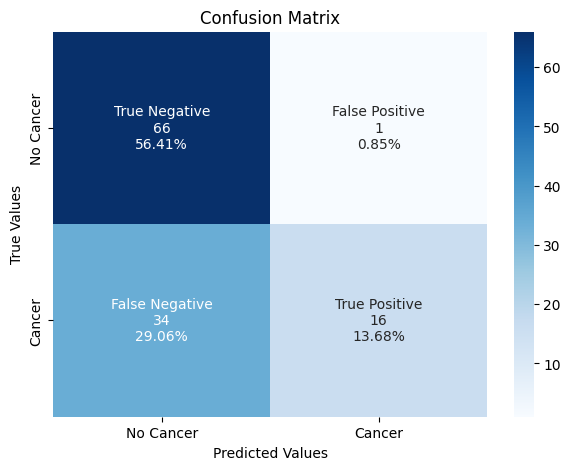

Current Learning Rate: 0.0001
Training the model


Epoch 3, Training: 100%|██████████| 15/15 [01:34<00:00,  6.29s/batch, accuracy=88, loss=0.0165]  


Training metrics for Epoch 3:
Accuracy: 0.8798283261802575
ROC: 0.8748872180451128
Precision: 0.875
Recall: 0.84
F1 score: 0.8571428571428572
Train loss: 0.0165
Validating the trained model's performance


Validation 3: 100%|██████████| 8/8 [00:08<00:00,  1.04s/batch, accuracy=71.8, loss=0.0499]


Validation metrics for Epoch 3:
Accuracy: 0.717948717948718
ROC: 0.6725373134328357
Precision: 0.9473684210526315
Recall: 0.36
F1 score: 0.5217391304347826
Validation Loss: 0.0499
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.95      0.36      0.52        50
   No Cancer       0.67      0.99      0.80        67

    accuracy                           0.72       117
   macro avg       0.81      0.67      0.66       117
weighted avg       0.79      0.72      0.68       117



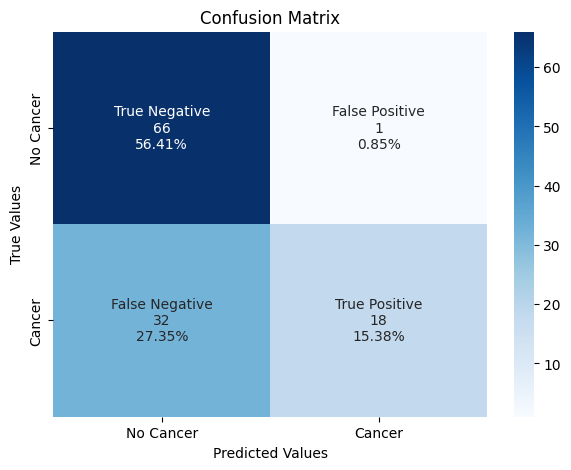

Current Learning Rate: 0.0001
Training the model


Epoch 4, Training: 100%|██████████| 15/15 [01:35<00:00,  6.34s/batch, accuracy=90.1, loss=0.0151]


Training metrics for Epoch 4:
Accuracy: 0.9012875536480687
ROC: 0.8936842105263157
Precision: 0.9230769230769231
Recall: 0.84
F1 score: 0.8795811518324608
Train loss: 0.0151
Validating the trained model's performance


Validation 4: 100%|██████████| 8/8 [00:14<00:00,  1.87s/batch, accuracy=72.6, loss=0.0484]


Validation metrics for Epoch 4:
Accuracy: 0.7264957264957265
ROC: 0.6825373134328357
Precision: 0.95
Recall: 0.38
F1 score: 0.5428571428571428
Validation Loss: 0.0484
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.95      0.38      0.54        50
   No Cancer       0.68      0.99      0.80        67

    accuracy                           0.73       117
   macro avg       0.82      0.68      0.67       117
weighted avg       0.80      0.73      0.69       117



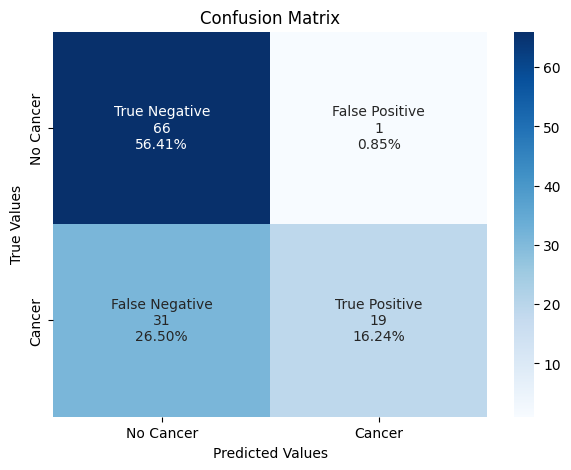

Current Learning Rate: 0.0001
Training the model


Epoch 5, Training: 100%|██████████| 15/15 [01:42<00:00,  6.81s/batch, accuracy=92.3, loss=0.0135]


Training metrics for Epoch 5:
Accuracy: 0.9227467811158798
ROC: 0.9162030075187969
Precision: 0.9456521739130435
Recall: 0.87
F1 score: 0.90625
Train loss: 0.0135
Validating the trained model's performance


Validation 5: 100%|██████████| 8/8 [00:09<00:00,  1.22s/batch, accuracy=71.8, loss=0.0486]


Validation metrics for Epoch 5:
Accuracy: 0.717948717948718
ROC: 0.6750746268656715
Precision: 0.9047619047619048
Recall: 0.38
F1 score: 0.5352112676056339
Validation Loss: 0.0486
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.90      0.38      0.54        50
   No Cancer       0.68      0.97      0.80        67

    accuracy                           0.72       117
   macro avg       0.79      0.68      0.67       117
weighted avg       0.77      0.72      0.69       117



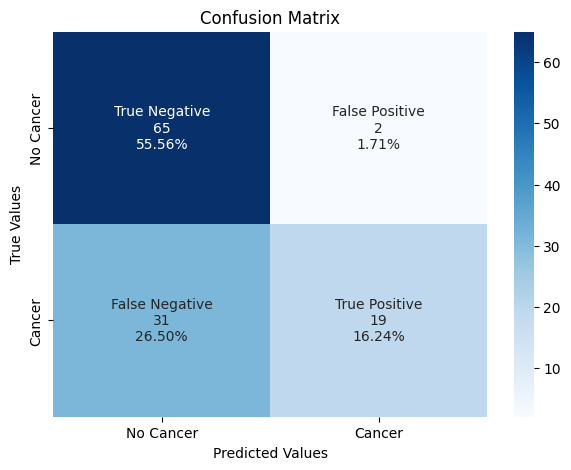

Current Learning Rate: 0.0001
Training the model


Epoch 6, Training: 100%|██████████| 15/15 [01:35<00:00,  6.36s/batch, accuracy=96.1, loss=0.00898]


Training metrics for Epoch 6:
Accuracy: 0.9613733905579399
ROC: 0.9587218045112782
Precision: 0.9690721649484536
Recall: 0.94
F1 score: 0.9543147208121826
Train loss: 0.0090
Validating the trained model's performance


Validation 6: 100%|██████████| 8/8 [00:08<00:00,  1.04s/batch, accuracy=70.9, loss=0.0499]


Validation metrics for Epoch 6:
Accuracy: 0.7094017094017094
ROC: 0.6650746268656715
Precision: 0.9
Recall: 0.36
F1 score: 0.5142857142857143
Validation Loss: 0.0499
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.90      0.36      0.51        50
   No Cancer       0.67      0.97      0.79        67

    accuracy                           0.71       117
   macro avg       0.79      0.67      0.65       117
weighted avg       0.77      0.71      0.67       117



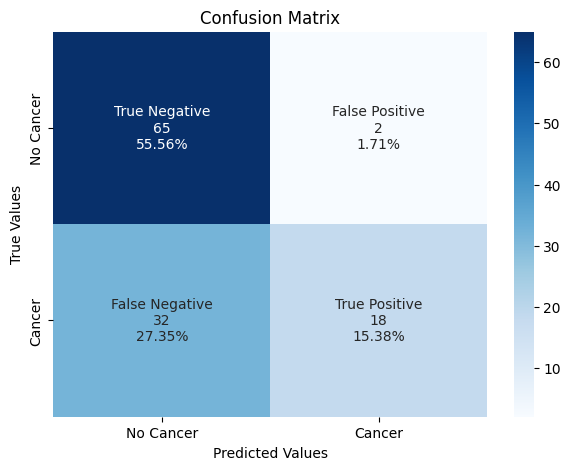

Current Learning Rate: 0.0001
Training the model


Epoch 7, Training: 100%|██████████| 15/15 [01:36<00:00,  6.41s/batch, accuracy=96.1, loss=0.00721]


Training metrics for Epoch 7:
Accuracy: 0.9613733905579399
ROC: 0.9574812030075189
Precision: 0.9789473684210527
Recall: 0.93
F1 score: 0.9538461538461539
Train loss: 0.0072
Validating the trained model's performance


Validation 7: 100%|██████████| 8/8 [00:08<00:00,  1.04s/batch, accuracy=70.1, loss=0.0542]


Validation metrics for Epoch 7:
Accuracy: 0.7008547008547008
ROC: 0.6525373134328358
Precision: 0.9411764705882353
Recall: 0.32
F1 score: 0.4776119402985075
Validation Loss: 0.0542
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.94      0.32      0.48        50
   No Cancer       0.66      0.99      0.79        67

    accuracy                           0.70       117
   macro avg       0.80      0.65      0.63       117
weighted avg       0.78      0.70      0.66       117



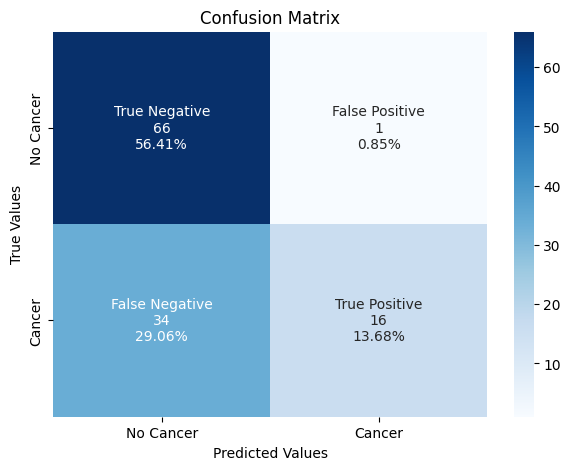

Epoch 00011: reducing learning rate of group 0 to 1.0000e-05.
Current Learning Rate: 1e-05
Early stopping inside the current fold!
Finished Training


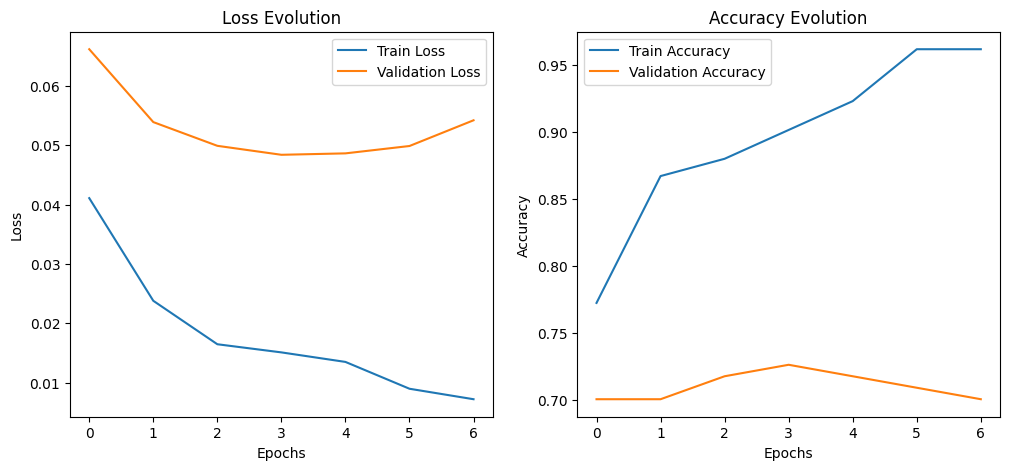

Finished Training for Fold 2
The best model performance in fold 2 - Val Acc: 0.7009 Precision: 0.9412 Recall: 0.3200 F1: 0.5429 ROC: 0.6525
---------- Fold: 3 ----------
Dimensions of train_data: (234, 9)
Dimensions of valid_data: (116, 9)
Class Cancer: Training instances - 100, Validation instances - 50
Class No Cancer: Training instances - 134, Validation instances - 66
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 15/15 [01:36<00:00,  6.42s/batch, accuracy=94.4, loss=0.00952]


Training metrics for Epoch 1:
Accuracy: 0.9444444444444444
ROC: 0.9400746268656718
Precision: 0.9578947368421052
Recall: 0.91
F1 score: 0.9333333333333333
Train loss: 0.0095
Validating the trained model's performance


Validation 1: 100%|██████████| 8/8 [00:08<00:00,  1.05s/batch, accuracy=77.6, loss=0.0359]


Validation metrics for Epoch 1:
Accuracy: 0.7758620689655172
ROC: 0.74
Precision: 1.0
Recall: 0.48
F1 score: 0.6486486486486487
Validation Loss: 0.0359
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      0.48      0.65        50
   No Cancer       0.72      1.00      0.84        66

    accuracy                           0.78       116
   macro avg       0.86      0.74      0.74       116
weighted avg       0.84      0.78      0.75       116



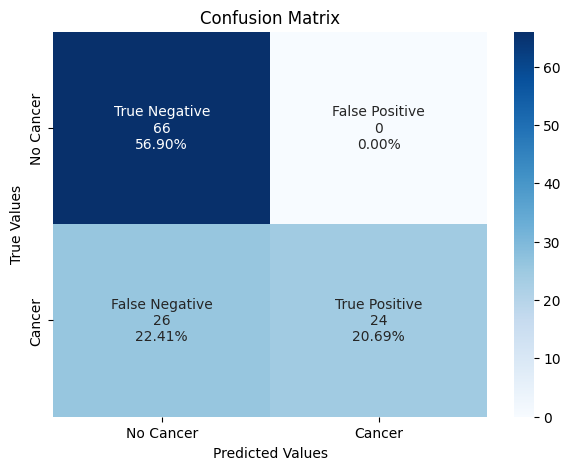

Current Learning Rate: 1e-05
Training the model


Epoch 2, Training: 100%|██████████| 15/15 [01:38<00:00,  6.57s/batch, accuracy=95.3, loss=0.0075] 


Training metrics for Epoch 2:
Accuracy: 0.9529914529914529
ROC: 0.9500746268656718
Precision: 0.9587628865979382
Recall: 0.93
F1 score: 0.9441624365482233
Train loss: 0.0075
Validating the trained model's performance


Validation 2: 100%|██████████| 8/8 [00:08<00:00,  1.06s/batch, accuracy=77.6, loss=0.0324]


Validation metrics for Epoch 2:
Accuracy: 0.7758620689655172
ROC: 0.74
Precision: 1.0
Recall: 0.48
F1 score: 0.6486486486486487
Validation Loss: 0.0324
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      0.48      0.65        50
   No Cancer       0.72      1.00      0.84        66

    accuracy                           0.78       116
   macro avg       0.86      0.74      0.74       116
weighted avg       0.84      0.78      0.75       116



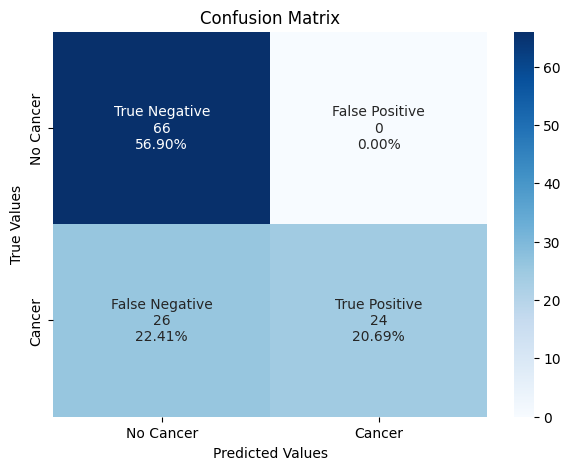

Current Learning Rate: 1e-05
Training the model


Epoch 3, Training: 100%|██████████| 15/15 [01:45<00:00,  7.05s/batch, accuracy=95.3, loss=0.0108] 


Training metrics for Epoch 3:
Accuracy: 0.9529914529914529
ROC: 0.9475373134328358
Precision: 0.978494623655914
Recall: 0.91
F1 score: 0.9430051813471503
Train loss: 0.0108
Validating the trained model's performance


Validation 3: 100%|██████████| 8/8 [00:13<00:00,  1.72s/batch, accuracy=77.6, loss=0.0292]


Validation metrics for Epoch 3:
Accuracy: 0.7758620689655172
ROC: 0.74
Precision: 1.0
Recall: 0.48
F1 score: 0.6486486486486487
Validation Loss: 0.0292
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      0.48      0.65        50
   No Cancer       0.72      1.00      0.84        66

    accuracy                           0.78       116
   macro avg       0.86      0.74      0.74       116
weighted avg       0.84      0.78      0.75       116



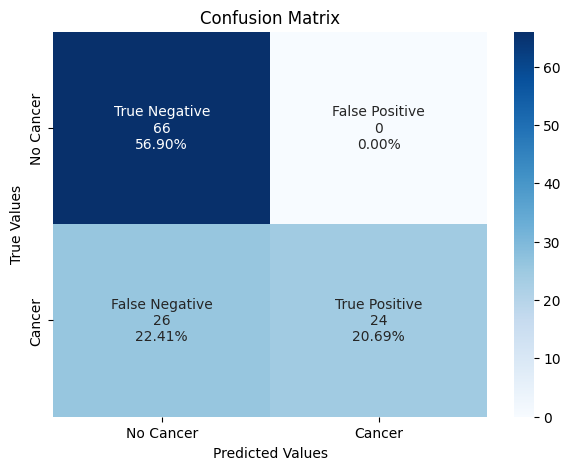

Current Learning Rate: 1e-05
Training the model


Epoch 4, Training: 100%|██████████| 15/15 [01:40<00:00,  6.70s/batch, accuracy=95.7, loss=0.00865]


Training metrics for Epoch 4:
Accuracy: 0.9572649572649573
ROC: 0.9538059701492538
Precision: 0.96875
Recall: 0.93
F1 score: 0.9489795918367346
Train loss: 0.0086
Validating the trained model's performance


Validation 4: 100%|██████████| 8/8 [00:08<00:00,  1.07s/batch, accuracy=80.2, loss=0.0265]


Validation metrics for Epoch 4:
Accuracy: 0.8017241379310345
ROC: 0.77
Precision: 1.0
Recall: 0.54
F1 score: 0.7012987012987013
Validation Loss: 0.0265
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      0.54      0.70        50
   No Cancer       0.74      1.00      0.85        66

    accuracy                           0.80       116
   macro avg       0.87      0.77      0.78       116
weighted avg       0.85      0.80      0.79       116



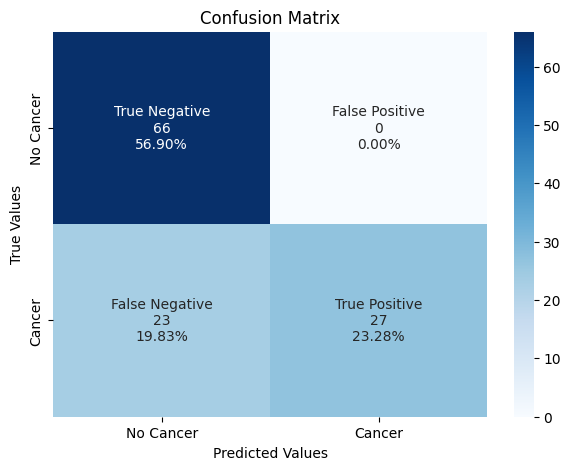

Current Learning Rate: 1e-05
Training the model


Epoch 5, Training:   7%|▋         | 1/15 [00:10<02:24, 10.33s/batch, accuracy=93.8, loss=0.00667]

In [ ]:
# Configuration des hyperparamètres
hyperparameters = {
    "folds": 3,  # Nombre de folds pour la validation croisée
    "num_workers": 2,  # Nombre de workers pour le DataLoader
    "val_batch_size": 16,  # Taille du batch pour la validation
    "train_batch_size": 16,  # Taille du batch pour l'entraînement
    "learning_rate": 0.001,  # Taux d'apprentissage
    "num_epochs": 10,  # Nombre d'époques pour l'entraînement
    "early_stopping_patience": 3,  # Patience pour l'arrêt anticipé
    'save_best_model_dir': save_best_model_dir
}

# Initialisation du modèle
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)  # Modèle sur le dispositif approprié

version = '1.0.0'

Train_Model_Applying_k_Fold_Cross_Validation(model,sample_train,hyperparameters)

Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------
Dimensions of train_data: (6523, 10)
Dimensions of valid_data: (3262, 10)
Class Cancer: Training instances - 3523, Validation instances - 1762
Class No Cancer: Training instances - 3000, Validation instances - 1500
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Loaded pretrained weights for efficientnet-b2
Training the model


Epoch 1, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=57.2, loss=0.00851]


Training metrics for Epoch 1:
Accuracy: 0.5721293883182584
ROC: 0.5790723341848802
Precision: 0.6336742147552958
Recall: 0.49247800170309397
F1 score: 0.5542245647660119
Train loss: 0.0085
Validating the trained model's performance


Validation 1: 100%|██████████| 102/102 [00:06<00:00, 14.87batch/s, accuracy=60.7, loss=0.0211]


Validation metrics for Epoch 1:
Accuracy: 0.6069895769466584
ROC: 0.6011664774877034
Precision: 0.6267159450897571
Recall: 0.6736662883087401
F1 score: 0.649343544857768
Validation Loss: 0.0211
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.63      0.67      0.65      1762
   No Cancer       0.58      0.53      0.55      1500

    accuracy                           0.61      3262
   macro avg       0.60      0.60      0.60      3262
weighted avg       0.61      0.61      0.61      3262



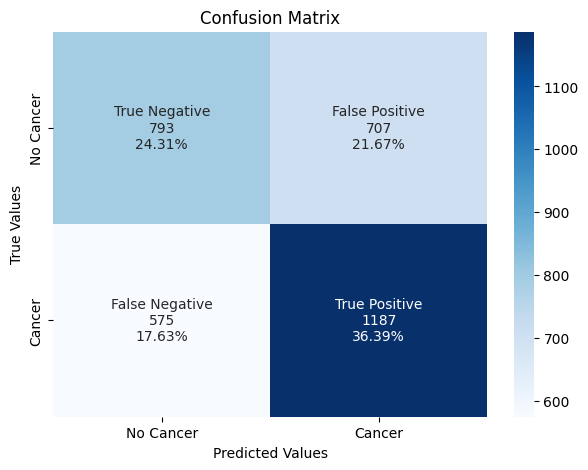

Current Learning Rate: 0.001
Training the model


Epoch 2, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=57.3, loss=0.0085] 


Training metrics for Epoch 2:
Accuracy: 0.5733558178752108
ROC: 0.5807273157346958
Precision: 0.6368343195266272
Recall: 0.48878796480272496
F1 score: 0.5530753171671752
Train loss: 0.0085
Validating the trained model's performance


Validation 2: 100%|██████████| 102/102 [00:06<00:00, 14.87batch/s, accuracy=59.9, loss=0.0211]


Validation metrics for Epoch 2:
Accuracy: 0.5990190067443286
ROC: 0.5831320469163829
Precision: 0.598781549173194
Recall: 0.7809307604994324
F1 score: 0.6778325123152709
Validation Loss: 0.0211
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.60      0.78      0.68      1762
   No Cancer       0.60      0.39      0.47      1500

    accuracy                           0.60      3262
   macro avg       0.60      0.58      0.57      3262
weighted avg       0.60      0.60      0.58      3262



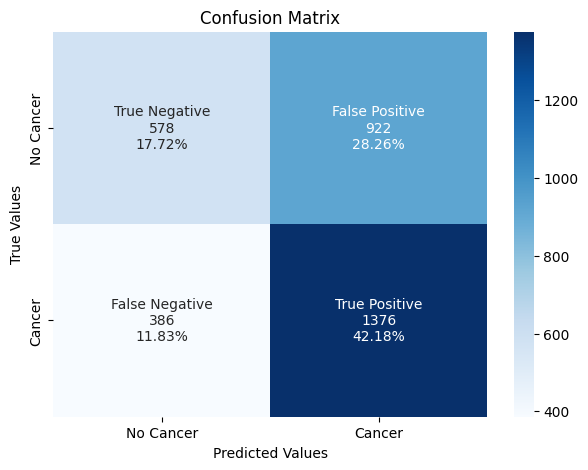

Current Learning Rate: 0.001
Training the model


Epoch 3, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=57.7, loss=0.00852]


Training metrics for Epoch 3:
Accuracy: 0.5770351065460677
ROC: 0.5837623710852492
Precision: 0.6385061638868745
Recall: 0.499858075503832
F1 score: 0.5607387358700844
Train loss: 0.0085
Validating the trained model's performance


Validation 3: 100%|██████████| 102/102 [00:06<00:00, 14.63batch/s, accuracy=59.7, loss=0.021]


Validation metrics for Epoch 3:
Accuracy: 0.5971796443899449
ROC: 0.5800911842603103
Precision: 0.5954816709292413
Recall: 0.7928490351872872
F1 score: 0.6801363193768257
Validation Loss: 0.0210
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.60      0.79      0.68      1762
   No Cancer       0.60      0.37      0.46      1500

    accuracy                           0.60      3262
   macro avg       0.60      0.58      0.57      3262
weighted avg       0.60      0.60      0.58      3262



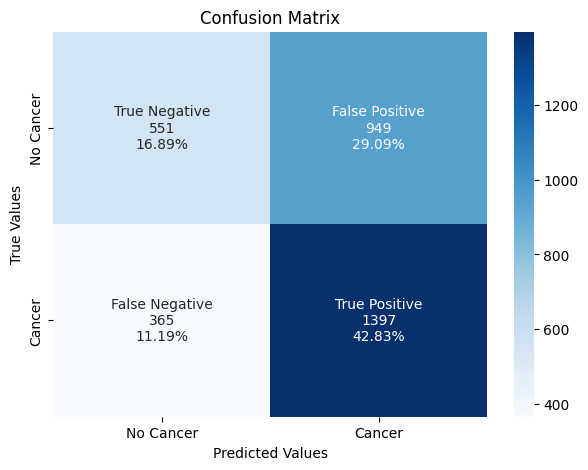

Current Learning Rate: 0.001
Training the model


Epoch 4, Training:  37%|███▋      | 30/82 [00:16<00:28,  1.86batch/s, accuracy=56.8, loss=0.0085] 


KeyboardInterrupt: 

In [64]:
# Configuration des hyperparamètres
hyperparameters = {
    "folds": 3,  # Nombre de folds pour la validation croisée
    "num_workers": 2,  # Nombre de workers pour le DataLoader
    "val_batch_size": 16,  # Taille du batch pour la validation
    "train_batch_size": 16,  # Taille du batch pour l'entraînement
    "learning_rate": 0.001,  # Taux d'apprentissage
    "num_epochs": 20,  # Nombre d'époques pour l'entraînement
    "early_stopping_patience": 3,  # Patience pour l'arrêt anticipé
    'save_best_model_dir': save_best_model_dir
}

# Initialisation du modèle
model = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE) # Modèle sur le dispositif approprié

version = '2.0.0'

Train_Model_Applying_k_Fold_Cross_Validation(model,processed_df,hyperparameters)

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet

class OptimizedEffNetNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = EfficientNet.from_pretrained('efficientnet-b2')
        
        # (CSV)
        self.csv = nn.Sequential(
            nn.Linear(self.no_columns, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        
        # Define Classification part
        self.classification = nn.Sequential(
            nn.Linear(1408 + 256, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(1024, self.output_size)
        )
        
    def forward(self, image, meta, prints=False):
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features.extract_features(image)
        image = F.adaptive_avg_pool2d(image, 1).reshape(-1, 1408)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data shape:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data shape:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Output shape:', out.shape)
        
        return out

Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------
Dimensions of train_data: (6523, 10)
Dimensions of valid_data: (3262, 10)
Class Cancer: Training instances - 3523, Validation instances - 1762
Class No Cancer: Training instances - 3000, Validation instances - 1500
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=74.2, loss=0.00603]


Training metrics for Epoch 1:
Accuracy: 0.7419898819561551
ROC: 0.7485225659948906
Precision: 0.8216783216783217
Recall: 0.6670451319897814
F1 score: 0.7363308788970703
Train loss: 0.0060
Validating the trained model's performance


Validation 1: 100%|██████████| 102/102 [00:06<00:00, 14.85batch/s, accuracy=73.6, loss=0.0181]


Validation metrics for Epoch 1:
Accuracy: 0.7357449417535254
ROC: 0.7501872871736662
Precision: 0.9054054054054054
Recall: 0.5703745743473326
F1 score: 0.6998607242339833
Validation Loss: 0.0181
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.91      0.57      0.70      1762
   No Cancer       0.65      0.93      0.76      1500

    accuracy                           0.74      3262
   macro avg       0.78      0.75      0.73      3262
weighted avg       0.79      0.74      0.73      3262



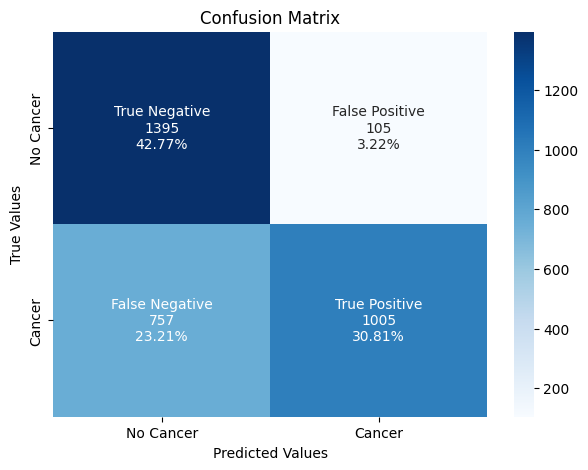

Current Learning Rate: 0.001
Training the model


Epoch 2, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=80.6, loss=0.00498]


Training metrics for Epoch 2:
Accuracy: 0.8057642189176759
ROC: 0.8117198410445643
Precision: 0.8836734693877552
Recall: 0.7374396820891286
F1 score: 0.8039610088194337
Train loss: 0.0050
Validating the trained model's performance


Validation 2: 100%|██████████| 102/102 [00:06<00:00, 14.98batch/s, accuracy=80, loss=0.0171] 


Validation metrics for Epoch 2:
Accuracy: 0.7998160637645616
ROC: 0.8061740446462353
Precision: 0.8816242257398486
Recall: 0.7270147559591373
F1 score: 0.7968895800933126
Validation Loss: 0.0171
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.88      0.73      0.80      1762
   No Cancer       0.73      0.89      0.80      1500

    accuracy                           0.80      3262
   macro avg       0.81      0.81      0.80      3262
weighted avg       0.81      0.80      0.80      3262



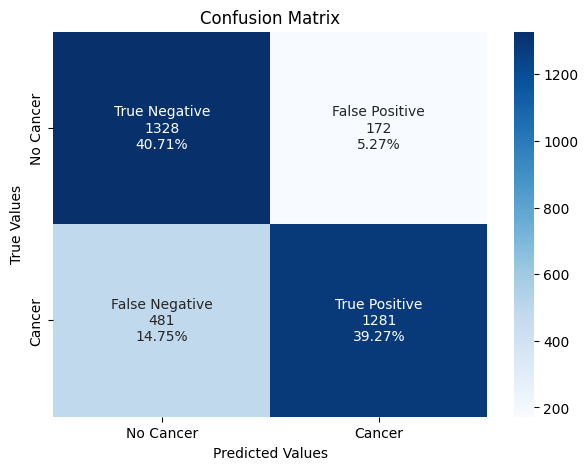

Current Learning Rate: 0.001
Training the model


Epoch 3, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=84.3, loss=0.0043] 


Training metrics for Epoch 3:
Accuracy: 0.8434769277939599
ROC: 0.8472023370233702
Precision: 0.8984076433121019
Recall: 0.8007380073800738
F1 score: 0.8467657211466305
Train loss: 0.0043
Validating the trained model's performance


Validation 3: 100%|██████████| 102/102 [00:06<00:00, 14.95batch/s, accuracy=67.6, loss=0.0508]


Validation metrics for Epoch 3:
Accuracy: 0.6759656652360515
ROC: 0.657579644343549
Precision: 0.645721372467962
Recall: 0.8864926220204313
F1 score: 0.7471896675436498
Validation Loss: 0.0508
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.65      0.89      0.75      1762
   No Cancer       0.76      0.43      0.55      1500

    accuracy                           0.68      3262
   macro avg       0.70      0.66      0.65      3262
weighted avg       0.70      0.68      0.66      3262



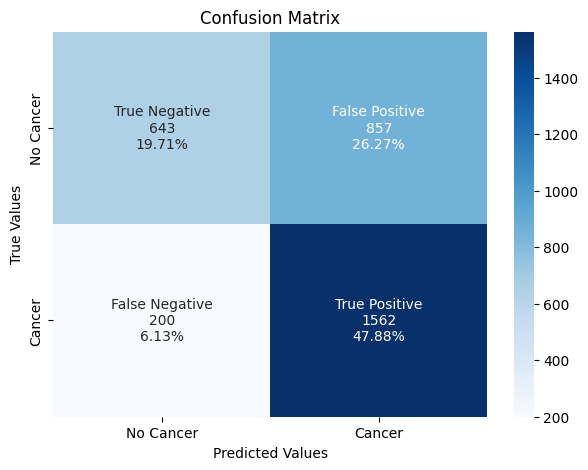

Current Learning Rate: 0.001
Training the model


Epoch 4, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=86.7, loss=0.00355]


Training metrics for Epoch 4:
Accuracy: 0.866932393070673
ROC: 0.8696590500520388
Precision: 0.9106093411691927
Recall: 0.8356514334374113
F1 score: 0.871521610420367
Train loss: 0.0036
Validating the trained model's performance


Validation 4: 100%|██████████| 102/102 [00:06<00:00, 14.94batch/s, accuracy=80.5, loss=0.0204]


Validation metrics for Epoch 4:
Accuracy: 0.8050275904353158
ROC: 0.812683314415437
Precision: 0.9015691868758916
Recall: 0.717366628830874
F1 score: 0.7989886219974716
Validation Loss: 0.0204
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.90      0.72      0.80      1762
   No Cancer       0.73      0.91      0.81      1500

    accuracy                           0.81      3262
   macro avg       0.82      0.81      0.80      3262
weighted avg       0.82      0.81      0.80      3262



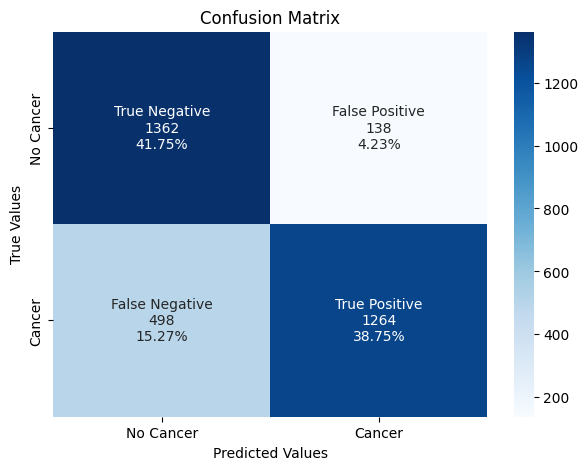

Current Learning Rate: 0.001
Training the model


Epoch 5, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=89, loss=0.00324]  


Training metrics for Epoch 5:
Accuracy: 0.8899279472635291
ROC: 0.8916899895922035
Precision: 0.9220583809810412
Recall: 0.8697133125177405
F1 score: 0.8951212386795209
Train loss: 0.0032
Validating the trained model's performance


Validation 5: 100%|██████████| 102/102 [00:06<00:00, 14.93batch/s, accuracy=81.1, loss=0.0158]


Validation metrics for Epoch 5:
Accuracy: 0.8108522378908645
ROC: 0.8111853953840333
Precision: 0.836962919364332
Recall: 0.8070374574347332
F1 score: 0.8217278243282288
Validation Loss: 0.0158
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.84      0.81      0.82      1762
   No Cancer       0.78      0.82      0.80      1500

    accuracy                           0.81      3262
   macro avg       0.81      0.81      0.81      3262
weighted avg       0.81      0.81      0.81      3262



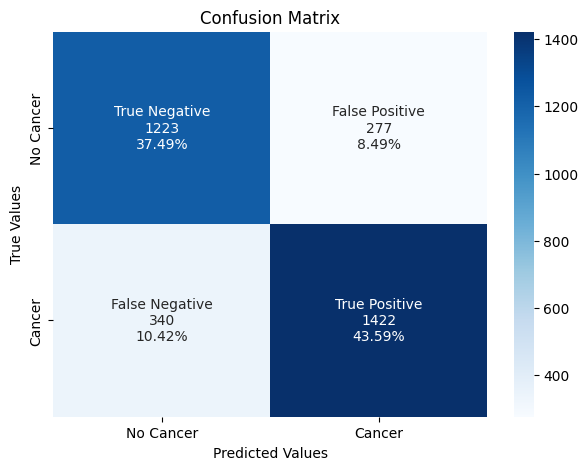

Current Learning Rate: 0.001
Training the model


Epoch 6, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=92.9, loss=0.00227]


Training metrics for Epoch 6:
Accuracy: 0.9293269967806224
ROC: 0.9296985996783045
Precision: 0.9429976851851852
Recall: 0.9250638660232756
F1 score: 0.9339446912165067
Train loss: 0.0023
Validating the trained model's performance


Validation 6: 100%|██████████| 102/102 [00:06<00:00, 14.89batch/s, accuracy=83.1, loss=0.0169]


Validation metrics for Epoch 6:
Accuracy: 0.8307786633966892
ROC: 0.8391963677639046
Precision: 0.9390420899854862
Recall: 0.7343927355278093
F1 score: 0.824203821656051
Validation Loss: 0.0169
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.94      0.73      0.82      1762
   No Cancer       0.75      0.94      0.84      1500

    accuracy                           0.83      3262
   macro avg       0.85      0.84      0.83      3262
weighted avg       0.85      0.83      0.83      3262



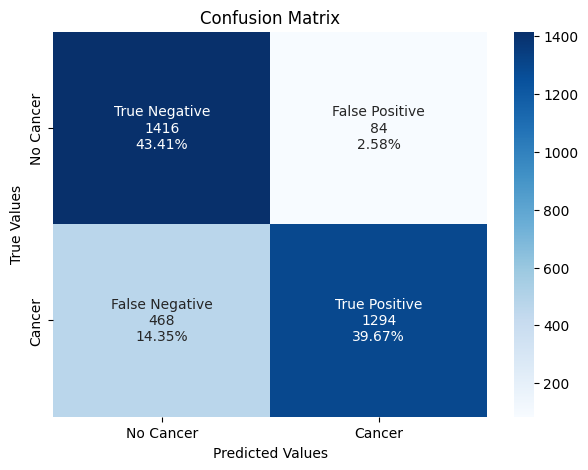

Current Learning Rate: 0.001
Training the model


Epoch 7, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=94.9, loss=0.00163]


Training metrics for Epoch 7:
Accuracy: 0.9494097807757167
ROC: 0.9497010123947394
Precision: 0.9596890296573568
Recall: 0.9460686914561454
F1 score: 0.9528301886792453
Train loss: 0.0016
Validating the trained model's performance


Validation 7: 100%|██████████| 102/102 [00:06<00:00, 14.93batch/s, accuracy=83.3, loss=0.016]


Validation metrics for Epoch 7:
Accuracy: 0.8326180257510729
ROC: 0.8388172531214528
Precision: 0.9141689373297003
Recall: 0.7616345062429057
F1 score: 0.8309597523219814
Validation Loss: 0.0160
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.91      0.76      0.83      1762
   No Cancer       0.77      0.92      0.83      1500

    accuracy                           0.83      3262
   macro avg       0.84      0.84      0.83      3262
weighted avg       0.85      0.83      0.83      3262



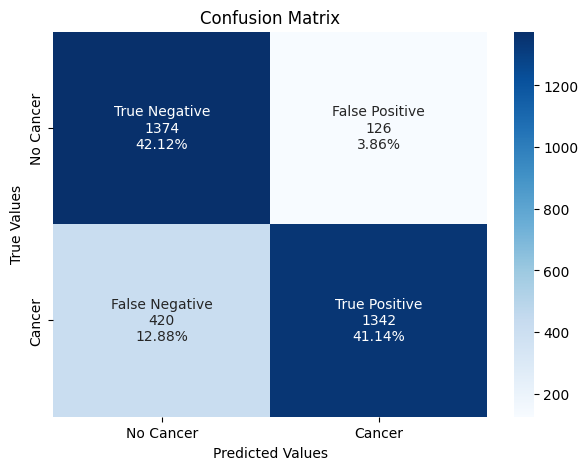

Current Learning Rate: 0.001
Training the model


Epoch 8, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=95.6, loss=0.0015] 


Training metrics for Epoch 8:
Accuracy: 0.9560018396443354
ROC: 0.9561996404579431
Precision: 0.9644087256027555
Recall: 0.9537326142492194
F1 score: 0.959040959040959
Train loss: 0.0015
Validating the trained model's performance


Validation 8: 100%|██████████| 102/102 [00:06<00:00, 14.93batch/s, accuracy=75.2, loss=0.0519]


Validation metrics for Epoch 8:
Accuracy: 0.7522992029429798
ROC: 0.7389440030268635
Precision: 0.7133273703041145
Recall: 0.9052213393870602
F1 score: 0.7978989494747374
Validation Loss: 0.0519
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.71      0.91      0.80      1762
   No Cancer       0.84      0.57      0.68      1500

    accuracy                           0.75      3262
   macro avg       0.78      0.74      0.74      3262
weighted avg       0.77      0.75      0.74      3262



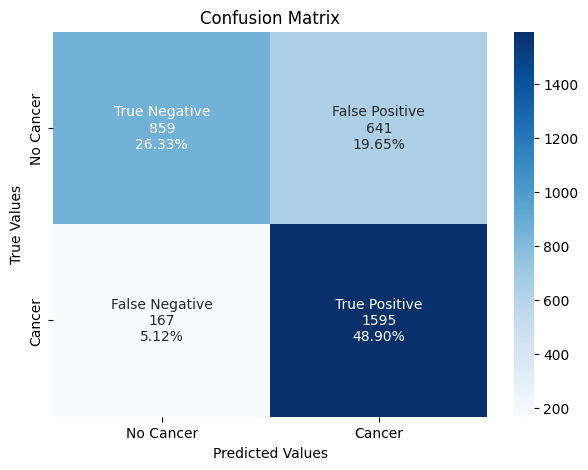

Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Current Learning Rate: 0.0001
Training the model


Epoch 9, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=97.9, loss=0.000797]


Training metrics for Epoch 9:
Accuracy: 0.9791506975318105
ROC: 0.979411675655218
Precision: 0.9851045545688915
Recall: 0.9761566846437695
F1 score: 0.9806102081551183
Train loss: 0.0008
Validating the trained model's performance


Validation 9: 100%|██████████| 102/102 [00:06<00:00, 14.97batch/s, accuracy=73.6, loss=0.0509]


Validation metrics for Epoch 9:
Accuracy: 0.7357449417535254
ROC: 0.7165327279606508
Precision: 0.6823338735818476
Recall: 0.9557321225879682
F1 score: 0.7962174940898346
Validation Loss: 0.0509
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.68      0.96      0.80      1762
   No Cancer       0.90      0.48      0.62      1500

    accuracy                           0.74      3262
   macro avg       0.79      0.72      0.71      3262
weighted avg       0.78      0.74      0.72      3262



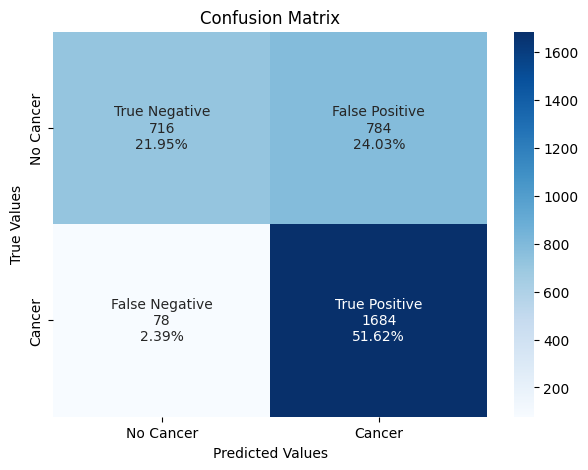

Current Learning Rate: 0.0001
Training the model


Epoch 10, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=99.4, loss=0.000269]


Training metrics for Epoch 10:
Accuracy: 0.9943277632990956
ROC: 0.9943776610843031
Precision: 0.9957337883959044
Recall: 0.9937553221686063
F1 score: 0.9947435715300469
Train loss: 0.0003
Validating the trained model's performance


Validation 10: 100%|██████████| 102/102 [00:06<00:00, 15.02batch/s, accuracy=86.5, loss=0.0175]


Validation metrics for Epoch 10:
Accuracy: 0.8654199877375843
ROC: 0.8654631101021567
Precision: 0.8834782608695653
Recall: 0.8649262202043133
F1 score: 0.8741038141669056
Validation Loss: 0.0175
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.88      0.86      0.87      1762
   No Cancer       0.85      0.87      0.86      1500

    accuracy                           0.87      3262
   macro avg       0.86      0.87      0.86      3262
weighted avg       0.87      0.87      0.87      3262



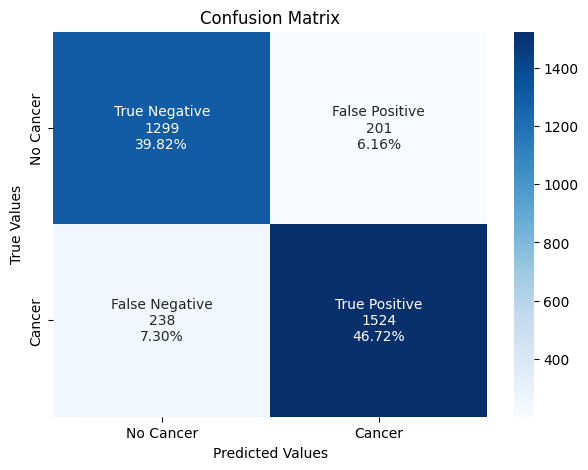

Current Learning Rate: 0.0001
Finished Training


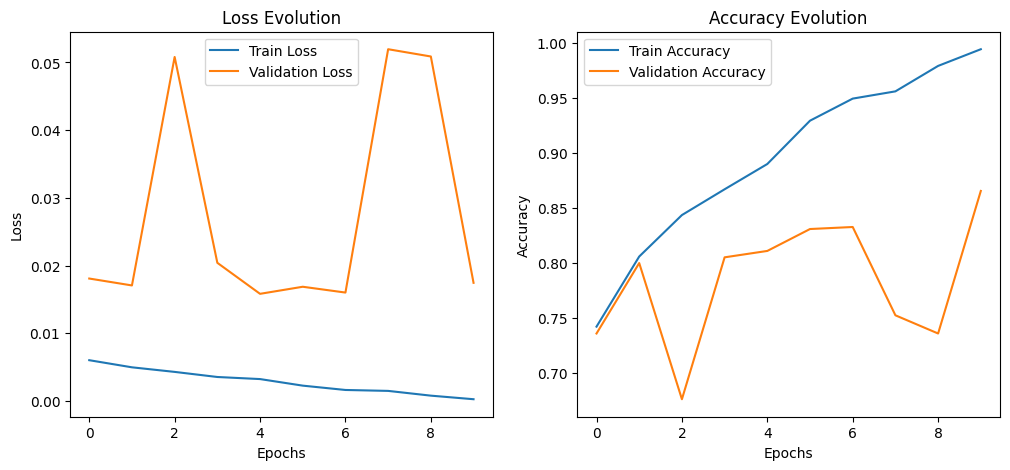

Finished Training for Fold 1
The best model performance in fold 1 - Val Acc: 0.8654 Precision: 0.8835 Recall: 0.8649 F1: 0.8741 ROC: 0.8655
---------- Fold: 2 ----------
Dimensions of train_data: (6523, 10)
Dimensions of valid_data: (3262, 10)
Class Cancer: Training instances - 3523, Validation instances - 1762
Class No Cancer: Training instances - 3000, Validation instances - 1500
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Training the model


Epoch 1, Training: 100%|██████████| 82/82 [00:42<00:00,  1.91batch/s, accuracy=92.9, loss=0.00282]


Training metrics for Epoch 1:
Accuracy: 0.9285604783075272
ROC: 0.9296570158009272
Precision: 0.9499558433912275
Recall: 0.9159806982685211
F1 score: 0.9326589595375722
Train loss: 0.0028
Validating the trained model's performance


Validation 1: 100%|██████████| 102/102 [00:06<00:00, 14.74batch/s, accuracy=99.1, loss=0.00158]


Validation metrics for Epoch 1:
Accuracy: 0.9914163090128756
ROC: 0.9920544835414302
Precision: 1.0
Recall: 0.9841089670828603
F1 score: 0.9919908466819222
Validation Loss: 0.0016
+++++++++ Confusion Matrix for Validation Dataset +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       1.00      0.98      0.99      1762
   No Cancer       0.98      1.00      0.99      1500

    accuracy                           0.99      3262
   macro avg       0.99      0.99      0.99      3262
weighted avg       0.99      0.99      0.99      3262



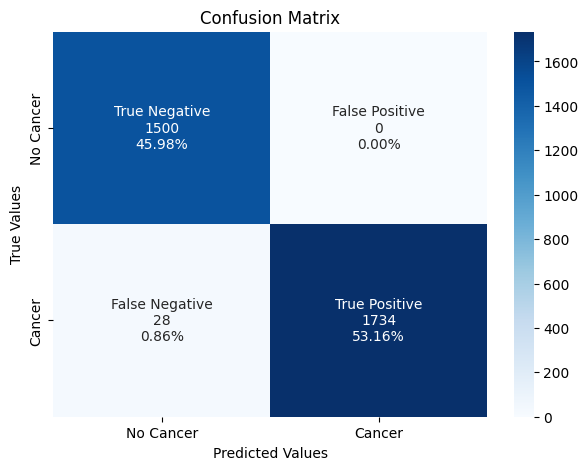

Current Learning Rate: 0.0001
Training the model


Epoch 2, Training:  46%|████▋     | 38/82 [00:20<00:23,  1.84batch/s, accuracy=95.6, loss=0.00172]


KeyboardInterrupt: 

In [48]:
# Configuration des hyperparamètres
hyperparameters = {
    "folds": 3,  # Nombre de folds pour la validation croisée
    "num_workers": 2,  # Nombre de workers pour le DataLoader
    "val_batch_size": 32,  # Taille du batch pour la validation
    "train_batch_size": 80,  # Taille du batch pour l'entraînement
    "learning_rate": 0.001,  # Taux d'apprentissage
    "num_epochs": 10,  # Nombre d'époques pour l'entraînement
    "early_stopping_patience": 3,  # Patience pour l'arrêt anticipé
    'save_best_model_dir': save_best_model_dir
}

# Initialisation du modèle
# model = OptimizedEffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)  # Modèle sur le dispositif approprié

# version = '3.0.0'

#train_model_cross_validation(model,processed_df,hyperparameters)

In [113]:
# Function to train the model using cross-validation folds
def train_folds_with_conf_matrix(model, train_original):
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Initialize best model tracking
    best_overall_val_f1_score = float('-inf')
    best_overall_model_state = None
    best_overall_metrics = None

    # Early stopping parameters
    patience = early_stopping_patience

    # Initialize lists to store metrics
    train_precisions, train_recalls, train_f1s, train_rocs = [], [], [], []
    val_precisions, val_recalls, val_f1s, val_rocs = [], [], [], []
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = []

    # Create a log file to store training progress
    log_file_path = create_logs_file(logs_dir, version)

    # Initialize stratified cross-validation
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=400)

    for fold_idx, (train_index, valid_index) in enumerate(skf.split(train_original.values, train_original['cancer'].values)):
        print(Color.S + f"---------- Fold: {fold_idx + 1} ----------" + Color.E)
        add_in_file(f"---------- Fold: {fold_idx + 1} ----------", log_file_path)

        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)

        display_dataset_statistics(train_data, valid_data)

        train = My_Custom_RSNA_Dataset(train_data, csv_columns)
        valid = My_Custom_RSNA_Dataset(valid_data, csv_columns)

        train_loader = DataLoader(train, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
        valid_loader = DataLoader(valid, batch_size=val_batch_size, shuffle=False, num_workers=num_workers)

        folder_name = f"Fold_{fold_idx + 1}"
        fold_folder_path = create_or_recreate_folder(base_path, folder_name)
        
        best_val_f1_score = float('-inf')
        trigger_times = 0
        best_model_state = None

        for epoch in range(num_epochs):
            start_time = time()
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            conf_matrix_train = {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0}

            train_preds = []
            train_labels = []

            with tqdm(train_loader, unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch+1}, Training")

                for k, batch in enumerate(tepoch):
                    images, meta, labels = data_to_device(batch)
                    optimizer.zero_grad()
                    outputs = model(images, meta)
                    labels = labels.unsqueeze(1).float()
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    predicted = (torch.sigmoid(outputs) > 0.5).float()
                    train_preds.extend(predicted.cpu().numpy())
                    train_labels.extend(labels.cpu().numpy())

                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

                    tn, fp, fn, tp = calculate_confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())
                    conf_matrix_train['tp'] += tp
                    conf_matrix_train['fp'] += fp
                    conf_matrix_train['fn'] += fn
                    conf_matrix_train['tn'] += tn

                    tepoch.set_postfix(loss=train_loss / total, accuracy=100. * correct / total)

            train_loss /= len(train_loader.dataset)
            train_accuracy = correct / total
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
            
            train_accuracy, train_roc, train_precision, train_recall, train_f1 = calculate_metrics(train_preds, train_labels)

            train_precisions.append(train_precision)
            train_recalls.append(train_recall)
            train_f1s.append(train_f1)
            train_rocs.append(train_roc)

            train_conf_matrix_log = f"Confusion Matrix for training epoch {epoch + 1}: TP: {conf_matrix_train['tp']}, FP: {conf_matrix_train['fp']}, FN: {conf_matrix_train['fn']}, TN: {conf_matrix_train['tn']}"
            print(train_conf_matrix_log)

            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            conf_matrix_valid = {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0}
            val_preds = []
            val_labels = []

            with tqdm(valid_loader, unit="batch") as vepoch:
                vepoch.set_description(f"Validation {epoch+1}")
                with torch.no_grad():
                    for k, batch in enumerate(vepoch):
                        images, meta, labels = data_to_device(batch)
                        outputs = model(images, meta)
                        labels = labels.unsqueeze(1).float()
                        val_loss += criterion(outputs, labels).item()
                        predicted = (torch.sigmoid(outputs) > 0.5).float()

                        tn, fp, fn, tp = calculate_confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())
                        conf_matrix_valid['tp'] += tp
                        conf_matrix_valid['fp'] += fp
                        conf_matrix_valid['fn'] += fn
                        conf_matrix_valid['tn'] += tn

                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)

                        val_preds.extend(predicted.cpu().numpy())
                        val_labels.extend(labels.cpu().numpy())

                        vepoch.set_postfix(loss=val_loss / total, accuracy=100. * correct / total)

            val_loss /= len(valid_loader.dataset)
            val_accuracy = correct / total
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
            val_accuracy, val_roc, val_precision, val_recall, val_f1 = calculate_metrics(val_preds, val_labels)

            val_precisions.append(val_precision)
            val_recalls.append(val_recall)
            val_f1s.append(val_f1)
            val_rocs.append(val_roc)

            val_conf_matrix_log = f"Confusion Matrix for validation epoch {epoch + 1}: TP: {conf_matrix_valid['tp']}, FP: {conf_matrix_valid['fp']}, FN: {conf_matrix_valid['fn']}, TN: {conf_matrix_valid['tn']}"
            print(val_conf_matrix_log)

            if val_f1 > best_val_f1_score:
                best_val_f1_score = val_f1
                trigger_times = 0
                best_model_state = model.state_dict()
                name_model = f"Model_{version}_Epoch{epoch + 1}_Accuracy{val_accuracy:.3f}_ROC{val_roc:.3f}_F1_score{val_f1:.3f}.pth"
                torch.save(best_model_state, os.path.join(fold_folder_path, name_model))
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print('Early stopping inside the current folder!')
                    break

        add_in_file(f"-----------------------------------------------", log_file_path)

        if best_val_f1_score > best_overall_val_f1_score:
            best_overall_val_f1_score = best_val_f1_score
            best_overall_model_state = best_model_state
            best_overall_metrics = {
                'accuracy': val_accuracy,
                'roc': val_roc,
                'precision': val_precision,
                'recall': val_recall,
                'f1': best_val_f1_score
            }

        print(f'Finished Training for Fold {fold_idx + 1}')
        print(f'The best model performance in fold {fold_idx + 1} - Val Acc: {val_accuracy:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1: {best_val_f1_score:.4f} ROC: {val_roc:.4f}')

    if best_overall_model_state:
        model.load_state_dict(best_overall_model_state)
        name_best_model = 'best_model_overall.pth'
        torch.save(best_overall_model_state, os.path.join(save_best_model_dir, name_best_model))
        print(f'The overall best model has been saved with metrics - Val Acc: {best_overall_metrics["accuracy"]:.4f}, Precision: {best_overall_metrics["precision"]:.4f}, Recall: {best_overall_metrics["recall"]:.4f}, F1: {best_overall_metrics["f1"]:.4f}, ROC: {best_overall_metrics["roc"]:.4f}')

    close_file(log_file_path)

def calculate_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    tn, fp, fn, tp = 0, 0, 0, 0
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 2):
        fp, tp = cm[0]
    elif cm.shape == (2, 1):
        fn, tp = cm[:, 0]
    return tn, fp, fn, tp

def calculate_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    roc = roc_auc_score(labels, preds)
    precision = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    return accuracy, roc, precision, recall, f1

Loaded pretrained weights for efficientnet-b2
---------- Fold: 1 ----------
Dimensions of train_data: (5371, 9)
Dimensions of valid_data: (2686, 9)
Class Cancer: Training instances - 705, Validation instances - 352
Class No Cancer: Training instances - 4666, Validation instances - 2334
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Directory created for Fold 1: /kaggle/working/Best Model/Fold_1
Training the model


Epoch 1, Training: 100%|██████████| 54/54 [00:35<00:00,  1.50batch/s, accuracy=86.1, loss=0.00395]


Training metrics for Epoch 1:
Accuracy: 0.8607335691677528
ROC: 0.5524446311465845
Precision: 0.02695035460992908
Recall: 0.2345679012345679
F1 score: 0.048346055979643775
Train loss: 0.0040
Confusion Matrix for training epoch 1: TP: 19, FP: 62, FN: 686, TN: 4604
Validating the trained model's performance


Validation 1: 100%|██████████| 34/34 [00:05<00:00,  5.88batch/s, accuracy=86.9, loss=0.00472]
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

Validation metrics for Epoch 1:
Accuracy: 0.8689501116902457
ROC: 0.5
Precision: 0.0
Recall: 0.0
F1 score: 0.0
Validation Loss: 0.0047
Confusion Matrix for validation epoch 1: TP: 0, FP: 0, FN: 352, TN: 2334
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.00      0.00      0.00       352
   No Cancer       0.87      1.00      0.93      2334

    accuracy                           0.87      2686
   macro avg       0.43      0.50      0.46      2686
weighted avg       0.76      0.87      0.81      2686



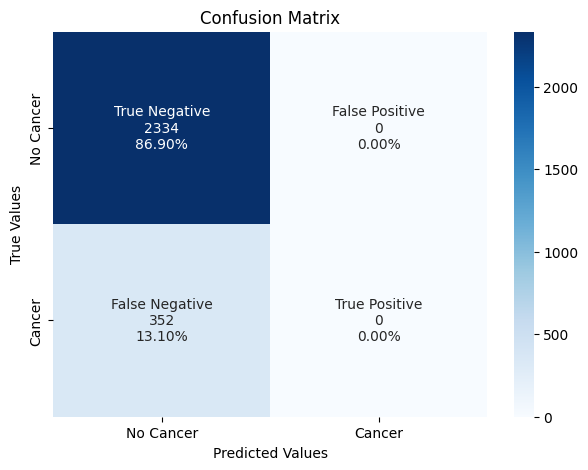

Training the model


Epoch 2, Training: 100%|██████████| 54/54 [00:35<00:00,  1.51batch/s, accuracy=87.2, loss=0.00337]


Training metrics for Epoch 2:
Accuracy: 0.8724632284490784
ROC: 0.7362011503520938
Precision: 0.08936170212765958
Recall: 0.5943396226415094
F1 score: 0.15536374845869297
Train loss: 0.0034
Confusion Matrix for training epoch 2: TP: 63, FP: 43, FN: 642, TN: 4623
Validating the trained model's performance


Validation 2: 100%|██████████| 34/34 [00:05<00:00,  5.91batch/s, accuracy=87.2, loss=0.00743]


Validation metrics for Epoch 2:
Accuracy: 0.8715562174236783
ROC: 0.5316553225052584
Precision: 0.5813953488372093
Recall: 0.07102272727272728
F1 score: 0.12658227848101267
Validation Loss: 0.0074
Confusion Matrix for validation epoch 2: TP: 25, FP: 18, FN: 327, TN: 2316
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.58      0.07      0.13       352
   No Cancer       0.88      0.99      0.93      2334

    accuracy                           0.87      2686
   macro avg       0.73      0.53      0.53      2686
weighted avg       0.84      0.87      0.83      2686



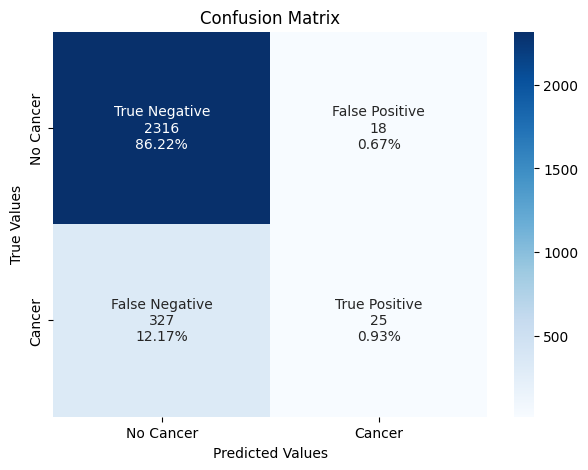

Training the model


Epoch 3, Training: 100%|██████████| 54/54 [00:35<00:00,  1.51batch/s, accuracy=89, loss=0.00284]  


Training metrics for Epoch 3:
Accuracy: 0.8903369949730031
ROC: 0.7934041993764791
Precision: 0.30638297872340425
Recall: 0.6835443037974683
F1 score: 0.42311459353574926
Train loss: 0.0028
Confusion Matrix for training epoch 3: TP: 216, FP: 100, FN: 489, TN: 4566
Validating the trained model's performance


Validation 3: 100%|██████████| 34/34 [00:05<00:00,  5.87batch/s, accuracy=87, loss=0.0071]   


Validation metrics for Epoch 3:
Accuracy: 0.8696947133283693
ROC: 0.5149032094726183
Precision: 0.5454545454545454
Recall: 0.03409090909090909
F1 score: 0.0641711229946524
Validation Loss: 0.0071
Confusion Matrix for validation epoch 3: TP: 12, FP: 10, FN: 340, TN: 2324
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.55      0.03      0.06       352
   No Cancer       0.87      1.00      0.93      2334

    accuracy                           0.87      2686
   macro avg       0.71      0.51      0.50      2686
weighted avg       0.83      0.87      0.82      2686



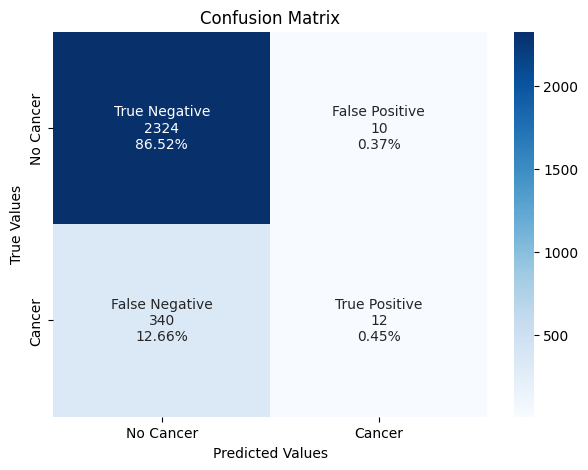

Training the model


Epoch 4, Training: 100%|██████████| 54/54 [00:35<00:00,  1.52batch/s, accuracy=91.2, loss=0.00224]


Training metrics for Epoch 4:
Accuracy: 0.9124930180599516
ROC: 0.8330474578055947
Precision: 0.5205673758865248
Recall: 0.7354709418837675
F1 score: 0.6096345514950166
Train loss: 0.0022
Confusion Matrix for training epoch 4: TP: 367, FP: 132, FN: 338, TN: 4534
Validating the trained model's performance


Validation 4: 100%|██████████| 34/34 [00:05<00:00,  5.88batch/s, accuracy=84.1, loss=0.0101] 


Validation metrics for Epoch 4:
Accuracy: 0.8413998510796724
ROC: 0.5649647990184623
Precision: 0.32211538461538464
Recall: 0.1903409090909091
F1 score: 0.23928571428571427
Validation Loss: 0.0101
Confusion Matrix for validation epoch 4: TP: 67, FP: 141, FN: 285, TN: 2193
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.32      0.19      0.24       352
   No Cancer       0.88      0.94      0.91      2334

    accuracy                           0.84      2686
   macro avg       0.60      0.56      0.58      2686
weighted avg       0.81      0.84      0.82      2686



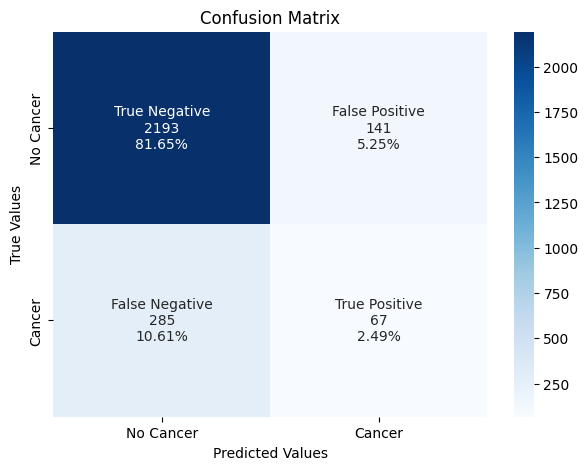

Training the model


Epoch 5, Training: 100%|██████████| 54/54 [00:35<00:00,  1.51batch/s, accuracy=95.1, loss=0.00135]


Training metrics for Epoch 5:
Accuracy: 0.9512195121951219
ROC: 0.9135630075649747
Precision: 0.7446808510638298
Recall: 0.8649093904448105
F1 score: 0.8003048780487804
Train loss: 0.0014
Confusion Matrix for training epoch 5: TP: 525, FP: 82, FN: 180, TN: 4584
Validating the trained model's performance


Validation 5: 100%|██████████| 34/34 [00:05<00:00,  5.88batch/s, accuracy=87, loss=0.0136]  


Validation metrics for Epoch 5:
Accuracy: 0.8700670141474312
ROC: 0.5078800537508764
Precision: 0.6666666666666666
Recall: 0.017045454545454544
F1 score: 0.03324099722991689
Validation Loss: 0.0136
Confusion Matrix for validation epoch 5: TP: 6, FP: 3, FN: 346, TN: 2331
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.67      0.02      0.03       352
   No Cancer       0.87      1.00      0.93      2334

    accuracy                           0.87      2686
   macro avg       0.77      0.51      0.48      2686
weighted avg       0.84      0.87      0.81      2686



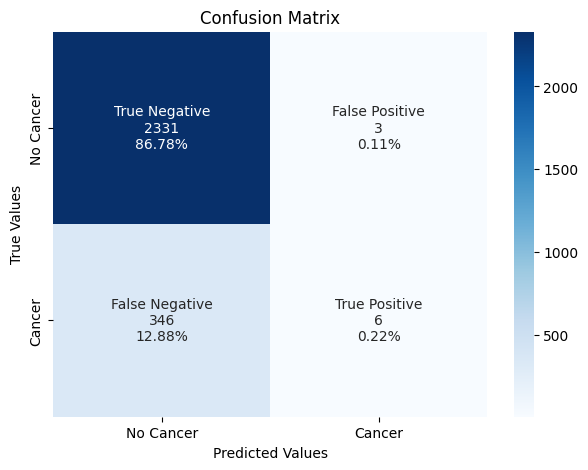

Training the model


Epoch 6, Training: 100%|██████████| 54/54 [00:35<00:00,  1.52batch/s, accuracy=97.6, loss=0.000713]


Training metrics for Epoch 6:
Accuracy: 0.975609756097561
ROC: 0.9542854868534685
Precision: 0.8851063829787233
Recall: 0.9258160237388724
F1 score: 0.9050036258158085
Train loss: 0.0007
Confusion Matrix for training epoch 6: TP: 624, FP: 50, FN: 81, TN: 4616
Validating the trained model's performance


Validation 6: 100%|██████████| 34/34 [00:05<00:00,  5.92batch/s, accuracy=79.8, loss=0.0109]


Validation metrics for Epoch 6:
Accuracy: 0.7982129560685034
ROC: 0.5883639577003973
Precision: 0.26485148514851486
Recall: 0.3039772727272727
F1 score: 0.2830687830687831
Validation Loss: 0.0109
Confusion Matrix for validation epoch 6: TP: 107, FP: 297, FN: 245, TN: 2037
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.26      0.30      0.28       352
   No Cancer       0.89      0.87      0.88      2334

    accuracy                           0.80      2686
   macro avg       0.58      0.59      0.58      2686
weighted avg       0.81      0.80      0.80      2686



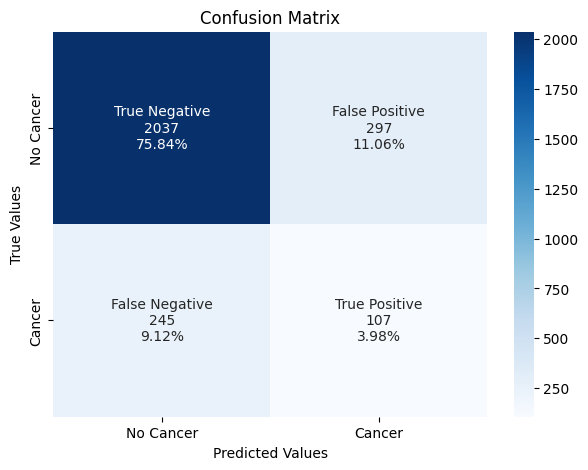

Training the model


Epoch 7, Training: 100%|██████████| 54/54 [00:35<00:00,  1.52batch/s, accuracy=97.2, loss=0.000724]


Training metrics for Epoch 7:
Accuracy: 0.9716998696704524
ROC: 0.9431368023526002
Precision: 0.8765957446808511
Recall: 0.9048316251830161
F1 score: 0.8904899135446687
Train loss: 0.0007
Confusion Matrix for training epoch 7: TP: 618, FP: 65, FN: 87, TN: 4601
Validating the trained model's performance


Validation 7: 100%|██████████| 34/34 [00:05<00:00,  5.93batch/s, accuracy=86.9, loss=0.0121]


Validation metrics for Epoch 7:
Accuracy: 0.8689501116902457
ROC: 0.5108560703435383
Precision: 0.5
Recall: 0.02556818181818182
F1 score: 0.04864864864864866
Validation Loss: 0.0121
Confusion Matrix for validation epoch 7: TP: 9, FP: 9, FN: 343, TN: 2325
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.50      0.03      0.05       352
   No Cancer       0.87      1.00      0.93      2334

    accuracy                           0.87      2686
   macro avg       0.69      0.51      0.49      2686
weighted avg       0.82      0.87      0.81      2686



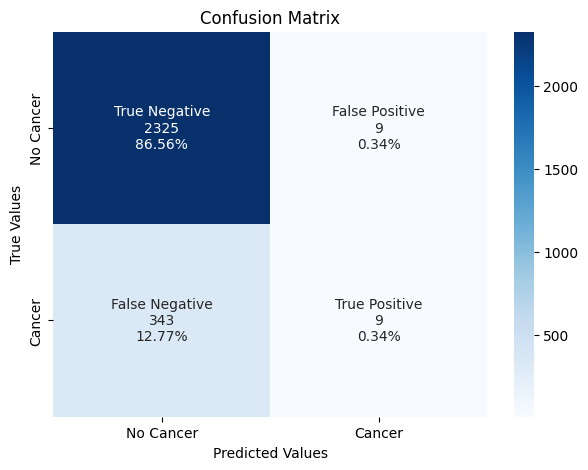

Training the model


Epoch 8, Training: 100%|██████████| 54/54 [00:35<00:00,  1.52batch/s, accuracy=98.4, loss=0.000464]


Training metrics for Epoch 8:
Accuracy: 0.9843604542915658
ROC: 0.969986961770025
Precision: 0.9290780141843972
Recall: 0.9506531204644412
F1 score: 0.93974175035868
Train loss: 0.0005
Confusion Matrix for training epoch 8: TP: 655, FP: 34, FN: 50, TN: 4632
Validating the trained model's performance


Validation 8: 100%|██████████| 34/34 [00:05<00:00,  5.86batch/s, accuracy=84.8, loss=0.0118]


Validation metrics for Epoch 8:
Accuracy: 0.8484735666418466
ROC: 0.5497353840461168
Precision: 0.3248407643312102
Recall: 0.14488636363636365
F1 score: 0.20039292730844793
Validation Loss: 0.0118
Confusion Matrix for validation epoch 8: TP: 51, FP: 106, FN: 301, TN: 2228
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.32      0.14      0.20       352
   No Cancer       0.88      0.95      0.92      2334

    accuracy                           0.85      2686
   macro avg       0.60      0.55      0.56      2686
weighted avg       0.81      0.85      0.82      2686



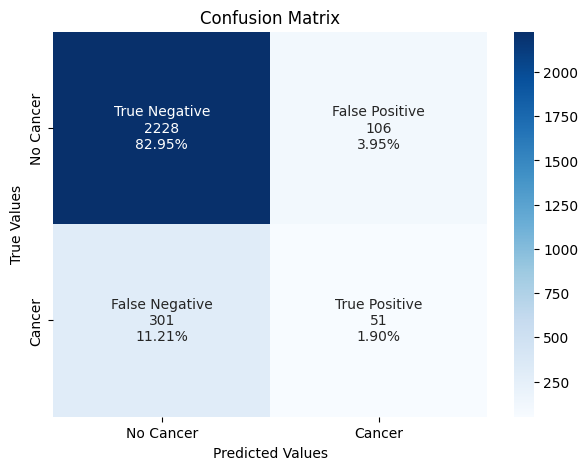

Training the model


Epoch 9, Training: 100%|██████████| 54/54 [00:35<00:00,  1.51batch/s, accuracy=98.5, loss=0.000432]


Training metrics for Epoch 9:
Accuracy: 0.9847328244274809
ROC: 0.9691819854638103
Precision: 0.9347517730496454
Recall: 0.9482014388489208
F1 score: 0.9414285714285714
Train loss: 0.0004
Confusion Matrix for training epoch 9: TP: 659, FP: 36, FN: 46, TN: 4630
Validating the trained model's performance


Validation 9: 100%|██████████| 34/34 [00:05<00:00,  5.84batch/s, accuracy=86.3, loss=0.0144]


Validation metrics for Epoch 9:
Accuracy: 0.8629932985852569
ROC: 0.5279343888759056
Precision: 0.38235294117647056
Recall: 0.07386363636363637
F1 score: 0.12380952380952381
Validation Loss: 0.0144
Confusion Matrix for validation epoch 9: TP: 26, FP: 42, FN: 326, TN: 2292
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.38      0.07      0.12       352
   No Cancer       0.88      0.98      0.93      2334

    accuracy                           0.86      2686
   macro avg       0.63      0.53      0.52      2686
weighted avg       0.81      0.86      0.82      2686



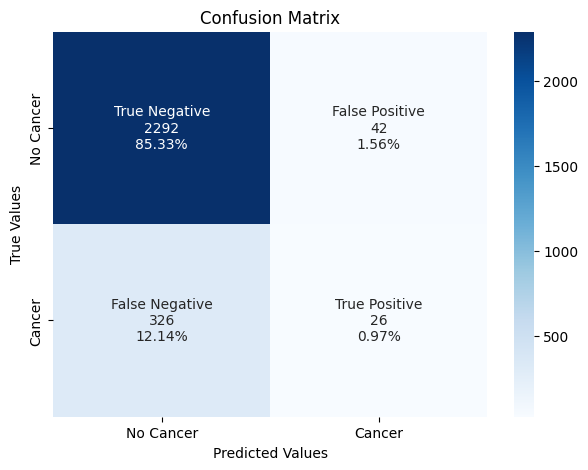

Early stopping inside the current folder!
Finished Training for Fold 1
The best model performance in fold 1 - Val Acc: 0.8630 Precision: 0.3824 Recall: 0.0739 F1: 0.2831 ROC: 0.5279
---------- Fold: 2 ----------
Dimensions of train_data: (5371, 9)
Dimensions of valid_data: (2686, 9)
Class Cancer: Training instances - 704, Validation instances - 353
Class No Cancer: Training instances - 4667, Validation instances - 2333
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Directory created for Fold 2: /kaggle/working/Best Model/Fold_2
Training the model


Epoch 1, Training: 100%|██████████| 54/54 [00:35<00:00,  1.51batch/s, accuracy=90.6, loss=0.00288]


Training metrics for Epoch 1:
Accuracy: 0.9061627257493949
ROC: 0.8312301650230922
Precision: 0.4346590909090909
Recall: 0.7427184466019418
F1 score: 0.5483870967741935
Train loss: 0.0029
Confusion Matrix for training epoch 1: TP: 306, FP: 106, FN: 398, TN: 4561
Validating the trained model's performance


Validation 1: 100%|██████████| 34/34 [00:05<00:00,  5.90batch/s, accuracy=92.1, loss=0.00248]


Validation metrics for Epoch 1:
Accuracy: 0.921072226358898
ROC: 0.7033230566730092
Precision: 0.9795918367346939
Recall: 0.40793201133144474
F1 score: 0.5760000000000001
Validation Loss: 0.0025
Confusion Matrix for validation epoch 1: TP: 144, FP: 3, FN: 209, TN: 2330
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.98      0.41      0.58       353
   No Cancer       0.92      1.00      0.96      2333

    accuracy                           0.92      2686
   macro avg       0.95      0.70      0.77      2686
weighted avg       0.93      0.92      0.91      2686



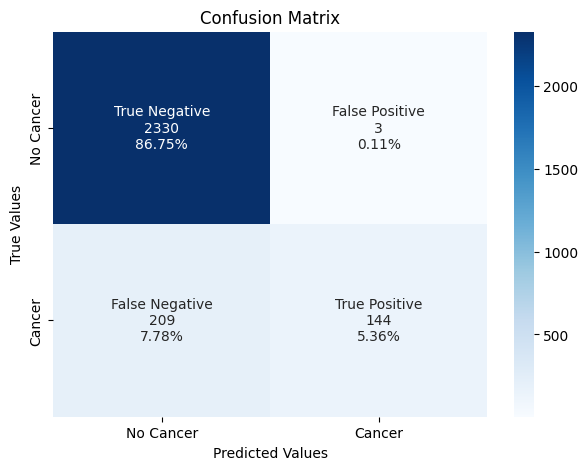

Training the model


Epoch 2, Training: 100%|██████████| 54/54 [00:35<00:00,  1.50batch/s, accuracy=96, loss=0.00118]  


Training metrics for Epoch 2:
Accuracy: 0.9597840253211692
ROC: 0.9354144872932981
Precision: 0.7755681818181818
Recall: 0.9039735099337748
F1 score: 0.8348623853211008
Train loss: 0.0012
Confusion Matrix for training epoch 2: TP: 546, FP: 58, FN: 158, TN: 4609
Validating the trained model's performance


Validation 2: 100%|██████████| 34/34 [00:05<00:00,  5.90batch/s, accuracy=92.9, loss=0.0027] 


Validation metrics for Epoch 2:
Accuracy: 0.9288905435591959
ROC: 0.7426850132778984
Precision: 0.9402173913043478
Recall: 0.49008498583569404
F1 score: 0.6443202979515829
Validation Loss: 0.0027
Confusion Matrix for validation epoch 2: TP: 173, FP: 11, FN: 180, TN: 2322
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.94      0.49      0.64       353
   No Cancer       0.93      1.00      0.96      2333

    accuracy                           0.93      2686
   macro avg       0.93      0.74      0.80      2686
weighted avg       0.93      0.93      0.92      2686



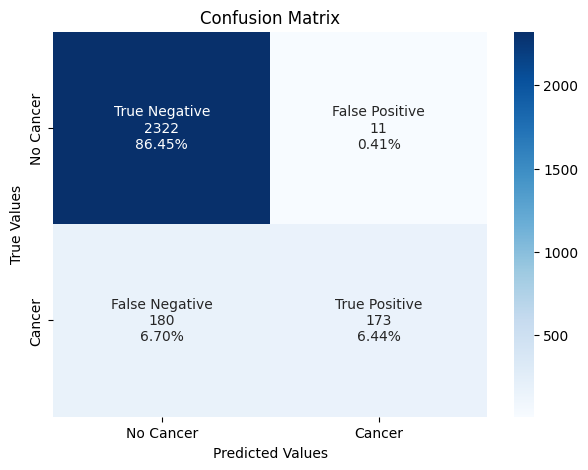

Training the model


Epoch 3, Training: 100%|██████████| 54/54 [00:35<00:00,  1.51batch/s, accuracy=98, loss=0.000573]  


Training metrics for Epoch 3:
Accuracy: 0.9802643827964997
ROC: 0.9662540218308864
Precision: 0.8991477272727273
Recall: 0.9476047904191617
F1 score: 0.9227405247813412
Train loss: 0.0006
Confusion Matrix for training epoch 3: TP: 633, FP: 35, FN: 71, TN: 4632
Validating the trained model's performance


Validation 3: 100%|██████████| 34/34 [00:05<00:00,  5.89batch/s, accuracy=93.5, loss=0.00281]


Validation metrics for Epoch 3:
Accuracy: 0.9348473566641846
ROC: 0.7629436742683192
Precision: 0.9540816326530612
Recall: 0.5297450424929179
F1 score: 0.6812386156648451
Validation Loss: 0.0028
Confusion Matrix for validation epoch 3: TP: 187, FP: 9, FN: 166, TN: 2324
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.95      0.53      0.68       353
   No Cancer       0.93      1.00      0.96      2333

    accuracy                           0.93      2686
   macro avg       0.94      0.76      0.82      2686
weighted avg       0.94      0.93      0.93      2686



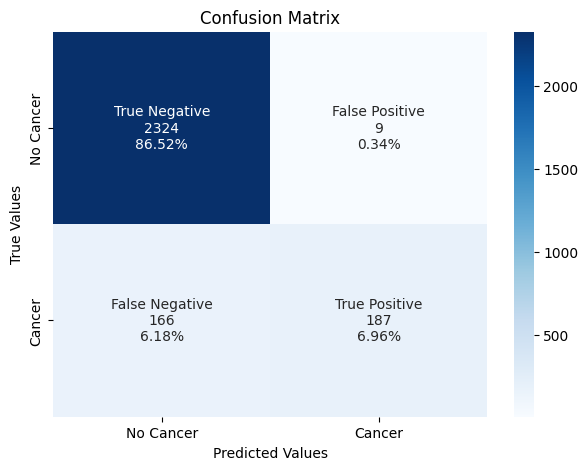

Training the model


Epoch 4, Training: 100%|██████████| 54/54 [00:35<00:00,  1.51batch/s, accuracy=98.2, loss=0.000493]


Training metrics for Epoch 4:
Accuracy: 0.9823124185440327
ROC: 0.9667276095723045
Precision: 0.9176136363636364
Recall: 0.9458272327964861
F1 score: 0.9315068493150686
Train loss: 0.0005
Confusion Matrix for training epoch 4: TP: 646, FP: 37, FN: 58, TN: 4630
Validating the trained model's performance


Validation 4: 100%|██████████| 34/34 [00:05<00:00,  5.83batch/s, accuracy=92.4, loss=0.00405]


Validation metrics for Epoch 4:
Accuracy: 0.9236783320923306
ROC: 0.7144401851013116
Precision: 0.9743589743589743
Recall: 0.43059490084985835
F1 score: 0.5972495088408645
Validation Loss: 0.0040
Confusion Matrix for validation epoch 4: TP: 152, FP: 4, FN: 201, TN: 2329
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.97      0.43      0.60       353
   No Cancer       0.92      1.00      0.96      2333

    accuracy                           0.92      2686
   macro avg       0.95      0.71      0.78      2686
weighted avg       0.93      0.92      0.91      2686



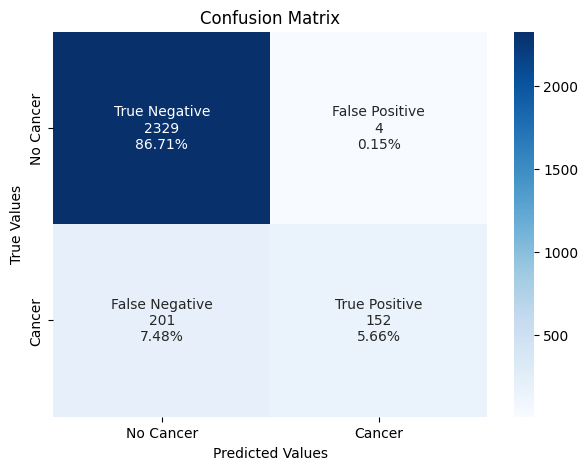

Training the model


Epoch 5, Training: 100%|██████████| 54/54 [00:35<00:00,  1.51batch/s, accuracy=98.8, loss=0.000361]


Training metrics for Epoch 5:
Accuracy: 0.9875256004468441
ROC: 0.976189592687422
Precision: 0.9431818181818182
Recall: 0.9609261939218524
F1 score: 0.9519713261648746
Train loss: 0.0004
Confusion Matrix for training epoch 5: TP: 664, FP: 27, FN: 40, TN: 4640
Validating the trained model's performance


Validation 5: 100%|██████████| 34/34 [00:05<00:00,  5.90batch/s, accuracy=90.6, loss=0.00648]


Validation metrics for Epoch 5:
Accuracy: 0.9058078927773641
ROC: 0.6488557450740635
Precision: 0.9464285714285714
Recall: 0.3002832861189802
F1 score: 0.45591397849462373
Validation Loss: 0.0065
Confusion Matrix for validation epoch 5: TP: 106, FP: 6, FN: 247, TN: 2327
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.95      0.30      0.46       353
   No Cancer       0.90      1.00      0.95      2333

    accuracy                           0.91      2686
   macro avg       0.93      0.65      0.70      2686
weighted avg       0.91      0.91      0.88      2686



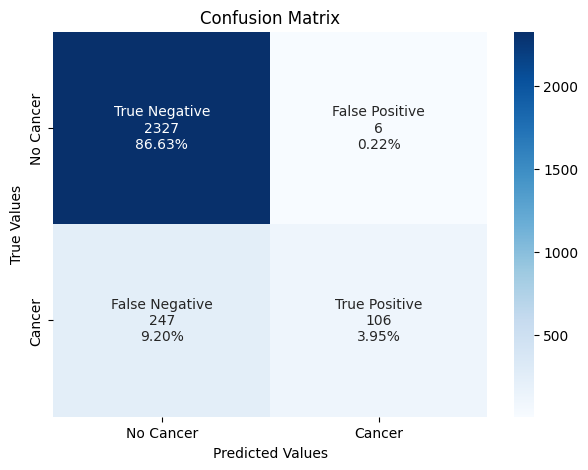

Training the model


Epoch 6, Training: 100%|██████████| 54/54 [00:35<00:00,  1.51batch/s, accuracy=98.5, loss=0.000419]


Training metrics for Epoch 6:
Accuracy: 0.9845466393595234
ROC: 0.9700937537392688
Precision: 0.9303977272727273
Recall: 0.9506531204644412
F1 score: 0.9404163675520458
Train loss: 0.0004
Confusion Matrix for training epoch 6: TP: 655, FP: 34, FN: 49, TN: 4633
Validating the trained model's performance


Validation 6: 100%|██████████| 34/34 [00:05<00:00,  5.89batch/s, accuracy=93.8, loss=0.00303]


Validation metrics for Epoch 6:
Accuracy: 0.9381980640357409
ROC: 0.781702120942409
Precision: 0.9348837209302325
Recall: 0.5694050991501416
F1 score: 0.7077464788732393
Validation Loss: 0.0030
Confusion Matrix for validation epoch 6: TP: 201, FP: 14, FN: 152, TN: 2319
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.93      0.57      0.71       353
   No Cancer       0.94      0.99      0.97      2333

    accuracy                           0.94      2686
   macro avg       0.94      0.78      0.84      2686
weighted avg       0.94      0.94      0.93      2686



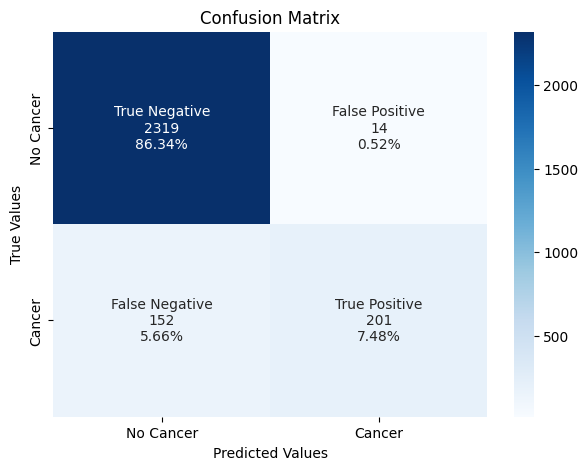

Training the model


Epoch 7, Training: 100%|██████████| 54/54 [00:35<00:00,  1.51batch/s, accuracy=98.4, loss=0.000441]


Training metrics for Epoch 7:
Accuracy: 0.9836157140197356
ROC: 0.9688334458650055
Precision: 0.9247159090909091
Recall: 0.9489795918367347
F1 score: 0.9366906474820144
Train loss: 0.0004
Confusion Matrix for training epoch 7: TP: 651, FP: 35, FN: 53, TN: 4632
Validating the trained model's performance


Validation 7: 100%|██████████| 34/34 [00:05<00:00,  5.79batch/s, accuracy=93.7, loss=0.00273]


Validation metrics for Epoch 7:
Accuracy: 0.9367088607594937
ROC: 0.871003425418524
Precision: 0.7479674796747967
Recall: 0.7818696883852692
F1 score: 0.7645429362880887
Validation Loss: 0.0027
Confusion Matrix for validation epoch 7: TP: 276, FP: 93, FN: 77, TN: 2240
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.75      0.78      0.76       353
   No Cancer       0.97      0.96      0.96      2333

    accuracy                           0.94      2686
   macro avg       0.86      0.87      0.86      2686
weighted avg       0.94      0.94      0.94      2686



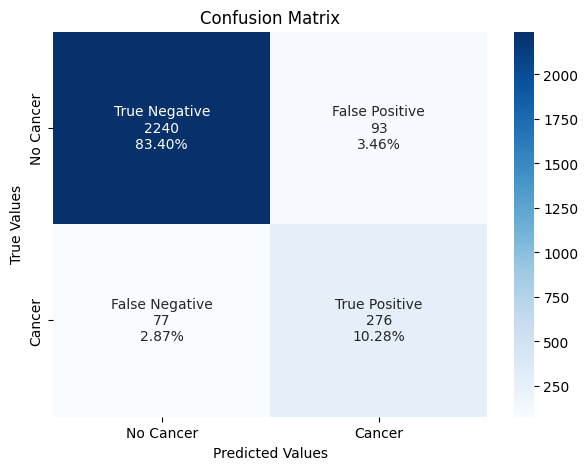

Training the model


Epoch 8, Training: 100%|██████████| 54/54 [00:35<00:00,  1.52batch/s, accuracy=99, loss=0.000292]  


Training metrics for Epoch 8:
Accuracy: 0.9903183764662075
ROC: 0.9787485755887565
Precision: 0.9630681818181818
Recall: 0.9630681818181818
F1 score: 0.9630681818181818
Train loss: 0.0003
Confusion Matrix for training epoch 8: TP: 678, FP: 26, FN: 26, TN: 4641
Validating the trained model's performance


Validation 8: 100%|██████████| 34/34 [00:05<00:00,  5.83batch/s, accuracy=92.9, loss=0.00372]


Validation metrics for Epoch 8:
Accuracy: 0.9288905435591959
ROC: 0.7667272985578272
Precision: 0.8616071428571429
Recall: 0.546742209631728
F1 score: 0.6689774696707107
Validation Loss: 0.0037
Confusion Matrix for validation epoch 8: TP: 193, FP: 31, FN: 160, TN: 2302
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.86      0.55      0.67       353
   No Cancer       0.94      0.99      0.96      2333

    accuracy                           0.93      2686
   macro avg       0.90      0.77      0.81      2686
weighted avg       0.93      0.93      0.92      2686



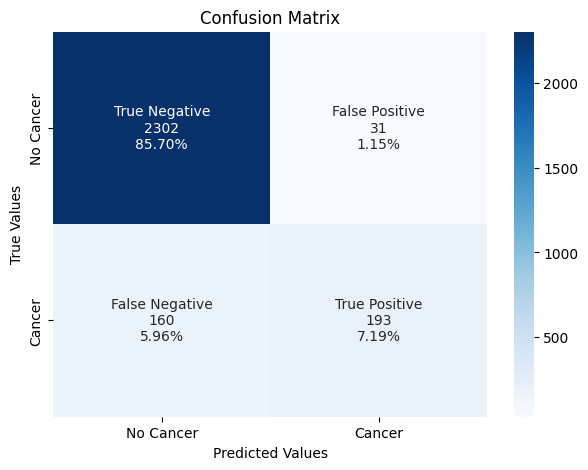

Training the model


Epoch 9, Training: 100%|██████████| 54/54 [00:35<00:00,  1.51batch/s, accuracy=99.5, loss=0.000188]


Training metrics for Epoch 9:
Accuracy: 0.9946006330292311
ROC: 0.990183493166201
Precision: 0.9744318181818182
Recall: 0.9842180774748924
F1 score: 0.979300499643112
Train loss: 0.0002
Confusion Matrix for training epoch 9: TP: 686, FP: 11, FN: 18, TN: 4656
Validating the trained model's performance


Validation 9: 100%|██████████| 34/34 [00:05<00:00,  5.83batch/s, accuracy=90.3, loss=0.00611]


Validation metrics for Epoch 9:
Accuracy: 0.9028294862248697
ROC: 0.6375243003148567
Precision: 0.9423076923076923
Recall: 0.2776203966005666
F1 score: 0.42888402625820576
Validation Loss: 0.0061
Confusion Matrix for validation epoch 9: TP: 98, FP: 6, FN: 255, TN: 2327
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.94      0.28      0.43       353
   No Cancer       0.90      1.00      0.95      2333

    accuracy                           0.90      2686
   macro avg       0.92      0.64      0.69      2686
weighted avg       0.91      0.90      0.88      2686



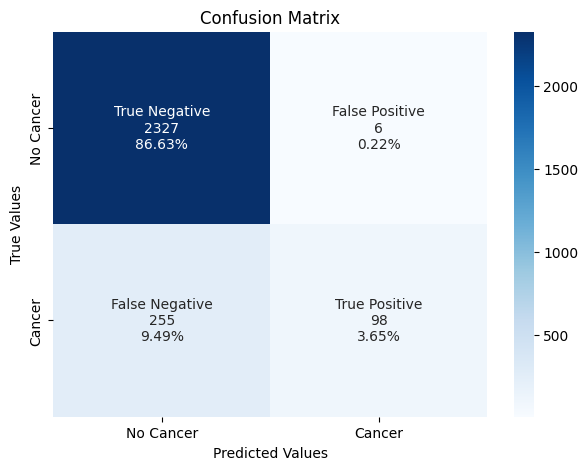

Training the model


Epoch 10, Training: 100%|██████████| 54/54 [00:35<00:00,  1.51batch/s, accuracy=99.4, loss=0.000223]


Training metrics for Epoch 10:
Accuracy: 0.9936697076894433
ROC: 0.9878313937838353
Precision: 0.9715909090909091
Recall: 0.9799426934097422
F1 score: 0.9757489300998574
Train loss: 0.0002
Confusion Matrix for training epoch 10: TP: 684, FP: 14, FN: 20, TN: 4653
Validating the trained model's performance


Validation 10: 100%|██████████| 34/34 [00:05<00:00,  5.80batch/s, accuracy=91.4, loss=0.00575]


Validation metrics for Epoch 10:
Accuracy: 0.9139985107967238
ROC: 0.6812193324258787
Precision: 0.9485294117647058
Recall: 0.3654390934844193
F1 score: 0.5276073619631901
Validation Loss: 0.0058
Confusion Matrix for validation epoch 10: TP: 129, FP: 7, FN: 224, TN: 2326
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.95      0.37      0.53       353
   No Cancer       0.91      1.00      0.95      2333

    accuracy                           0.91      2686
   macro avg       0.93      0.68      0.74      2686
weighted avg       0.92      0.91      0.90      2686



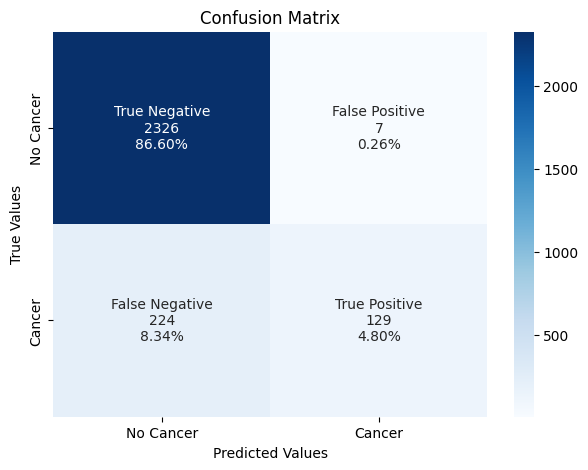

Early stopping inside the current folder!
Finished Training for Fold 2
The best model performance in fold 2 - Val Acc: 0.9140 Precision: 0.9485 Recall: 0.3654 F1: 0.7645 ROC: 0.6812
---------- Fold: 3 ----------
Dimensions of train_data: (5372, 9)
Dimensions of valid_data: (2685, 9)
Class Cancer: Training instances - 705, Validation instances - 352
Class No Cancer: Training instances - 4667, Validation instances - 2333
Creating Data instances for train, test, and validation datasets:
Data instances created.
Creating DataLoaders for batching data:
DataLoaders created.
Directory created for Fold 3: /kaggle/working/Best Model/Fold_3
Training the model


Epoch 1, Training: 100%|██████████| 54/54 [00:35<00:00,  1.51batch/s, accuracy=94.8, loss=0.00148]


Training metrics for Epoch 1:
Accuracy: 0.9480640357408786
ROC: 0.8973946674233586
Precision: 0.7588652482269503
Recall: 0.8307453416149069
F1 score: 0.7931801334321721
Train loss: 0.0015
Confusion Matrix for training epoch 1: TP: 535, FP: 109, FN: 170, TN: 4558
Validating the trained model's performance


Validation 1: 100%|██████████| 34/34 [00:05<00:00,  5.85batch/s, accuracy=94.4, loss=0.00165]


Validation metrics for Epoch 1:
Accuracy: 0.9441340782122905
ROC: 0.9642341357206874
Precision: 0.7036290322580645
Recall: 0.9914772727272727
F1 score: 0.8231132075471699
Validation Loss: 0.0016
Confusion Matrix for validation epoch 1: TP: 349, FP: 147, FN: 3, TN: 2186
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.70      0.99      0.82       352
   No Cancer       1.00      0.94      0.97      2333

    accuracy                           0.94      2685
   macro avg       0.85      0.96      0.89      2685
weighted avg       0.96      0.94      0.95      2685



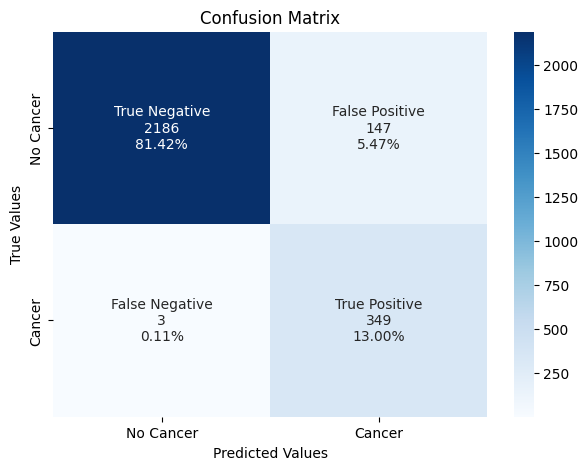

Training the model


Epoch 2, Training: 100%|██████████| 54/54 [00:35<00:00,  1.51batch/s, accuracy=98.5, loss=0.000434]


Training metrics for Epoch 2:
Accuracy: 0.9845495160089353
ROC: 0.9701295123476281
Precision: 0.9304964539007092
Recall: 0.9507246376811594
F1 score: 0.9405017921146953
Train loss: 0.0004
Confusion Matrix for training epoch 2: TP: 656, FP: 34, FN: 49, TN: 4633
Validating the trained model's performance


Validation 2: 100%|██████████| 34/34 [00:05<00:00,  5.87batch/s, accuracy=99.3, loss=0.000216]


Validation metrics for Epoch 2:
Accuracy: 0.9932960893854749
ROC: 0.9768440946109186
Precision: 0.9940828402366864
Recall: 0.9545454545454546
F1 score: 0.9739130434782608
Validation Loss: 0.0002
Confusion Matrix for validation epoch 2: TP: 336, FP: 2, FN: 16, TN: 2331
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.95      0.97       352
   No Cancer       0.99      1.00      1.00      2333

    accuracy                           0.99      2685
   macro avg       0.99      0.98      0.99      2685
weighted avg       0.99      0.99      0.99      2685



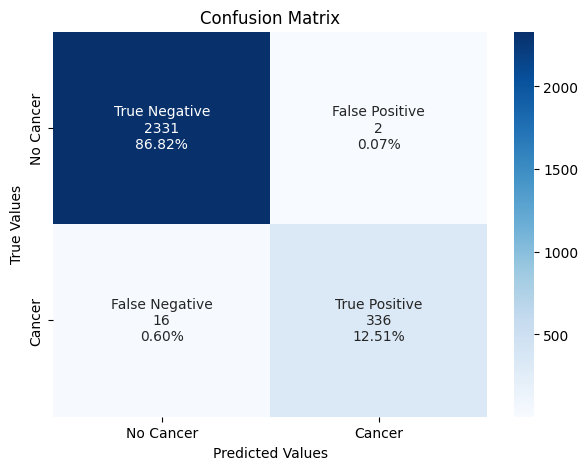

Training the model


Epoch 3, Training: 100%|██████████| 54/54 [00:35<00:00,  1.52batch/s, accuracy=99.5, loss=0.000153]


Training metrics for Epoch 3:
Accuracy: 0.9951600893521966
ROC: 0.9905484137258729
Precision: 0.9787234042553191
Recall: 0.9843081312410842
F1 score: 0.9815078236130869
Train loss: 0.0002
Confusion Matrix for training epoch 3: TP: 690, FP: 11, FN: 15, TN: 4656
Validating the trained model's performance


Validation 3: 100%|██████████| 34/34 [00:05<00:00,  5.73batch/s, accuracy=99, loss=0.00035]   


Validation metrics for Epoch 3:
Accuracy: 0.9899441340782122
ROC: 0.9652661419163776
Precision: 0.9909365558912386
Recall: 0.9318181818181818
F1 score: 0.9604685212298681
Validation Loss: 0.0004
Confusion Matrix for validation epoch 3: TP: 328, FP: 3, FN: 24, TN: 2330
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.93      0.96       352
   No Cancer       0.99      1.00      0.99      2333

    accuracy                           0.99      2685
   macro avg       0.99      0.97      0.98      2685
weighted avg       0.99      0.99      0.99      2685



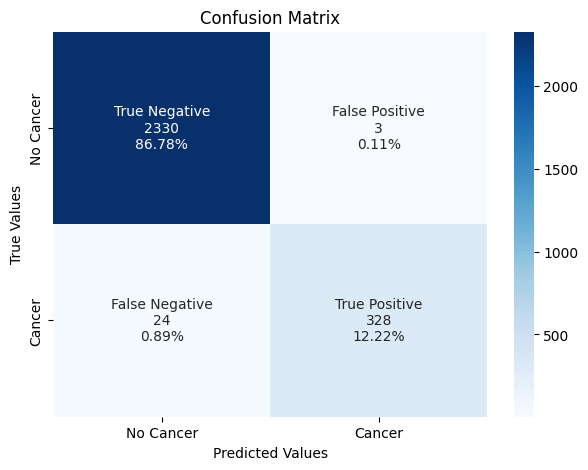

Training the model


Epoch 4, Training: 100%|██████████| 54/54 [00:35<00:00,  1.52batch/s, accuracy=99.7, loss=0.000114]


Training metrics for Epoch 4:
Accuracy: 0.9966492926284438
ROC: 0.993829654611527
Precision: 0.9843971631205674
Recall: 0.9900142653352354
F1 score: 0.9871977240398293
Train loss: 0.0001
Confusion Matrix for training epoch 4: TP: 694, FP: 7, FN: 11, TN: 4660
Validating the trained model's performance


Validation 4: 100%|██████████| 34/34 [00:05<00:00,  5.83batch/s, accuracy=98.4, loss=0.000621]


Validation metrics for Epoch 4:
Accuracy: 0.9836126629422719
ROC: 0.9399122764291004
Precision: 0.9935897435897436
Recall: 0.8806818181818182
F1 score: 0.9337349397590361
Validation Loss: 0.0006
Confusion Matrix for validation epoch 4: TP: 310, FP: 2, FN: 42, TN: 2331
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.88      0.93       352
   No Cancer       0.98      1.00      0.99      2333

    accuracy                           0.98      2685
   macro avg       0.99      0.94      0.96      2685
weighted avg       0.98      0.98      0.98      2685



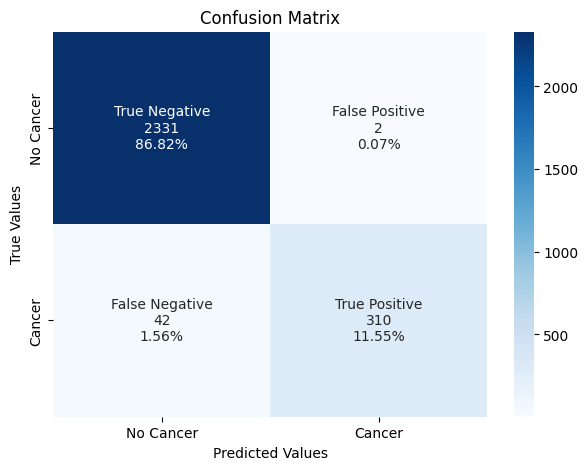

Training the model


Epoch 5, Training: 100%|██████████| 54/54 [00:35<00:00,  1.51batch/s, accuracy=99.2, loss=0.000229]


Training metrics for Epoch 5:
Accuracy: 0.992367833209233
ROC: 0.9841117760817973
Precision: 0.9687943262411347
Recall: 0.9729344729344729
F1 score: 0.9708599857853589
Train loss: 0.0002
Confusion Matrix for training epoch 5: TP: 683, FP: 19, FN: 22, TN: 4648
Validating the trained model's performance


Validation 5: 100%|██████████| 34/34 [00:05<00:00,  5.85batch/s, accuracy=98.3, loss=0.000827]


Validation metrics for Epoch 5:
Accuracy: 0.9828677839851024
ROC: 0.9394836437672914
Precision: 0.9872611464968153
Recall: 0.8806818181818182
F1 score: 0.9309309309309309
Validation Loss: 0.0008
Confusion Matrix for validation epoch 5: TP: 310, FP: 4, FN: 42, TN: 2329
+++++++++ Confusion Matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.99      0.88      0.93       352
   No Cancer       0.98      1.00      0.99      2333

    accuracy                           0.98      2685
   macro avg       0.98      0.94      0.96      2685
weighted avg       0.98      0.98      0.98      2685



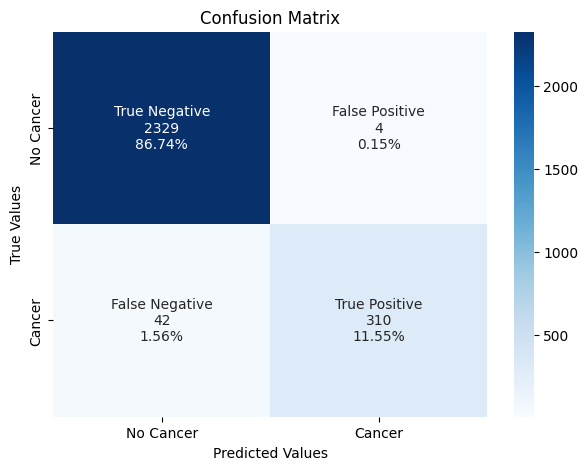

Early stopping inside the current folder!
Finished Training for Fold 3
The best model performance in fold 3 - Val Acc: 0.9829 Precision: 0.9873 Recall: 0.8807 F1: 0.9739 ROC: 0.9395
The overall best model has been saved with metrics - Val Acc: 0.9829, Precision: 0.9873, Recall: 0.8807, F1: 0.9739, ROC: 0.9395
Log file at /kaggle/working/Logs/logs_5.0.txt has been closed.


In [119]:
FOLDS = 3
EPOCHS = 10
PATIENCE = 3
WORKERS = 10

version = '5.0'

# Configuration of hyperparameters
train_batch_size = 100 #64
test_batch_size = 32 #32
val_batch_size = 80 #32
num_workers = 4

# Configuration des hyperparamètres
learning_rate = 0.001
num_epochs = 20
early_stopping_patience = 3
best_model_state = None


base_path = save_best_model_dir  

# Create a dictionary to store the hyperparameters
model_EffNetNetwork = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

train_folds(model=model_EffNetNetwork, train_original=sample_train)

Shape Of Train Sample: (8057, 9)


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,35295,603664888,1,1,73.0,0,0,No Cancer,/kaggle/working/Processed Image/35295/60366488...
1,20391,520507163,1,1,57.0,0,0,No Cancer,/kaggle/working/Processed Image/20391/52050716...
2,56742,1683721941,1,5,50.0,0,0,No Cancer,/kaggle/working/Processed Image/56742/16837219...
3,31758,336430653,1,1,48.0,0,0,No Cancer,/kaggle/working/Processed Image/31758/33643065...
4,47844,727384240,1,1,50.0,0,0,No Cancer,/kaggle/working/Processed Image/47844/72738424...


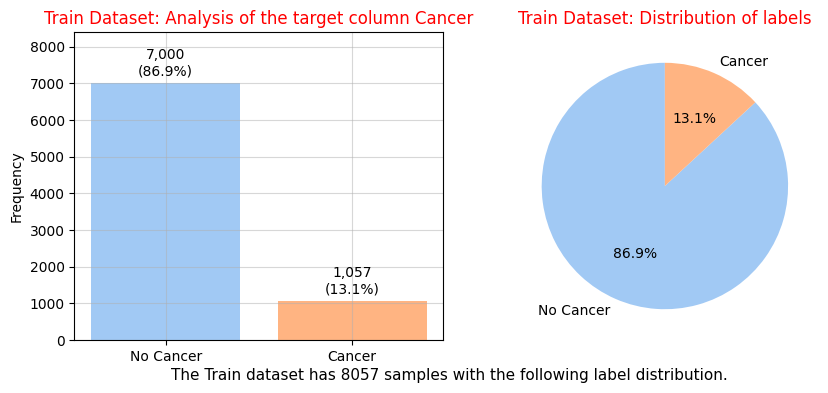

In [118]:
# Sample down for dev
num_class_0,num_class_1 = 7000, 1057 #7000, 1057 # full dataset ===> 1500, 1158
sample_train = create_subset_train(df_train, 'cancer', num_class_0=num_class_0, num_class_1=num_class_1)
print(f'Shape Of Train Sample: {sample_train.shape}')
display(sample_train.head())
print("======="*20)
plot_label_distribution(sample_train,'Train')

In [ ]:
My_Custom_RSNA_Dataset(train_data, csv_columns)

Shape Of Train Sample: (601, 9)


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,61707,1790684648,1,1,62.0,0,0,No Cancer,/kaggle/working/Processed Image/61707/17906846...
1,19277,1275907951,1,5,47.0,1,0,No Cancer,/kaggle/working/Processed Image/19277/12759079...
2,3626,1942920371,0,1,82.0,0,1,Cancer,/kaggle/working/Processed Image/3626/194292037...
3,6445,197683890,1,1,74.0,0,0,No Cancer,/kaggle/working/Processed Image/6445/197683890...
4,32880,554197513,1,5,69.0,0,0,No Cancer,/kaggle/working/Processed Image/32880/55419751...


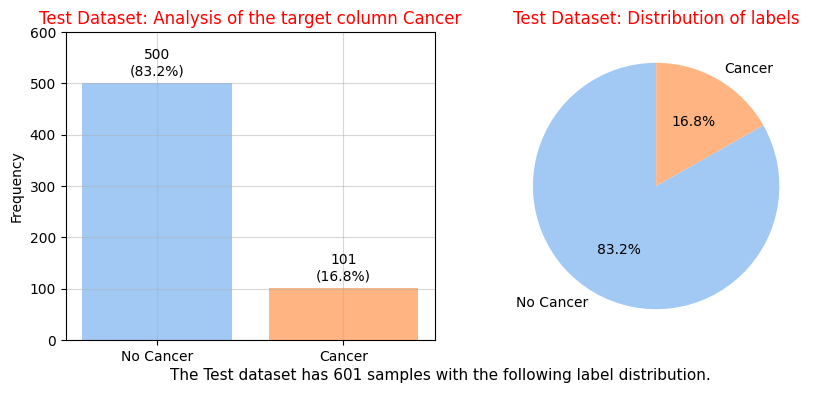

Creating Data instances for  test datasets:
Creating DataLoaders for batching data:
Loaded pretrained weights for efficientnet-b2
Evaluate the best trained model's


Testing: : 100%|██████████| 21/21 [00:34<00:00,  1.62s/batch]


+++++++++ confusion_matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.28      0.48      0.35       101
   No Cancer       0.88      0.75      0.81       500

    accuracy                           0.70       601
   macro avg       0.58      0.61      0.58       601
weighted avg       0.78      0.70      0.73       601



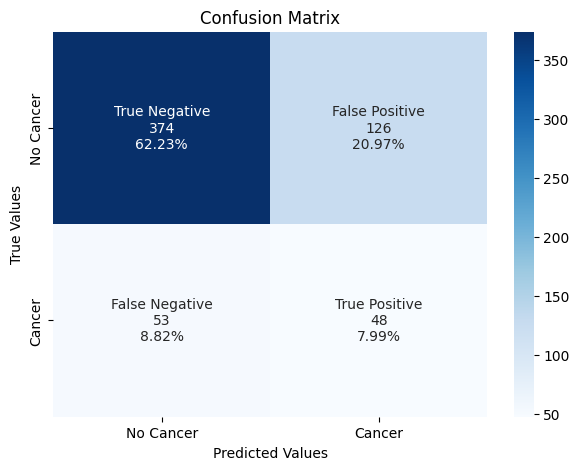

In [65]:
# Sample down for dev
num_class_0,num_class_1 = 500,101 #7000, 1057 # full dataset ===> 1500, 1158
sample_test = create_subset_train(df_test, 'cancer', num_class_0=num_class_0, num_class_1=num_class_1)
print(f'Shape Of Train Sample: {sample_test.shape}')
display(sample_test.head())
print("======="*25)
plot_label_distribution(sample_test,'Test')

print("======="*25)

def evaluate_best_model(save_best_model_dir,best_model, test_loader):
    # Path where the best model is saved
    model_path = os.path.join(save_best_model_dir, 'best_model_overall.pth')
    
    best_model.load_state_dict(torch.load(model_path))
    
    # Set your model to evaluation mode
    best_model.eval()
    print(Color.S + f"Evaluate the best trained model's" + Color.E)
    
    # Make predictions
    test_preds = []
    test_labels = []
    
    # Progress bar for testing
    with tqdm(test_loader, unit="batch") as testepoch:
        testepoch.set_description("Testing: ")
        with torch.no_grad():
            for batch in testepoch:
                images, meta, labels = data_to_device(batch)
                outputs = best_model(images, meta)
                labels = labels.unsqueeze(1).float()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())
    
    print("+++++++++ confusion_matrix +++++++++")
    # Display the confusion matrix
    display_confusion_matrix(test_labels, test_preds)
    
    
test_batch_size = 30 #32
num_workers = 3

test_data = sample_test.reset_index(drop=True)

# Instantiate Dataset object
print("Creating Data instances for  test datasets:")
test = My_Custom_RSNA_Dataset(test_data,csv_columns)

# Dataloaders for batching data
print("Creating DataLoaders for batching data:")
test_loader = DataLoader(test, batch_size=test_batch_size, shuffle=False, num_workers=num_workers)

# Define your EffNetNetwork and data_to_device function here
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Appel de la fonction
evaluate_best_model(save_best_model_dir, model, test_loader)

In [ ]:
from torch.utils.data import Dataset
import cv2
import numpy as np
from albumentations import Compose
from albumentations.pytorch import ToTensorV2

class CustomRSNATestDataset(Dataset):
    def __init__(self, dataframe, csv_columns, transform=None, resize_dims=(224, 224)):
        self.dataframe = dataframe
        self.csv_columns = csv_columns
        self.resize_dims = resize_dims  # Set desired resize dimensions (width, height)
        
        # Data Augmentation (custom for each dataset type)
        # Use provided transform if available, otherwise default to basic tensor conversion
        self.transform = transform if transform else Compose([ToTensorV2()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        '''Take each row in batch at a time.'''
        # Select path and read image
        image_path = self.dataframe['path_image_processed'][index]
        
        # Apply resizing for processed images
        image = cv2.imread(image_path).astype(np.float32) / 255.0
        image = cv2.resize(image, self.resize_dims)  # Resize image to specified dimensions

        # Apply transforms
        transf_image = self.transform(image=image)['image']

        # Import .csv information
        csv_data = np.array(self.dataframe.iloc[index][self.csv_columns].values, dtype=np.float32)

        # Return information, note: no target since it's test data
        return {
            "image": transf_image,
            "meta": csv_data
        }

In [87]:
from torch.utils.data import Dataset
import cv2
import numpy as np
from albumentations import Compose
from albumentations.pytorch import ToTensorV2

class CustomRSNATestDataset(Dataset):
    def __init__(self, dataframe, csv_columns, transform=None, resize_dims=(224, 224)):
        self.dataframe = dataframe
        self.csv_columns = csv_columns
        self.resize_dims = resize_dims  # Set desired resize dimensions (width, height)
        
        # Data Augmentation (custom for each dataset type)
        # Use provided transform if available, otherwise default to basic tensor conversion
        self.transform = transform if transform else Compose([ToTensorV2()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        '''Take each row in batch at a time.'''
        # Select path and read image
        image_path = self.dataframe['path_image_processed'][index]
        
        # Read image from the path
        image = cv2.imread(image_path)
        
        # Resize the image to specified dimensions
        image = cv2.resize(image, self.resize_dims)
        
        # Normalize pixel values to the range [0, 1]
        image = image.astype(np.float32) / 255.0

        # Apply transforms
        transf_image = self.transform(image=image)['image']

        # Import .csv information
        csv_data = np.array(self.dataframe.iloc[index][self.csv_columns].values, dtype=np.float32)

        # Return information, note: no target since it's test data
        return {
            "image": transf_image,
            "meta": csv_data,
            "target": self.dataframe['cancer'][index]
        }


Shape Of Train Sample: (601, 9)


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,61707,1790684648,1,1,62.0,0,0,No Cancer,/kaggle/working/Processed Image/61707/17906846...
1,19277,1275907951,1,5,47.0,1,0,No Cancer,/kaggle/working/Processed Image/19277/12759079...
2,3626,1942920371,0,1,82.0,0,1,Cancer,/kaggle/working/Processed Image/3626/194292037...
3,6445,197683890,1,1,74.0,0,0,No Cancer,/kaggle/working/Processed Image/6445/197683890...
4,32880,554197513,1,5,69.0,0,0,No Cancer,/kaggle/working/Processed Image/32880/55419751...


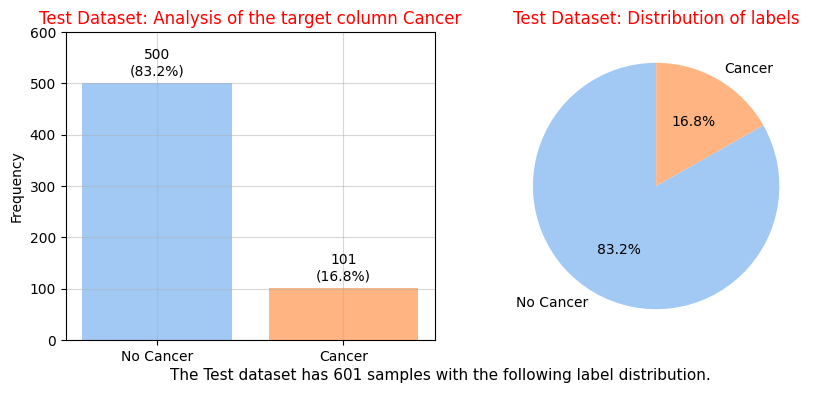

Creating Data instances for  test datasets:
Creating DataLoaders for batching data:
Loaded pretrained weights for efficientnet-b2
Evaluate the best trained model's


Testing: : 100%|██████████| 21/21 [00:01<00:00, 13.40batch/s]


+++++++++ confusion_matrix +++++++++
Classification Report:
               precision    recall  f1-score   support

      Cancer       0.31      0.35      0.33       101
   No Cancer       0.87      0.85      0.86       500

    accuracy                           0.76       601
   macro avg       0.59      0.60      0.59       601
weighted avg       0.77      0.76      0.77       601



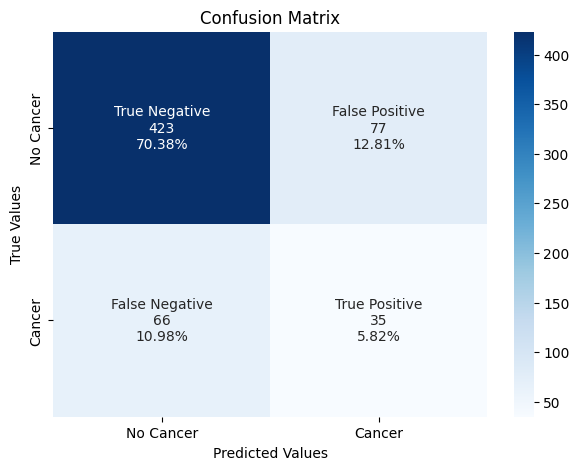

In [91]:
# Sample down for dev
num_class_0,num_class_1 = 500,101 #7000, 1057 # full dataset ===> 1500, 1158
sample_test = create_subset_train(df_test, 'cancer', num_class_0=num_class_0, num_class_1=num_class_1)
print(f'Shape Of Train Sample: {sample_test.shape}')
display(sample_test.head())
print("======="*25)
plot_label_distribution(sample_test,'Test')

print("======="*25)

def evaluate_best_model(save_best_model_dir,best_model, test_loader):
    # Path where the best model is saved
    model_path = os.path.join(save_best_model_dir, 'best_model_overall.pth')
    
    best_model.load_state_dict(torch.load(model_path))
    
    # Set your model to evaluation mode
    best_model.eval()
    print(Color.S + f"Evaluate the best trained model's" + Color.E)
    
    # Make predictions
    test_preds = []
    test_labels = []
    
    # Progress bar for testing
    with tqdm(test_loader, unit="batch") as testepoch:
        testepoch.set_description("Testing: ")
        with torch.no_grad():
            for batch in testepoch:
                images, meta, labels = data_to_device(batch)
                outputs = best_model(images, meta)
                labels = labels.unsqueeze(1).float()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())
    
    print("+++++++++ confusion_matrix +++++++++")
    # Display the confusion matrix
    display_confusion_matrix(test_labels, test_preds)
    
    
test_batch_size = 30 #32
num_workers = 3

test_data = sample_test.reset_index(drop=True)

# Instantiate Dataset object
print("Creating Data instances for  test datasets:")
test = CustomRSNATestDataset(test_data,csv_columns)

# Dataloaders for batching data
print("Creating DataLoaders for batching data:")
test_loader = DataLoader(test, batch_size=test_batch_size, shuffle=False, num_workers=num_workers)

# Define your EffNetNetwork and data_to_device function here
model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Appel de la fonction
evaluate_best_model(save_best_model_dir, model, test_loader)

In [90]:
save_best_model_dir

'/kaggle/working/Best Model'

In [ ]:
FOLDS = 3
EPOCHS = 10
PATIENCE = 3
WORKERS = 10

version = '3.0'

# Configuration of hyperparameters
train_batch_size = 80 #64
test_batch_size = 32 #32
val_batch_size = 80 #32
num_workers = 4

# Configuration des hyperparamètres
learning_rate = 0.001
num_epochs = 10
early_stopping_patience = 3
best_model_state = None


base_path = save_best_model_dir  

# Create a dictionary to store the hyperparameters
model_EffNetNetwork = OptimizedEffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

train_folds(model=model_EffNetNetwork, train_original=processed_df)

In [ ]:
def train_model_cross_validation(model, train_original, hyperparameters):
    # Define the threshold
    threshold = 0.5
    
    # Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()  # Using Binary Cross Entropy with Logits for binary classification
    optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # Early stopping parameters
    patience = hyperparameters["early_stopping_patience"]

    # Early stopping
    best_overall_val_f1_score = float('-inf')  # Initialize the overall best validation F1 score
    best_model_state = None  # Initialize the best model state
    best_overall_model_state = None  # Initialize the overall best model state
    best_overall_metrics = {}  # Initialize the overall best model metrics

    # Create a log file to store training progress
    log_file_path = create_logs_file(logs_dir, version)

    # Initialize stratified cross-validation
    skf = StratifiedKFold(n_splits=hyperparameters["folds"], shuffle=True, random_state=400)

    # Iterate over stratified cross-validation folds
    for fold_idx, (train_index, valid_index) in enumerate(skf.split(train_original.values, train_original['cancer'].values)):

        print(Color.S + f"---------- Fold: {fold_idx + 1} ----------" + Color.E)
        add_in_file(f"---------- Fold: {fold_idx + 1} ----------", log_file_path)
        
        # Read in data for the current fold
        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)
        
        display_dataset_statistics(train_data, valid_data)
        
        # Create custom datasets for training and validation
        print("Creating Data instances for train, test, and validation datasets:")
        train = CustomRSNADataset(train_data, csv_columns, is_train=True)
        valid = CustomRSNADataset(valid_data, csv_columns, is_train=True)
        print("Data instances created.")

        # Create DataLoader instances for batching data
        print("Creating DataLoaders for batching data:")
        train_loader = DataLoader(train, batch_size=hyperparameters["train_batch_size"], shuffle=True, num_workers=hyperparameters["num_workers"])
        valid_loader = DataLoader(valid, batch_size=hyperparameters["val_batch_size"], shuffle=False, num_workers=hyperparameters["num_workers"])
        print("DataLoaders created.")

        # Early stopping parameters for this fold
        best_val_f1_score = float('-inf')
        trigger_times = 0
        best_model_state = None

        # Lists to store metrics for plotting
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = []

        # Training the model
        for epoch in range(hyperparameters["num_epochs"]):
            start_time = time()
            print(Color.S + f"Training the model" + Color.E)
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            train_preds = []
            train_labels = []

            # Progress bar for training
            with tqdm(train_loader, unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch+1}, Training")

                # Iterate over batches in the training DataLoader
                for k, batch in enumerate(tepoch):
                    images, meta, labels = data_to_device(batch)
                    optimizer.zero_grad()
                    outputs = model(images, meta)
                    labels = labels.unsqueeze(1).float()
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    predicted = (torch.sigmoid(outputs) > threshold).float()
                    train_preds.extend(predicted.cpu().numpy())
                    train_labels.extend(labels.cpu().numpy())

                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

                    tepoch.set_postfix(loss=train_loss / total, accuracy=100. * correct / total)

            # Calculate training metrics
            train_loss /= len(train_loader.dataset)
            train_accuracy = accuracy_score(train_labels, train_preds)
            train_roc = roc_auc_score(train_labels, train_preds)
            train_precision = precision_score(train_labels, train_preds)
            train_recall = recall_score(train_labels, train_preds)
            train_f1 = f1_score(train_labels, train_preds)
            
            print(f"Training metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {train_accuracy}")
            print(f"ROC: {train_roc}")
            print(f"Precision: {train_precision}")
            print(f"Recall: {train_recall}")
            print(f"F1 score: {train_f1}")
            print(f'Train loss: {train_loss:.4f}')

            # Validate the model's performance on validation set
            print(Color.S + f"Validating the trained model's performance" + Color.E)
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            val_preds = []
            val_labels = []

            # Progress bar for validation
            with tqdm(valid_loader, unit="batch") as vepoch:
                vepoch.set_description(f"Validation {epoch+1}")
                with torch.no_grad():
                    # Iterate over batches in the validation DataLoader
                    for k, batch in enumerate(vepoch):
                        images, meta, labels = data_to_device(batch)
                        outputs = model(images, meta)
                        labels = labels.unsqueeze(1).float()
                        val_loss += criterion(outputs, labels).item()
                        predicted = (torch.sigmoid(outputs) > threshold).float()

                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)

                        val_preds.extend(predicted.cpu().numpy().flatten().tolist())
                        val_labels.extend(labels.cpu().numpy().flatten().tolist())

                        vepoch.set_postfix(loss=val_loss / total, accuracy=100. * correct / total)

            # Calculate validation metrics
            val_loss /= len(valid_loader.dataset)
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_roc = roc_auc_score(val_labels, val_preds)
            val_precision = precision_score(val_labels, val_preds)
            val_recall = recall_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds)

            print(f"Validation metrics for Epoch {epoch + 1}:")
            print(f"Accuracy: {val_accuracy}")
            print(f"ROC: {val_roc}")
            print(f"Precision: {val_precision}")
            print(f"Recall: {val_recall}")
            print(f"F1 score: {val_f1}")
            print(f'Validation loss: {val_loss:.4f}')

            # Scheduler step
            scheduler.step(val_loss)

            # Append metrics for plotting
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            # Check early stopping conditions
            if val_f1 > best_val_f1_score:
                best_val_f1_score = val_f1
                best_model_state = model.state_dict()
                trigger_times = 0  # Reset trigger times if there is an improvement
            else:
                trigger_times += 1  # Increment trigger times if there is no improvement

            # If trigger times exceed patience, load the best model state
            if trigger_times >= patience:
                print(f"Early stopping triggered. Restoring best model state for fold {fold_idx + 1}.")
                model.load_state_dict(best_model_state)
                break

        # Save the best model state for the current fold
        if best_model_state:
            torch.save(best_model_state, f"model_fold_{fold_idx + 1}.pth")

        # Update the overall best model state if current fold's model is better
        if best_val_f1_score > best_overall_val_f1_score:
            best_overall_val_f1_score = best_val_f1_score
            best_overall_model_state = best_model_state
            best_overall_metrics = {
                "accuracy": val_accuracy,
                "roc": val_roc,
                "precision": val_precision,
                "recall": val_recall,
                "f1_score": val_f1,
            }

        # Plot results after each fold
        plot_results(train_losses, val_losses, train_accuracies, val_accuracies)

    # Save the best overall model state after all folds
    if best_overall_model_state:
        torch.save(best_overall_model_state, "best_overall_model.pth")
        print("Best overall model state saved.")

        # Log the best overall metrics
        add_in_file("Best Overall Metrics:", log_file_path)
        add_in_file(f"Accuracy: {best_overall_metrics['accuracy']}", log_file_path)
        add_in_file(f"ROC: {best_overall_metrics['roc']}", log_file_path)
        add_in_file(f"Precision: {best_overall_metrics['precision']}", log_file_path)
        add_in_file(f"Recall: {best_overall_metrics['recall']}", log_file_path)
        add_in_file(f"F1 Score: {best_overall_metrics['f1_score']}", log_file_path)

    # Close the log file
    close_file(log_file_path)

    print(f"Training complete. Best overall validation F1 score: {best_overall_val_f1_score:.4f}")

XceptionNetwork

In [ ]:
from torchvision.models import xception
import torch.nn as nn
import torch.nn.functional as F
import torch

class XceptionNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = xception(weights='IMAGENET1K_V1')
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(2048 + 250, self.output_size))
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        image = F.adaptive_avg_pool2d(image, (1, 1)).reshape(-1, 2048)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out


LeNetNetwork

In [ ]:
class LeNetNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(16*5*5 + 250, self.output_size))
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        image = image.view(-1, 16*5*5)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out


InceptionV3Network

In [1]:
from torchvision.models import inception_v3

class InceptionV3Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = inception_v3(weights='IMAGENET1K_V1', aux_logits=False)
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(2048 + 250, self.output_size))
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        image = F.adaptive_avg_pool2d(image, (1, 1)).reshape(-1, 2048)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out


NameError: name 'nn' is not defined

VGG16Network

In [ ]:
from torchvision.models import vgg16

class VGG16Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = vgg16(weights='IMAGENET1K_V1').features
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(512*7*7 + 250, self.output_size))
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        image = F.adaptive_avg_pool2d(image, (7, 7)).reshape(-1, 512*7*7)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out


InceptionV3Network

In [ ]:
from torchvision.models import mobilenet_v3_large

class MobileNetV3Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = mobilenet_v3_large(weights='IMAGENET1K_V1').features
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(960 + 250, self.output_size))
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features(image)
        image = F.adaptive_avg_pool2d(image, (1, 1)).reshape(-1, 960)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out


In [ ]:
import numpy as np
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt

def apply_and_visualize_transformations(img_path, transformations):
    """
    Applies a list of transformations to an image and visualizes the results.
    
    Parameters:
    - img_path: Path to the image file.
    - transformations: List of albumentations.Compose transformations.
    """
    # Load and prepare the image
    img = Image.open(img_path)
    img = np.asarray(img)

    # Calculate the number of rows needed
    num_transformations = len(transformations)
    num_rows = num_transformations
    num_cols = 2  # Original and transformed image

    # Create a figure to display the images
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, num_rows * 5))
    axs = axs.flatten()

    # Iterate over each transformation and its index
    for i, transformation in enumerate(transformations):
        transformed_img = transformation(image=img)['image']
        
        # Display the original image
        axs[i * 2].imshow(img)
        axs[i * 2].set_title(f'Original Image')
        axs[i * 2].axis('off')

        # Display the transformed image
        axs[i * 2 + 1].imshow(transformed_img)
        axs[i * 2 + 1].set_title(f'Transformed Image {i + 1}')
        axs[i * 2 + 1].axis('off')

    # Hide any extra axes if the number of transformations is less than the maximum possible rows
    for j in range(num_transformations * num_cols, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()
    
# Définir les transformations avec albumentations
height, width = 256, 256

#Liste de transformations
#transform1 = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)])
#transform2 = A.Compose([A.RandomRotate90(p=0.5), A.Transpose(p=0.5), A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75), A.Blur(blur_limit=3, p=0.2), A.OpticalDistortion(p=0.3), A.GridDistortion(p=0.3), A.HueSaturationValue(p=0.3)])
#transform3 = A.Compose([A.SmallestMaxSize(max_size=160), A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.7), A.RandomCrop(height=128, width=128), A.RandomBrightnessContrast(p=0.5)])
#transform4 = A.Compose([A.CLAHE(clip_limit=2, p=0.5), A.Sharpen(p=0.5), A.Emboss(p=0.5)])
#transform5 = A.Compose([A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5), A.RandomGamma(gamma_limit=(80, 120), p=0.5), A.InvertImg(p=0.5)])
#transform6 = A.Compose([A.Equalize(p=0.5), A.GaussNoise(var_limit=(10.0, 50.0), p=0.5), A.ISONoise(p=0.5)])
#transform7 = A.Compose([A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5), A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5), A.RandomFog(fog_coef_lower=0.05, fog_coef_upper=0.15, alpha_coef=0.05, p=0.3)])
#transform8 = A.Compose([A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.1, p=0.5), A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, p=0.5), A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=1, min_height=8, min_width=8, p=0.5)])
#transform9 = A.Compose([A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5), A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5)])
#transform10 = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomBrightnessContrast(p=0.5)])

# Define a specific list of transformations to apply
custom_transformations = [
    A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)]),
    A.Compose([A.RandomRotate90(p=0.5), A.Transpose(p=0.5), A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75)]),
    A.Compose([A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.7)]),
    A.Compose([A.CLAHE(clip_limit=2, p=0.5), A.Sharpen(p=0.5), A.Emboss(p=0.5)]),
    A.Compose([A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5), A.RandomGamma(gamma_limit=(80, 120), p=0.5)]),
    A.Compose([A.RandomCrop(width=256, height=256),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.2)]),
    A.Compose([A.RandomRotate90(p=0.5),A.Transpose(p=0.5),A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)]),
    A.Compose([A.RandomCrop(height=234, width=234, p=0.5), A.Resize(height, width, p=1.0)]),
    A.Compose([A.CenterCrop(height=200, width=200, p=0.5), A.Resize(height, width, p=1.0)]),
    A.Compose([A.HorizontalFlip(p=0.9), A.VerticalFlip(p=0.7)]),
    A.Compose([A.HorizontalFlip(p=0.4), A.VerticalFlip(p=0.3), A.RandomBrightnessContrast(p=0.1)])
]

# Define a specific list of transformations to apply
custom_transformations = [
    A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)]),
    A.Compose([A.RandomRotate90(p=0.5), A.Transpose(p=0.5), A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75)]),
    A.Compose([A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.7)]),
    A.Compose([A.CLAHE(clip_limit=2, p=0.5), A.Sharpen(p=0.5), A.Emboss(p=0.5)]),
    A.Compose([A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5), A.RandomGamma(gamma_limit=(80, 120), p=0.5)]),
    A.Compose([A.RandomCrop(width=256, height=256),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.2)]),
    A.Compose([A.RandomRotate90(p=0.9),A.Transpose(p=0.7),A.ShiftScaleRotate(shift_limit=0.0825, scale_limit=0.60, rotate_limit=66, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)]),
    A.Compose([A.HorizontalFlip(p=0.7), A.VerticalFlip(p=0.3)]),
    A.Compose([A.RandomRotate90(p=0.8), A.Transpose(p=0.6), A.ShiftScaleRotate(shift_limit=0.00345, scale_limit=0.50, rotate_limit=45, p=0.75)]),
    A.Compose([A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.07, rotate_limit=18, p=0.7)]),
    A.Compose([A.CLAHE(clip_limit=3, p=0.5), A.Sharpen(p=0.45), A.Emboss(p=0.78)]),
    A.Compose([A.ElasticTransform(alpha=1, sigma=80, alpha_affine=60, p=0.5), A.RandomGamma(gamma_limit=(90, 130), p=0.7)]),
    A.Compose([A.RandomCrop(width=width, height=height),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.3)]),
    A.Compose([A.RandomRotate90(p=0.5),A.Transpose(p=0.5),A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)]),
]

custom_transformations = [
    A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)]),
    A.Compose([A.RandomRotate90(p=0.5), A.Transpose(p=0.5), A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.75)]),
    A.Compose([A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.7)]),
    A.Compose([A.CLAHE(clip_limit=2, p=0.5), A.Sharpen(p=0.5), A.Emboss(p=0.5)]),
    A.Compose([A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5), A.RandomGamma(gamma_limit=(80, 120), p=0.5)]),
    A.Compose([A.RandomCrop(width=width, height=height),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.2)]),
    A.Compose([A.RandomRotate90(p=0.9),A.Transpose(p=0.7),A.ShiftScaleRotate(shift_limit=0.0825, scale_limit=0.60, rotate_limit=66, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)]),
    A.Compose([A.HorizontalFlip(p=0.7), A.VerticalFlip(p=0.3)]),
    A.Compose([A.RandomRotate90(p=0.8), A.Transpose(p=0.6), A.ShiftScaleRotate(shift_limit=0.00345, scale_limit=0.50, rotate_limit=45, p=0.75)]),
    A.Compose([A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.07, rotate_limit=18, p=0.7)]),
    A.Compose([A.CLAHE(clip_limit=3, p=0.5), A.Sharpen(p=0.45), A.Emboss(p=0.78)]),
    A.Compose([A.ElasticTransform(alpha=1, sigma=80, alpha_affine=60, p=0.5), A.RandomGamma(gamma_limit=(90, 130), p=0.7)]),
    A.Compose([A.RandomCrop(width=width, height=height),A.HorizontalFlip(p=0.5),A.RandomBrightnessContrast(p=0.3)]),
    A.Compose([A.RandomRotate90(p=0.3),A.Transpose(p=0.45),A.ShiftScaleRotate(shift_limit=0.0725, scale_limit=0.60)]),
    A.Compose([A.RandomRotate90(p=0.7),A.Transpose(p=0.67),A.ShiftScaleRotate(shift_limit=0.0005, scale_limit=0.50, rotate_limit=45, p=0.75),A.Blur(blur_limit=3, p=0.2),A.OpticalDistortion(p=0.3),A.GridDistortion(p=0.3),A.HueSaturationValue(p=0.3)])
]